In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras as keras
import tensorflow as tf
import keras.backend as K

%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
import io
import math
warnings.filterwarnings("ignore")

### Initial Sanity Test with test plot
Everything works fine, no need to run this section

In [2]:
# Get the current working directory
current_directory = os.getcwd()
# Go one step up from the current directory
parent_directory = os.path.dirname(current_directory)
print(parent_directory)
# Enter another directory inside the parent directory
target_directory = os.path.join(parent_directory, 'dataset', 'Ohio2018_processed', 'train')
print(target_directory)
# Check if the target directory exists
if os.path.exists(target_directory) and os.path.isdir(target_directory):
    print("The target directory exists.")
else:
    print("The target directory does not exist.")

C:\Users\julia\Desktop\Studium_MA5\DataDrivenDiabetesManagement\Project\git\DataDrivenDiabetesSemesterProject
C:\Users\julia\Desktop\Studium_MA5\DataDrivenDiabetesManagement\Project\git\DataDrivenDiabetesSemesterProject\dataset\Ohio2018_processed\train
The target directory exists.


In [3]:
# Enter file name 
file_name= "563-ws-training_processed.csv"
file_path = os.path.join(target_directory, file_name)
print(file_path)

C:\Users\julia\Desktop\Studium_MA5\DataDrivenDiabetesManagement\Project\git\DataDrivenDiabetesSemesterProject\dataset\Ohio2018_processed\train\563-ws-training_processed.csv


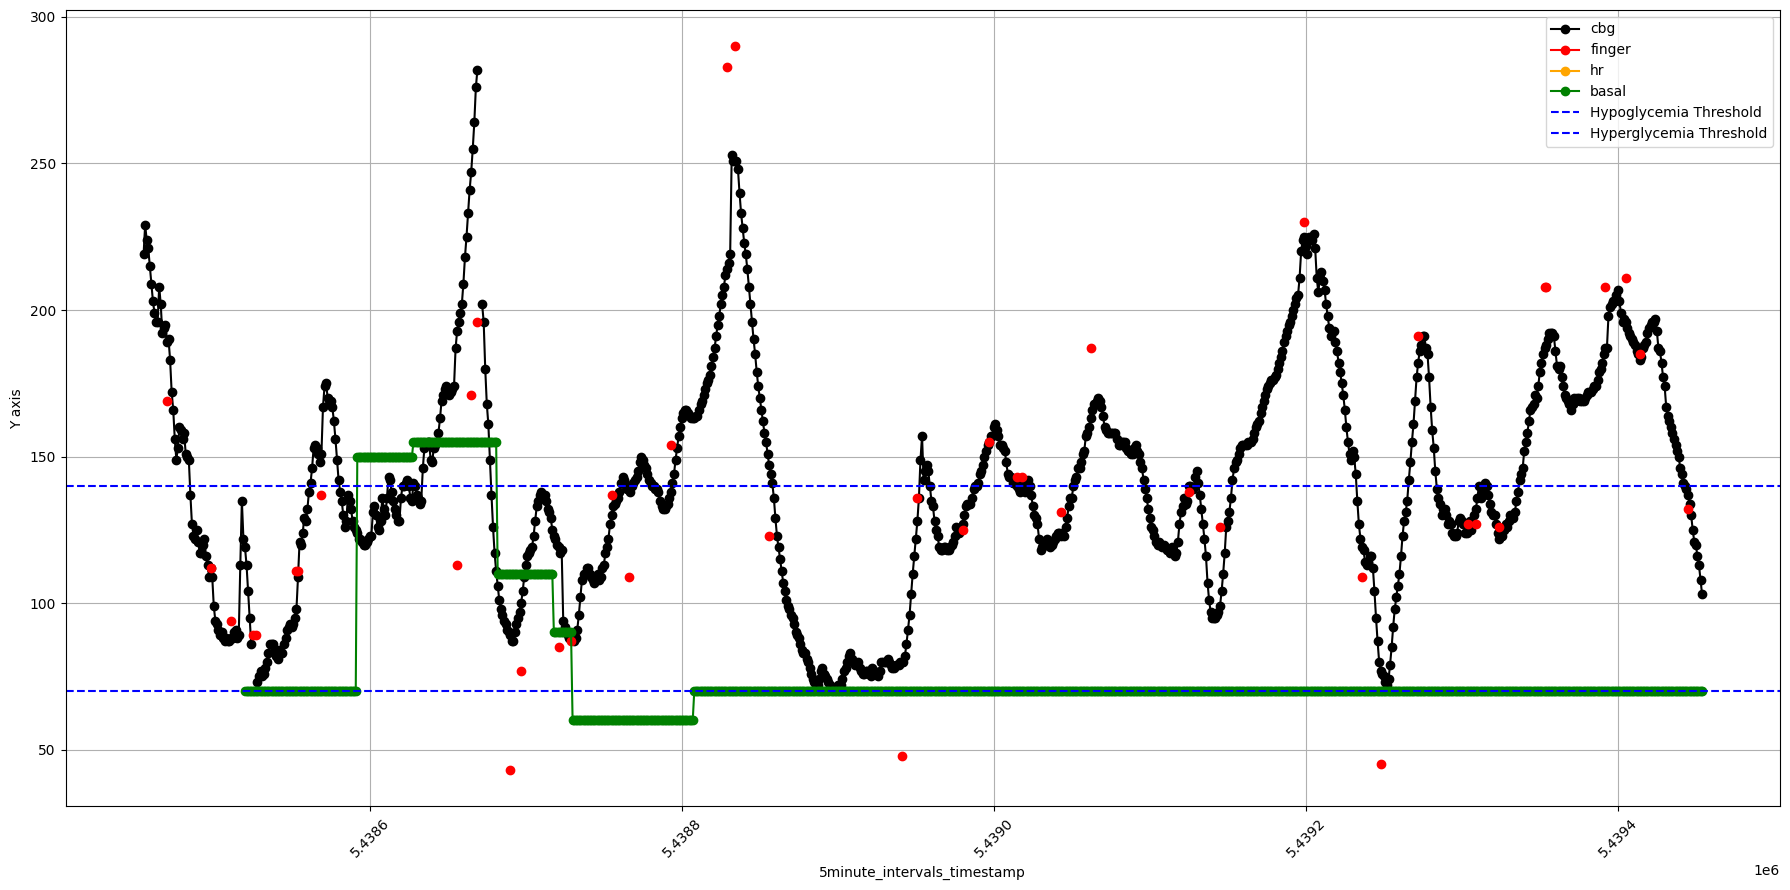

In [4]:
# Load specific patient excel path 
#file_path = r'C:\UniBern\DataDrivenDiabetes\Ohio_Data\Ohio2018_processed\train\563-ws-training_processed.csv'

# Load the CSV file into a pandas dataframe
df = pd.read_csv(file_path)

###################################### # code what you want in/out
# Filter rows where 'missing_cbg' is 0 (binary variable) -> this fills holes in cbg line
# filtered_df = df[df['missing_cbg'] == 0].head(1000)

# Or not, I still prefer only taking the first 1000 entries so I can see x,y relationship better
filtered_df = df.head(1000)
#####################################

# Plot lines
plt.figure(figsize=(18, 9))
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['cbg'], marker='o', linestyle='-', color='black', label='cbg')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['finger'], marker='o', linestyle='-', color='red', label='finger')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['hr'], marker='o', linestyle='-', color='orange', label='hr')

#TODO ADD bolus data to plot 

# I multipled the basal by 100 just so its easier to see in plot
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['basal']*100, marker='o', linestyle='-', color='green', label='basal')

# Variables that we can still plot and see what happens etc. -> hr, gsr, carbInput, bolus
# What I think they mean: hr>heart rate, gsr>Galvanic skin response, carbInput -> carb in grams?, 
# bolus> Insulin delivered to the patient, typically before a meal or when the patient is hyperglycemic.

# Horizontal line representing for hyper- and hypoglycemia, maybe it helps us see 
hypoglycemia_threshold = 70  # Not 100% sure about the value 
plt.axhline(y=hypoglycemia_threshold, color='blue', linestyle='--', label='Hypoglycemia Threshold')
hyperglycemia_threshold = 140 # Not 100% sure about the value 
plt.axhline(y=hyperglycemia_threshold, color='blue', linestyle='--', label='Hyperglycemia Threshold')

plt.xlabel('5minute_intervals_timestamp')
plt.ylabel('Y axis')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Load Dataset

In [5]:
# Path to the data folder

# Get the current working directory
current_directory = os.getcwd()

# Go one step up from the current directory
parent_directory = os.path.dirname(current_directory)

data_folder = os.path.join(parent_directory, 'dataset')
print(data_folder)

C:\Users\julia\Desktop\Studium_MA5\DataDrivenDiabetesManagement\Project\git\DataDrivenDiabetesSemesterProject\dataset


In [6]:
#data_folder = r'C:\Ohio_Data'

# List of patient excel IDs in the year folders
patient_ids_2018 = [559, 563, 570, 575, 588, 591]
patient_ids_2020 = [540, 544, 552, 567, 584, 596]

train_set_2018 = []
test_set_2018 = []
train_set_2020 = []
test_set_2020 = []

# not super pretty but works:
names_train_2018 = []
names_test_2018 = []
names_train_2020 = []
names_test_2020 = []

# For 2018 data
for patient_id in patient_ids_2018:
    for folder_type in ['training', 'testing']:
        file_name = f"{patient_id}-ws-{folder_type}_processed.csv"
        print(f"Load file: {file_name}")
        if folder_type == 'training':
            names_train_2018.append(file_name)
        else:
            names_test_2018.append(file_name)
        file_path = os.path.join(data_folder, 'Ohio2018_processed', folder_type[:-3], file_name)
        if os.path.exists(file_path): 
            patient_data = pd.read_csv(file_path)
            train_set_2018.append(patient_data) if folder_type == 'training' else test_set_2018.append(patient_data)
        else:
            print(f"File not found: {file_path}")
            raise FileNotFoundError("The target directory does not exist.")

# For 2020 data
for patient_id in patient_ids_2020:
    for folder_type in ['training', 'testing']:
        file_name = f"{patient_id}-ws-{folder_type}_processed.csv"
        print(f"Load file: {file_name}")
        if folder_type == 'training':
            names_train_2020.append(file_name)
        else:
            names_test_2020.append(file_name)
        file_path = os.path.join(data_folder, 'Ohio2020_processed', folder_type[:-3], file_name)
        if os.path.exists(file_path): 
            patient_data = pd.read_csv(file_path)
            train_set_2020.append(patient_data) if folder_type == 'training' else test_set_2020.append(patient_data)
        else:
            print(f"File not found: {file_path}")
            raise FileNotFoundError("The target directory does not exist.")

Load file: 559-ws-training_processed.csv
Load file: 559-ws-testing_processed.csv
Load file: 563-ws-training_processed.csv
Load file: 563-ws-testing_processed.csv
Load file: 570-ws-training_processed.csv
Load file: 570-ws-testing_processed.csv
Load file: 575-ws-training_processed.csv
Load file: 575-ws-testing_processed.csv
Load file: 588-ws-training_processed.csv
Load file: 588-ws-testing_processed.csv
Load file: 591-ws-training_processed.csv
Load file: 591-ws-testing_processed.csv
Load file: 540-ws-training_processed.csv
Load file: 540-ws-testing_processed.csv
Load file: 544-ws-training_processed.csv
Load file: 544-ws-testing_processed.csv
Load file: 552-ws-training_processed.csv
Load file: 552-ws-testing_processed.csv
Load file: 567-ws-training_processed.csv
Load file: 567-ws-testing_processed.csv
Load file: 584-ws-training_processed.csv
Load file: 584-ws-testing_processed.csv
Load file: 596-ws-training_processed.csv
Load file: 596-ws-testing_processed.csv


In [7]:
patient_index = 2
all_train_inter_model = []
print(type(all_train_inter_model))
for i in range(len(patient_ids_2018)):
    if i!=patient_index:
         all_train_inter_model.append(train_set_2018[i]) #pd.concat([all_train_inter_model, train_set_2018[i]], ignore_index=True)
all_train_inter_model  

<class 'list'>


[       5minute_intervals_timestamp  missing_cbg    cbg  finger  basal    hr  \
 0                     5.462799e+06          0.0  101.0     NaN    NaN   NaN   
 1                     5.462800e+06          0.0   98.0     NaN    NaN   NaN   
 2                     5.462801e+06          0.0  104.0     NaN    NaN   NaN   
 3                     5.462802e+06          0.0  112.0     NaN    NaN   NaN   
 4                     5.462803e+06          0.0  120.0     NaN    NaN   NaN   
 ...                            ...          ...    ...     ...    ...   ...   
 12075                 5.474876e+06          0.0  161.0     NaN   0.83  58.0   
 12076                 5.474877e+06          0.0  164.0     NaN   0.83  58.0   
 12077                 5.474878e+06          0.0  168.0     NaN   0.83  58.0   
 12078                 5.474879e+06          0.0  172.0     NaN   0.83  57.0   
 12079                 5.474880e+06          0.0  176.0     NaN   0.83  58.0   
 
             gsr  carbInput  bolus  
 

In [8]:
all_train_inter_model = pd.concat(all_train_inter_model, ignore_index=True)
all_train_inter_model

5minute_intervals_timestamp  missing_cbg    cbg  finger  basal    hr  \
0                     5.462799e+06          0.0  101.0     NaN    NaN   NaN   
1                     5.462800e+06          0.0   98.0     NaN    NaN   NaN   
2                     5.462801e+06          0.0  104.0     NaN    NaN   NaN   
3                     5.462802e+06          0.0  112.0     NaN    NaN   NaN   
4                     5.462803e+06          0.0  120.0     NaN    NaN   NaN   
...                            ...          ...    ...     ...    ...   ...   
64135                 5.473725e+06          0.0  266.0   325.0   0.98  66.0   
64136                 5.473726e+06          0.0  275.0     NaN   0.98  77.0   
64137                 5.473727e+06          0.0  268.0     NaN   0.98  70.0   
64138                 5.473728e+06          0.0  301.0     NaN   0.98  71.0   
64139                 5.473729e+06          0.0  290.0     NaN   0.98   NaN   

           gsr  carbInput  bolus  
0          NaN        NaN    NaN  
1          NaN        NaN    NaN  
2          NaN        NaN    NaN  
3          NaN        NaN    NaN  
4          NaN        NaN    NaN  
...        ...        ...    ...  
64135  0.24380        NaN    4.1  
64136  0.14526        NaN    NaN  
64137  0.05216        NaN    NaN  
64138  0.03046        NaN    NaN  
64139      NaN        NaN    NaN  

[64140 rows x 9 columns]

In [9]:
train_set_2018[2]

5minute_intervals_timestamp  missing_cbg    cbg  finger  basal    hr  \
0                     5.462982e+06          0.0  101.0     NaN    NaN   NaN   
1                     5.462983e+06          0.0  100.0     NaN    NaN   NaN   
2                     5.462984e+06          0.0  100.0     NaN    NaN   NaN   
3                     5.462985e+06          0.0   99.0     NaN    NaN   NaN   
4                     5.462986e+06          0.0   98.0     NaN    NaN   NaN   
...                            ...          ...    ...     ...    ...   ...   
11606                 5.474589e+06          0.0  113.0     NaN   0.88  82.0   
11607                 5.474590e+06          0.0  118.0     NaN   0.88  82.0   
11608                 5.474591e+06          0.0  120.0     NaN   0.88  83.0   
11609                 5.474592e+06          0.0  123.0     NaN   0.88  85.0   
11610                 5.474593e+06          0.0  128.0     NaN   0.88   NaN   

            gsr  carbInput  bolus  
0           NaN        NaN    NaN  
1           NaN        NaN    NaN  
2           NaN        NaN    NaN  
3           NaN        NaN    NaN  
4           NaN        NaN    NaN  
...         ...        ...    ...  
11606  0.000054        NaN    NaN  
11607  0.000056        NaN    NaN  
11608  0.000057        NaN    NaN  
11609  0.000058        NaN    NaN  
11610  0.000058        NaN    NaN  

[11611 rows x 9 columns]

In [10]:

print(train_set_2018)

[       5minute_intervals_timestamp  missing_cbg    cbg  finger  basal    hr  \
0                     5.462799e+06          0.0  101.0     NaN    NaN   NaN   
1                     5.462800e+06          0.0   98.0     NaN    NaN   NaN   
2                     5.462801e+06          0.0  104.0     NaN    NaN   NaN   
3                     5.462802e+06          0.0  112.0     NaN    NaN   NaN   
4                     5.462803e+06          0.0  120.0     NaN    NaN   NaN   
...                            ...          ...    ...     ...    ...   ...   
12075                 5.474876e+06          0.0  161.0     NaN   0.83  58.0   
12076                 5.474877e+06          0.0  164.0     NaN   0.83  58.0   
12077                 5.474878e+06          0.0  168.0     NaN   0.83  58.0   
12078                 5.474879e+06          0.0  172.0     NaN   0.83  57.0   
12079                 5.474880e+06          0.0  176.0     NaN   0.83  58.0   

            gsr  carbInput  bolus  
0           Na

In [11]:
print(len(test_set_2018))

6


## Correlation among independant variables of full dataset of required variables

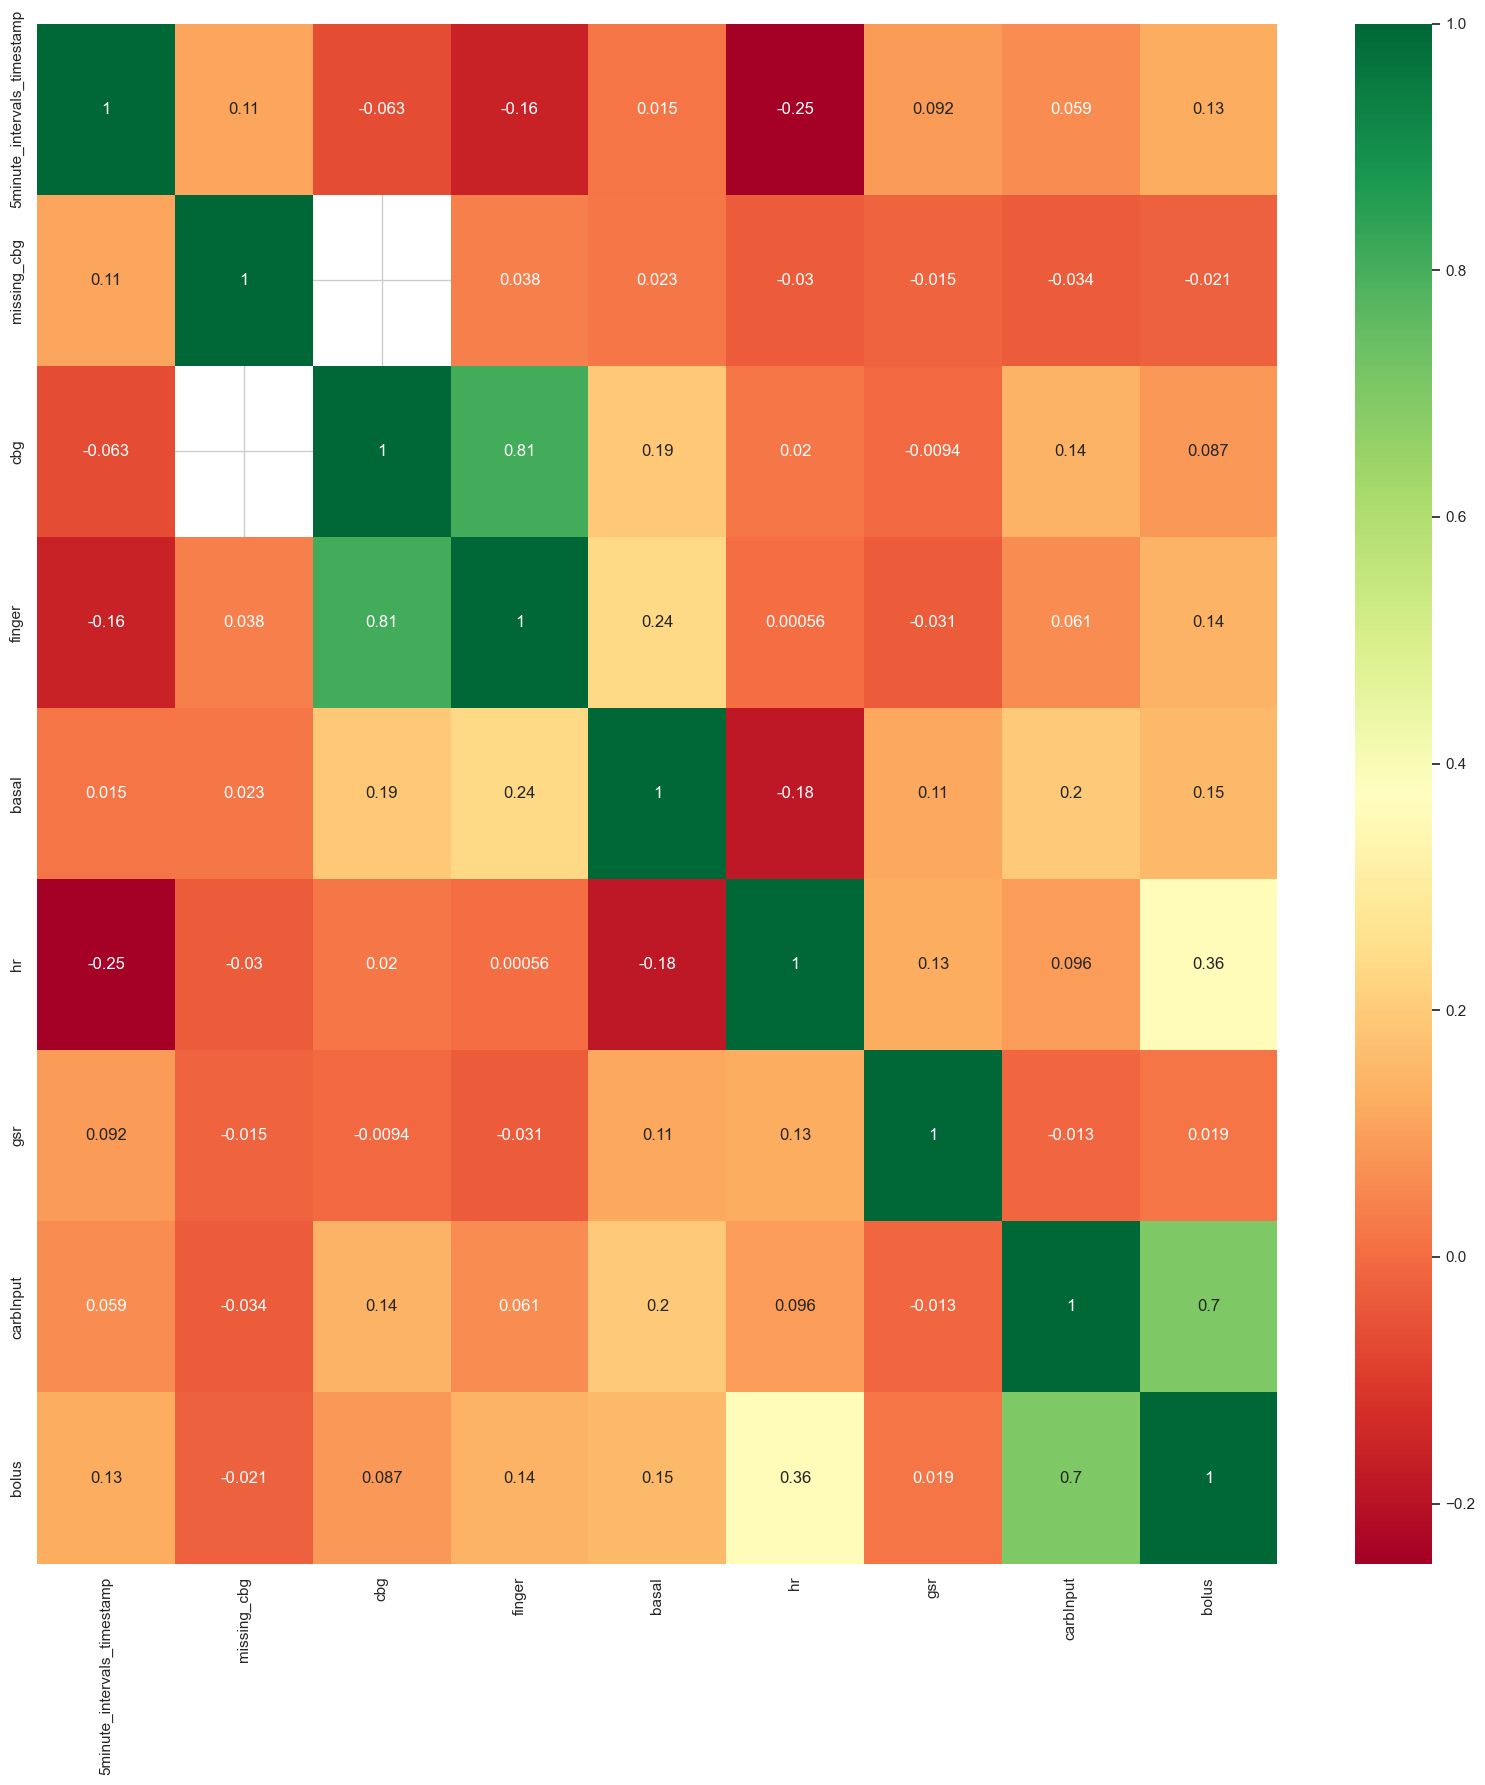

In [12]:
import seaborn as sns

# To plot correlation of all patients together we need to concatenate the datasets of each patient together
all_train_2018 = pd.concat(train_set_2018, ignore_index=True)
all_test_2018 = pd.concat(test_set_2018, ignore_index=True)

all_train_2020 = pd.concat(train_set_2020, ignore_index=True)
all_test_2020 = pd.concat(test_set_2020, ignore_index=True)

# Concatenate all training and testing sets from both years
X = pd.concat([all_train_2018, all_test_2018, all_train_2020, all_test_2020], ignore_index=True)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
    
#get correlations of each features in dataset
corrmat = pd.DataFrame(X).corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(pd.DataFrame(X[top_corr_features]).corr(),annot=True,cmap="RdYlGn")
g=sns.heatmap(pd.DataFrame(X).corr(),annot=True,cmap="RdYlGn")

In [13]:
print(all_train_2018.columns)
print(all_train_2018.shape)
print(all_train_2018)

Index(['5minute_intervals_timestamp', 'missing_cbg', 'cbg', 'finger', 'basal',
       'hr', 'gsr', 'carbInput', 'bolus'],
      dtype='object')
(75751, 9)
       5minute_intervals_timestamp  missing_cbg    cbg  finger  basal    hr  \
0                     5.462799e+06          0.0  101.0     NaN    NaN   NaN   
1                     5.462800e+06          0.0   98.0     NaN    NaN   NaN   
2                     5.462801e+06          0.0  104.0     NaN    NaN   NaN   
3                     5.462802e+06          0.0  112.0     NaN    NaN   NaN   
4                     5.462803e+06          0.0  120.0     NaN    NaN   NaN   
...                            ...          ...    ...     ...    ...   ...   
75746                 5.473725e+06          0.0  266.0   325.0   0.98  66.0   
75747                 5.473726e+06          0.0  275.0     NaN   0.98  77.0   
75748                 5.473727e+06          0.0  268.0     NaN   0.98  70.0   
75749                 5.473728e+06          0.0  301.0 

In [14]:
print(all_train_2018)

       5minute_intervals_timestamp  missing_cbg    cbg  finger  basal    hr  \
0                     5.462799e+06          0.0  101.0     NaN    NaN   NaN   
1                     5.462800e+06          0.0   98.0     NaN    NaN   NaN   
2                     5.462801e+06          0.0  104.0     NaN    NaN   NaN   
3                     5.462802e+06          0.0  112.0     NaN    NaN   NaN   
4                     5.462803e+06          0.0  120.0     NaN    NaN   NaN   
...                            ...          ...    ...     ...    ...   ...   
75746                 5.473725e+06          0.0  266.0   325.0   0.98  66.0   
75747                 5.473726e+06          0.0  275.0     NaN   0.98  77.0   
75748                 5.473727e+06          0.0  268.0     NaN   0.98  70.0   
75749                 5.473728e+06          0.0  301.0     NaN   0.98  71.0   
75750                 5.473729e+06          0.0  290.0     NaN   0.98   NaN   

           gsr  carbInput  bolus  
0          NaN  

In [15]:
duplicates = all_train_2018.duplicated()
duplicates

0        False
1        False
2        False
3        False
4        False
         ...  
75746    False
75747    False
75748    False
75749    False
75750    False
Length: 75751, dtype: bool

In [16]:
number_of_duplicates = all_train_2018.duplicated().sum()
number_of_duplicates

0

In [17]:
duplicates_in_columns = all_train_2018.duplicated(subset=['5minute_intervals_timestamp'])

In [18]:
duplicates_in_columns.sum()

0

## Preprocessing

In [16]:
def preprocess_data(data):
    # Replace any 0 values in 'finger' with corresponding values from 'cbg'
    data.loc[data['finger'] == 0, 'finger'] = data.loc[data['finger'] == 0, 'cbg'] 

    data['finger'][::50] =  data['cbg'][::50] 
    
    # Periods of no food or bolus injected
    data['bolus'].fillna(0.0, inplace=True)
    data['carbInput'].fillna(0.0, inplace=True)
    
    # Interpolate the zones with missing 'cbg' so there is not regions with super steep changes 
    # TODO: Only do interpolation when missing_cbg is small 
    # TODO: After doing interpolation, set the missing_cbg of the interpolated to 0
    data['cbg'] = data['cbg'].interpolate(method='linear', limit_direction='both')
    
    # BASAL, do we do anything there? there is periods with 0.0 and NaN???
    #  Basal is the rate at which basal insulin is continuously infused. If it NaN it should be 0 then no?
    
    return data 

## Prepare date for training and testing

In [20]:
# index_patient_570 = 2
# dataset = train_set_2018[index_patient_570]

# dataset = preprocess_data(dataset)

# # TODO: Figure out this lenghts 
# # TODO: Decide we should create a super model for every patient or 1 per patient
# # TODO: Check which replacement values/inference of using 0/-1/NaN for finger and basal
# # TODO: Test train with 1 only patient, with all patients together of same year
# # TODO: Train also with CGM as explanatory feature? 

# def read_patient(dataset, training_test_proportion=0.8, finger_window=1, prediction_window=80):

#     # Use cbg, smbg, bolus, carbInput and the other stuff as inputs
#     features = ['cbg', 'finger', 'basal', 'hr', 'gsr', 'carbInput', 'bolus'] 
#     dataset = dataset[features].values

#     training_data_len = math.ceil(len(dataset) *training_test_proportion)
#     # print(training_data_len) - 9289

#     # Scalling data from 0 - 1 for each individual feature, considering NaN to be unchanged 
#     scaled_data = np.zeros((dataset.shape[0], dataset.shape[1]))

#     scalers_transforms = []
    
#     for i in range(dataset.shape[1]):
#         # Extract the column and remember where NaNs are
#         column = dataset[:, i]
#         isnan_mask = np.isnan(column)

#         # Replace NaN values with the mean of the non-NaN elements for scaling
#         column_mean = np.nanmean(column)
#         column[isnan_mask] = column_mean
    
#         # Scale the data
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         scaled_column = scaler.fit_transform(column.reshape(-1, 1))
    
#         # We store a -1 value where there is a NaN value 
#         scaled_column[isnan_mask] = 0  # we can set here either to -1 or 0, still have # TODO
        
#         scaled_data[:, i] = scaled_column.flatten()

#         scalers_transforms.append(scaler)

#         column[isnan_mask] = np.nan
            
#     train_data = scaled_data[0:training_data_len, : ] # (9289, 7)

#     # print(train_data[:50, :])
    
#     x_train=[] # arrays of blood glucose with len of input_len
#     y_train = [] # arrays of blood glucose with len of output_len

#     # 'cbg' is the target, but we're using all features for input
#     for i in range(prediction_window,len(train_data)):
#         x_train.append(train_data[i-prediction_window:i:finger_window, 1:]) # to learn past data 6 features 
#         y_train.append(train_data[i-prediction_window:i, 0])  # to predict, 0 corresponds to 'cbg' as the prediction target ##### maybe wrong
    
#     # for i in range(input_len,len(train_data)-output_len):
#     #     x_train.append(train_data[i-input_len:i, :]) # to learn past data 7 features 
#     #     y_train.append(train_data[i:i+output_len, 0])  # to predict, 0 corresponds to 'cbg' as the prediction target ##### maybe wrong

#     # print(np.shape(x_train))
#     # print(np.shape(y_train)) # shape is 2D not 3D like x_train
        
#     x_train, y_train = np.array(x_train), np.array(y_train) # converting from list to numpy array
    
#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)-1)) # windows, past values, features

#     not_scaled_test_data = dataset[training_data_len - prediction_window: , : ]
#     test_data = scaled_data[training_data_len - prediction_window: , : ]

#     x_test = [] # arrays of blood glucose with len of input_len
#     y_test = [] # arrays of blood glucose with len of output_len
#     continuous_ytest = [] # list with not scaled blood glucose from y_test not broken into arrays

#     i = prediction_window
#     while (i >= prediction_window and i < len(test_data)):
#         x_test.append(test_data[i-prediction_window:i:finger_window, 1:])
#         y_test.append(not_scaled_test_data[i-prediction_window:i, 0]) ### maybe wrong
#         for bg in not_scaled_test_data[i-prediction_window:i,0]:
#             continuous_ytest.append(bg) # not for testing, just for plot purpose
#         i = i+prediction_window # jump output_len values in the future
        
#     x_test = np.array(x_test) # converting to numpy array
#     x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],len(features)-1))

#     smbg_scatter = not_scaled_test_data[:, 1]

#     return scaler, x_train, y_train, x_test, y_test, continuous_ytest, scalers_transforms, smbg_scatter

In [21]:
index_patient_570 = 2
train_set = train_set_2018[index_patient_570]
test_set = test_set_2018[index_patient_570]

# TODO: Decide we should create a super model for every patient or 1 per patient
# TODO: Check which replacement values/inference of using 0/-1/NaN for finger and basal
# TODO: Train also with CGM as explanatory feature? 
# TODO: Do a better number of artificial finger pricks (50 every time doesnt consider the finger we already have)
# TODO: Try without gsr, hr, etc. makes it simpler for the model
# TODO: Polish the code

# TODO: LAST THING -> Batch size, epoch, predwindow tests with different numbers

def read_patient(train_set, test_set, finger_window=1, prediction_window=80): 

    train_set = preprocess_data(train_set)
    test_set = preprocess_data(test_set)
    
    # Use cbg, smbg, bolus, carbInput and the other stuff as inputs
    features = ['cbg', 'finger', 'basal', 'hr', 'gsr', 'carbInput', 'bolus'] 
    train_set = train_set[features].values
    test_set = test_set[features].values

    # Scalling data from 0 - 1 for each individual feature, considering NaN to be unchanged 
    scaled_train_set = np.zeros((train_set.shape[0], train_set.shape[1]))
    scaled_test_set = np.zeros((test_set.shape[0], test_set.shape[1]))

    scalers_transforms_train = []
    scalers_transforms_test = []

    # Loop for the train set
    for i in range(train_set.shape[1]):
        # Extract the column and remember where NaNs are
        column = train_set[:, i]
        isnan_mask = np.isnan(column)

        # Replace NaN values with the mean of the non-NaN elements for scaling
        column_mean = np.nanmean(column)
        column[isnan_mask] = column_mean
    
        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_column = scaler.fit_transform(column.reshape(-1, 1))
    
        # We store a -1 value where there is a NaN value 
        scaled_column[isnan_mask] = 0  # we can set here either to -1 or 0, still have # TODO
        
        scaled_train_set[:, i] = scaled_column.flatten()

        scalers_transforms_train.append(scaler)

        column[isnan_mask] = np.nan
        
    # Loop for the test set
    for i in range(test_set.shape[1]):
        # Extract the column and remember where NaNs are
        column = test_set[:, i]
        isnan_mask = np.isnan(column)

        # Replace NaN values with the mean of the non-NaN elements for scaling
        column_mean = np.nanmean(column)
        column[isnan_mask] = column_mean
    
        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_column = scaler.fit_transform(column.reshape(-1, 1))
    
        # We store a -1 value where there is a NaN value 
        scaled_column[isnan_mask] = 0  # we can set here either to -1 or 0, still have # TODO
        
        scaled_test_set[:, i] = scaled_column.flatten()

        scalers_transforms_test.append(scaler)

        column[isnan_mask] = np.nan
            
    # train_data = scaled_data[0:training_data_len, : ] # (9289, 7)
    
    x_train=[] # arrays of blood glucose with len of input_len
    y_train = [] # arrays of blood glucose with len of output_len

    # 'cbg' is the target, but we're using all features for input
    for i in range(prediction_window,len(scaled_train_set)):
        x_train.append(scaled_train_set[i-prediction_window:i:finger_window, 1:]) # to learn past data 6 features 
        y_train.append(scaled_train_set[i-prediction_window:i, 0])  # to predict, 0 corresponds to 'cbg' as the prediction target ##### maybe wrong
            
    x_train, y_train = np.array(x_train), np.array(y_train) # converting from list to numpy array
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)-1)) # windows, past values, features

    #############################################
    
    x_test = [] # arrays of blood glucose with len of input_len
    y_test = [] # arrays of blood glucose with len of output_len
    continuous_ytest = [] # list with not scaled blood glucose from y_test not broken into arrays

    i = prediction_window
    while (i >= prediction_window and i < len(scaled_test_set)):
        x_test.append(scaled_test_set[i-prediction_window:i:finger_window, 1:])
        y_test.append(test_set[i-prediction_window:i, 0]) ### maybe wrong
        for bg in test_set[i-prediction_window:i,0]:
            continuous_ytest.append(bg) # not for testing, just for plot purpose
        i = i+prediction_window # jump output_len values in the future
        
    x_test = np.array(x_test) # converting to numpy array
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],len(features)-1))

    smbg_scatter = test_set[:, 1]

    return x_train, y_train, x_test, y_test, continuous_ytest, scalers_transforms_train, scalers_transforms_test, smbg_scatter

In [22]:
# scaler, x_train, y_train, x_test, y_test, continuous_ytest, scalers_transforms, smbg_scatter = read_patient(train_set, test_set)

x_train, y_train, x_test, y_test, continuous_ytest, scalers_transforms_train, scalers_transforms_test, smbg_scatter = read_patient(all_train_2018, test_set)

## LSTM Model function

In [56]:
def rmse(x_train, y_train):
    return K.sqrt(K.mean(K.square(y_train - x_train)))

In [27]:
def train_model(x_train, y_train, batch_size=1, epochs=1):
    # LSTM Model 
    print("YTRAIN SHAPE1: " +str(y_train.shape[1]))
    print("YTRAIN SHAPE: " +str(y_train.shape))
    print("XTRAIN SHAPE: " +str(x_train.shape))

    # Using the number of features in x_train to dynamically determine the input shape
    num_features = x_train.shape[2]
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], num_features)))
    model.add(LSTM(units=50, return_sequences=False)) # Return sequences for the next LSTM layer
    model.add(Dropout(0.5))
    model.add(Dense(units=y_train.shape[1]))
    # model.add(LSTM(units=50, return_sequences=True)) # Additional LSTM layer that returns sequences
    # model.add(TimeDistributed(Dense(1)))  # 1 or 7 ? because y_train has a shape of [?, 49, 7]

    # model.compile(optimizer="adam", loss='mse',metrics=['accuracy'])
    model.compile(optimizer="adam", loss='mse', metrics=[rmse])
    # TODO: ADAM uses learning_rate=0.001 as default, we can try different values 

    # TODO: Store loss values so we can have a plot
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

    return model, history


## Models We can try

In [58]:
# # MODEL 2

# def train_model2(x_train, y_train, batch_size=1, epochs=1):
#     # LSTM Model 

#     # Using the number of features in x_train to dynamically determine the input shape
#     num_features = x_train.shape[2]
    
#     model = Sequential()
#     model.add(Masking(mask_value = -1.,  input_shape=(x_train.shape[1], num_features)))
#     model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], num_features)))
#     model.add(LSTM(units=50, return_sequences=False)) # Return sequences for the next LSTM layer
#     model.add(Dropout(0.5))
    
#     model.add(Dense(units=y_train.shape[1]))
#     # model.add(LSTM(units=50, return_sequences=True)) # Additional LSTM layer that returns sequences
#     # model.add(TimeDistributed(Dense(1)))  # 1 or 7 ? because y_train has a shape of [?, 49, 7]

#     model.compile(optimizer="adam", loss='mse',metrics=['accuracy'])
    
#     model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

#     return model


In [59]:
# # MODEL 3

# def train_model3(x_train, y_train, batch_size=1, epochs=1):
#     # LSTM Model 

#     # Using the number of features in x_train to dynamically determine the input shape
#     num_features = x_train.shape[2]
    
#     model = Sequential()
#     model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], num_features)))
#     model.add(LSTM(units=50, return_sequences=False)) # Return sequences for the next LSTM layer
#     model.add(Dropout(0.5))
    
#     model.add(Dense(units=y_train.shape[1]))
#     # model.add(LSTM(units=50, return_sequences=True)) # Additional LSTM layer that returns sequences
#     # model.add(TimeDistributed(Dense(1)))  # 1 or 7 ? because y_train has a shape of [?, 49, 7]

#     model.compile(optimizer="adam", loss='mse',metrics=['accuracy'])

#     print(x_train.shape)

#     # Create weights for your data (1 for valid data and 0 for data to ignore)
#     weights = np.ones((x_train.shape[0],x_train.shape[1],x_train.shape[2]))

#     print(weights.shape)
    
#     weights[x_train == -1] = 0

#     model.fit(x_train, y_train, sample_weight=weights, batch_size=batch_size, epochs=epochs)

#     return model

## Prediction Function

In [25]:
def make_prediction(scalers_transforms_test, model, x_test, y_test):

    # Make predictions
    predictions = model.predict(x_test)

    predictions = np.reshape(predictions, (predictions.shape[0],predictions.shape[1])) # reshape just like y_test

    predictions = scalers_transforms_test[0].inverse_transform(predictions) #########
    
    # for i in range(predictions.shape[1]):
    #     column = predictions[0, i].reshape(-1, 1)
    #     predictions = scalers_transforms[i].inverse_transform(column).flatten()

    # Create a continuous data of predictions to plot with continuous_ytest
    continuous_predictions = predictions[0]

    for i in range(1,len(predictions)):
        continuous_predictions = np.concatenate([continuous_predictions,predictions[i]])

    # continuous_predictions = scalers_transforms[0].inverse_transform(continuous_predictions.reshape(-1, 1)).flatten()

    print(continuous_predictions)

    print(np.shape(continuous_predictions))
    print(np.shape(predictions))

    y_test = np.array(y_test)
    rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

    return predictions, continuous_predictions, rmse 

## Plot the results
  

In [26]:
def show_plots(continuous_ytest, continuous_predictions, smbg_scatter):
    plt.figure(figsize=(16,8))
    plt.title('Blood Glucose Prediction Model Result')
    plt.plot(continuous_ytest, color = 'b')
    plt.plot(continuous_predictions, color = 'r') 
    plt.scatter(np.arange(len(smbg_scatter)), smbg_scatter, color = 'black', marker='o')
    plt.xlabel('Timestamp',fontsize=18)
    plt.ylabel('BGBG (mg/dL)',fontsize=18)
    plt.legend(['Real','Predictions'], loc='lower right')
    plt.show()

## TESTING

In [28]:
model, history = train_model(x_train, y_train, batch_size=25, epochs=25)

YTRAIN SHAPE1: 80
YTRAIN SHAPE: (75671, 80)
XTRAIN SHAPE: (75671, 80, 6)
Epoch 1/25


NotImplementedError: in user code:

    File "C:\Users\julia\anaconda3\envs\diabetesManagement\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\julia\anaconda3\envs\diabetesManagement\lib\site-packages\statsmodels\tools\eval_measures.py", line 67, in rmse  *
        x1 = np.asanyarray(x1)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (IteratorGetNext:1) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [48]:
predictions, continuous_predictions, rmse = make_prediction(scalers_transforms_test, model, x_test, y_test)

2/2 [==============================] - 0s 10ms/step
[174.64682  173.30037  171.59663  ... 104.93941  105.803444 106.76418 ]
(2800,)
(35, 80)


(35, 80)


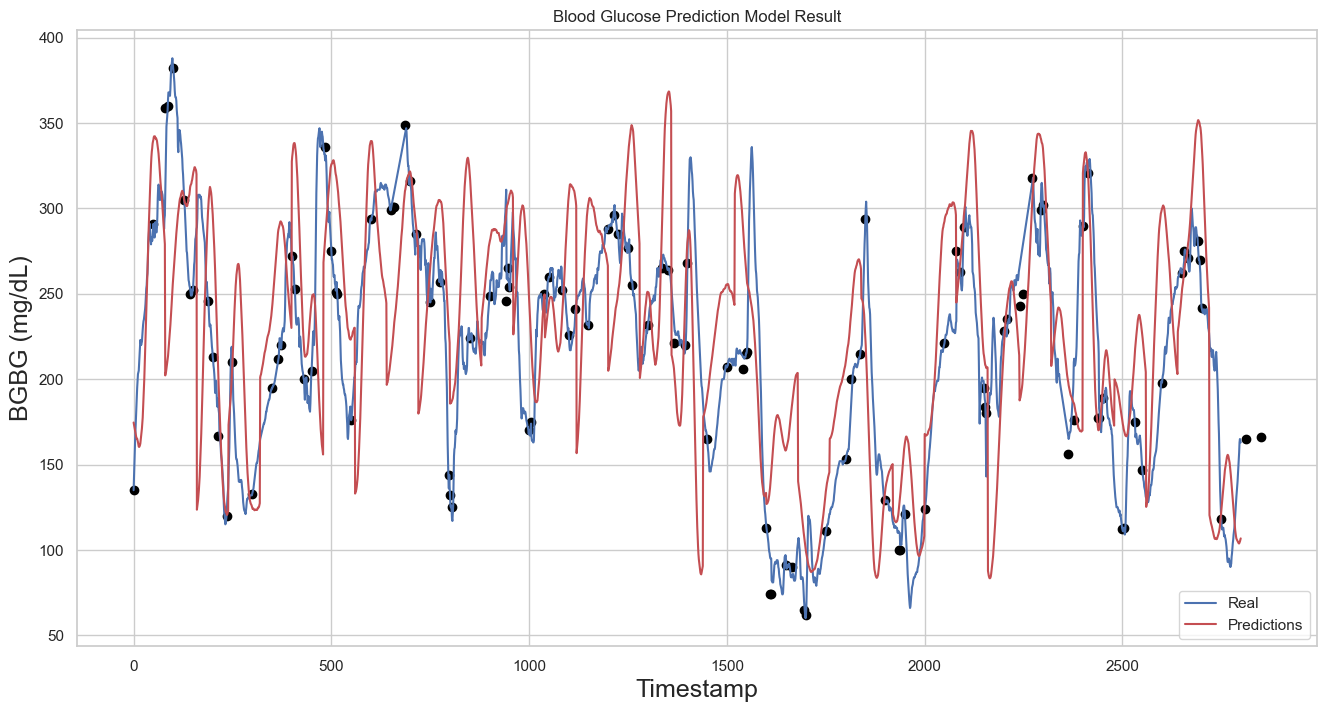

In [49]:
print(predictions.shape)

show_plots(continuous_ytest, continuous_predictions,  smbg_scatter)

In [50]:
print(smbg_scatter)

[135.  nan  nan ...  nan  nan  nan]


In [51]:
print("Root-Mean-Squared Deviation {}".format(rmse))

Root-Mean-Squared Deviation 58.16896101610383


In [52]:
# Every 10th value without Masking for -1: 13.93
# Every 50th value without Masking for -1: 39.59
# Every 50th value with Masking for -1: 44.79
# Every 50th value without Masking for 0: 33.98

print(np.shape(x_train))
print(np.shape(continuous_ytest))
print(np.shape(continuous_predictions))

(75671, 80, 6)
(2800,)
(2800,)


## Plot the loss function

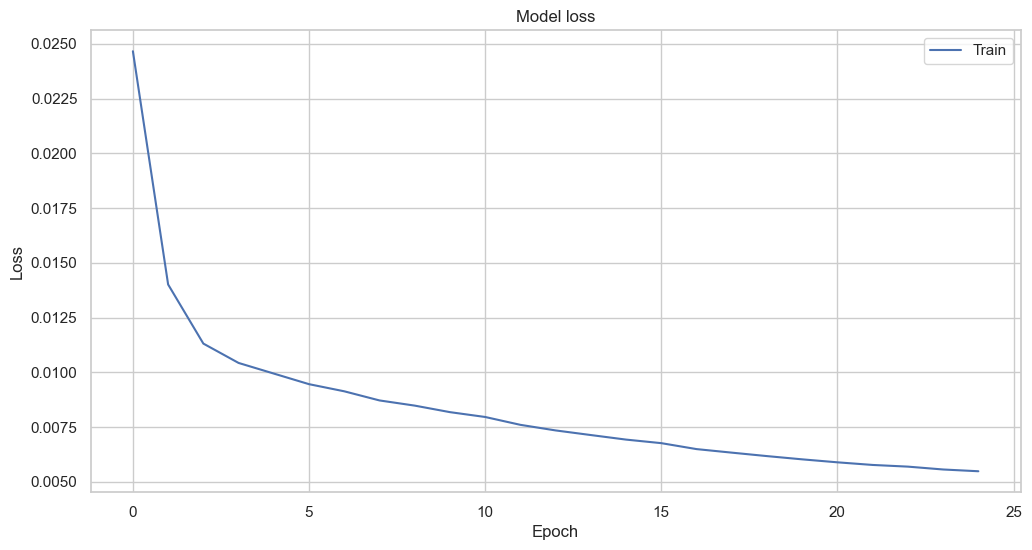

In [53]:
# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

Data: train_set_2018
Patient:  559-ws-training_processed.csv


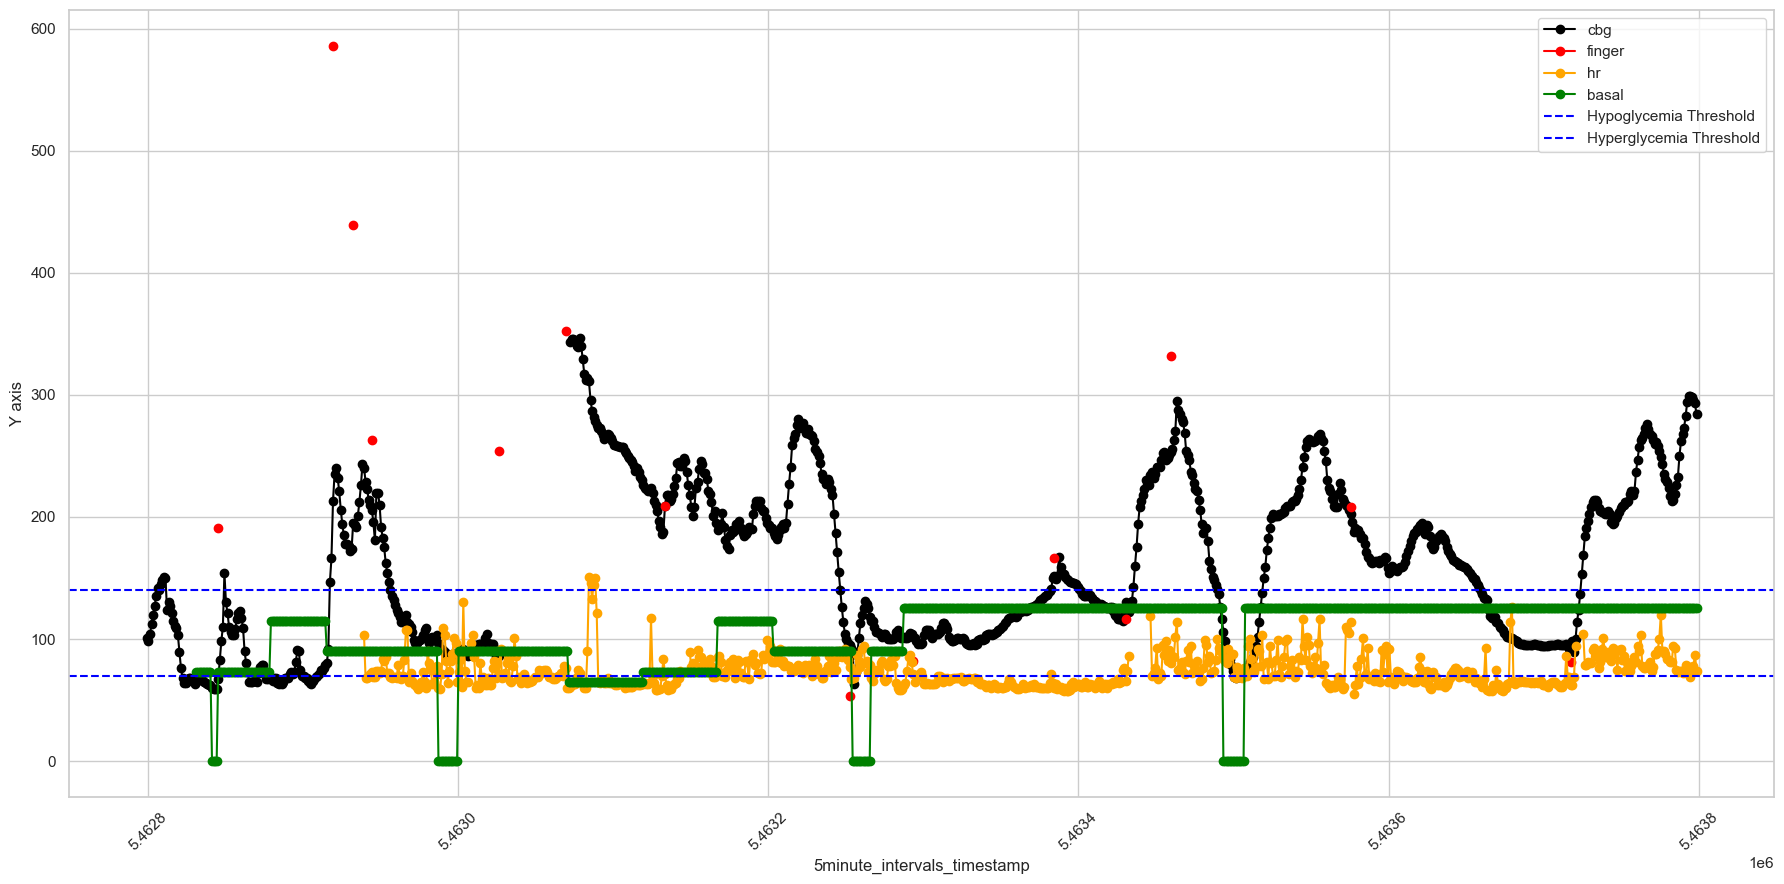

Patient:  563-ws-training_processed.csv


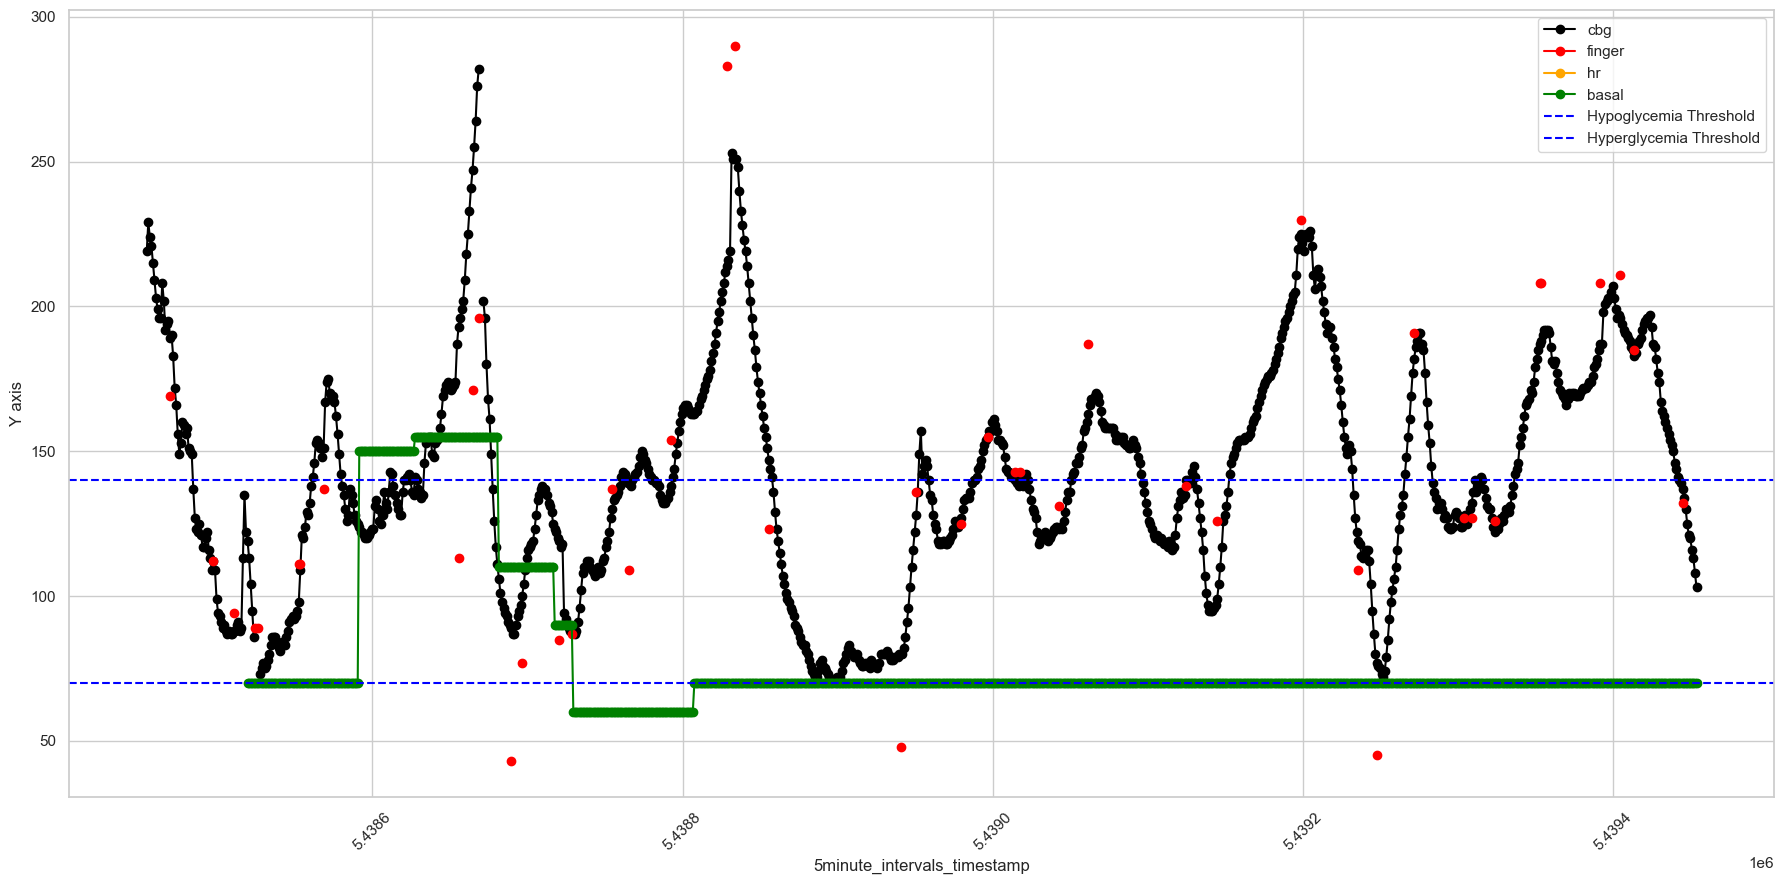

Patient:  570-ws-training_processed.csv


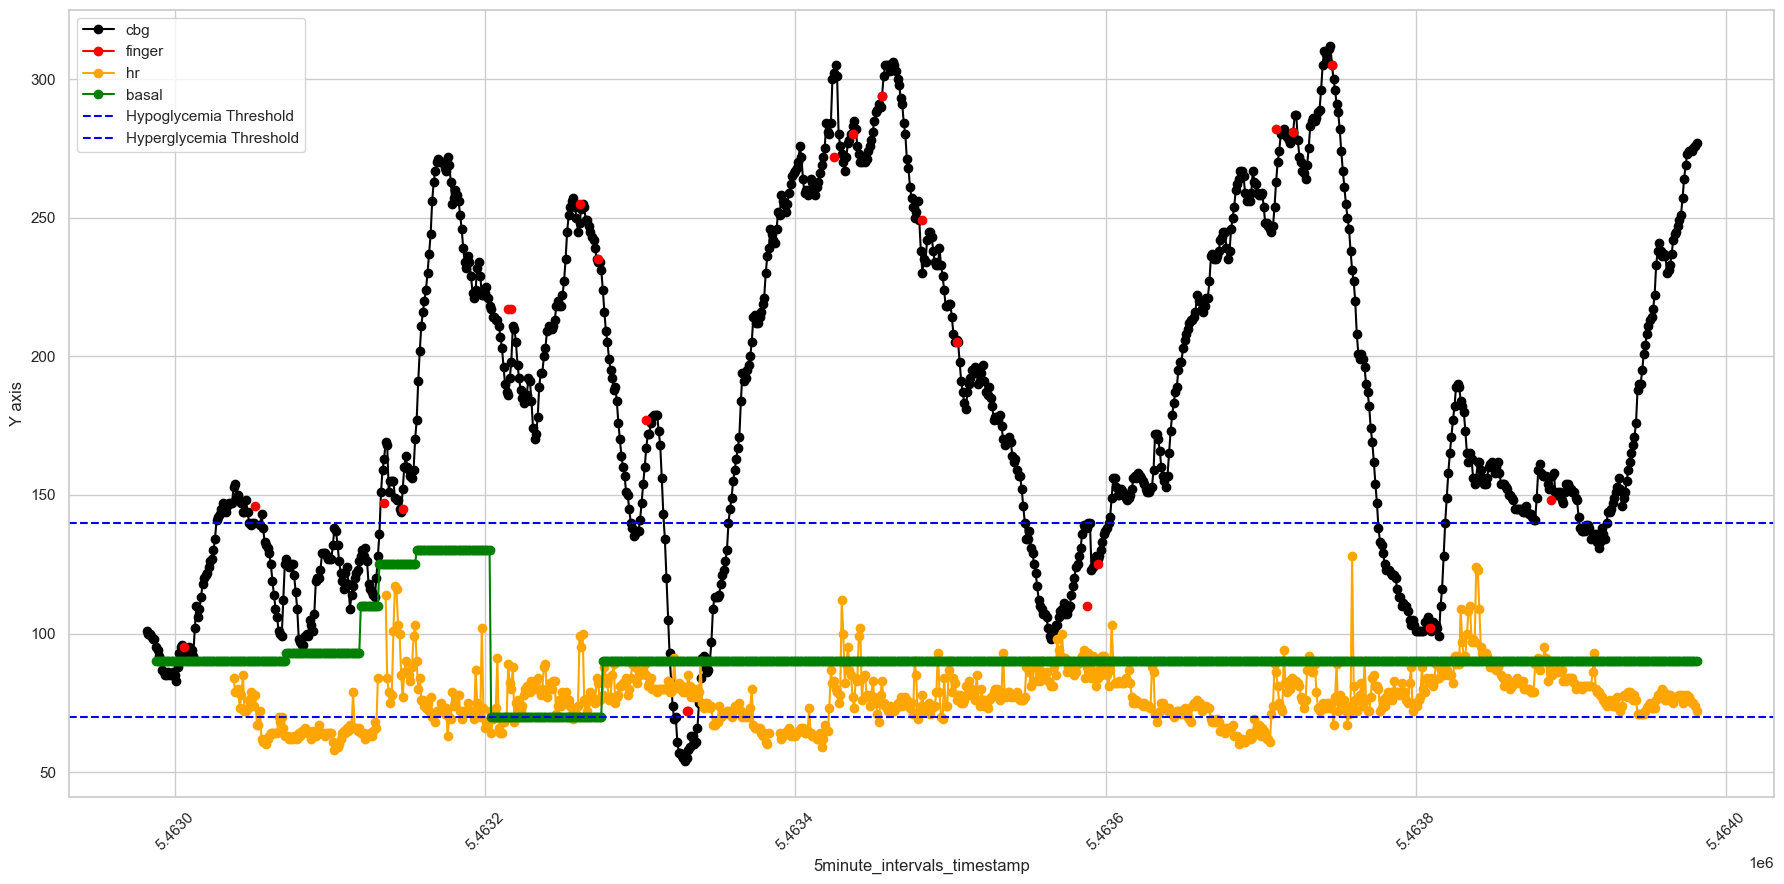

Patient:  575-ws-training_processed.csv


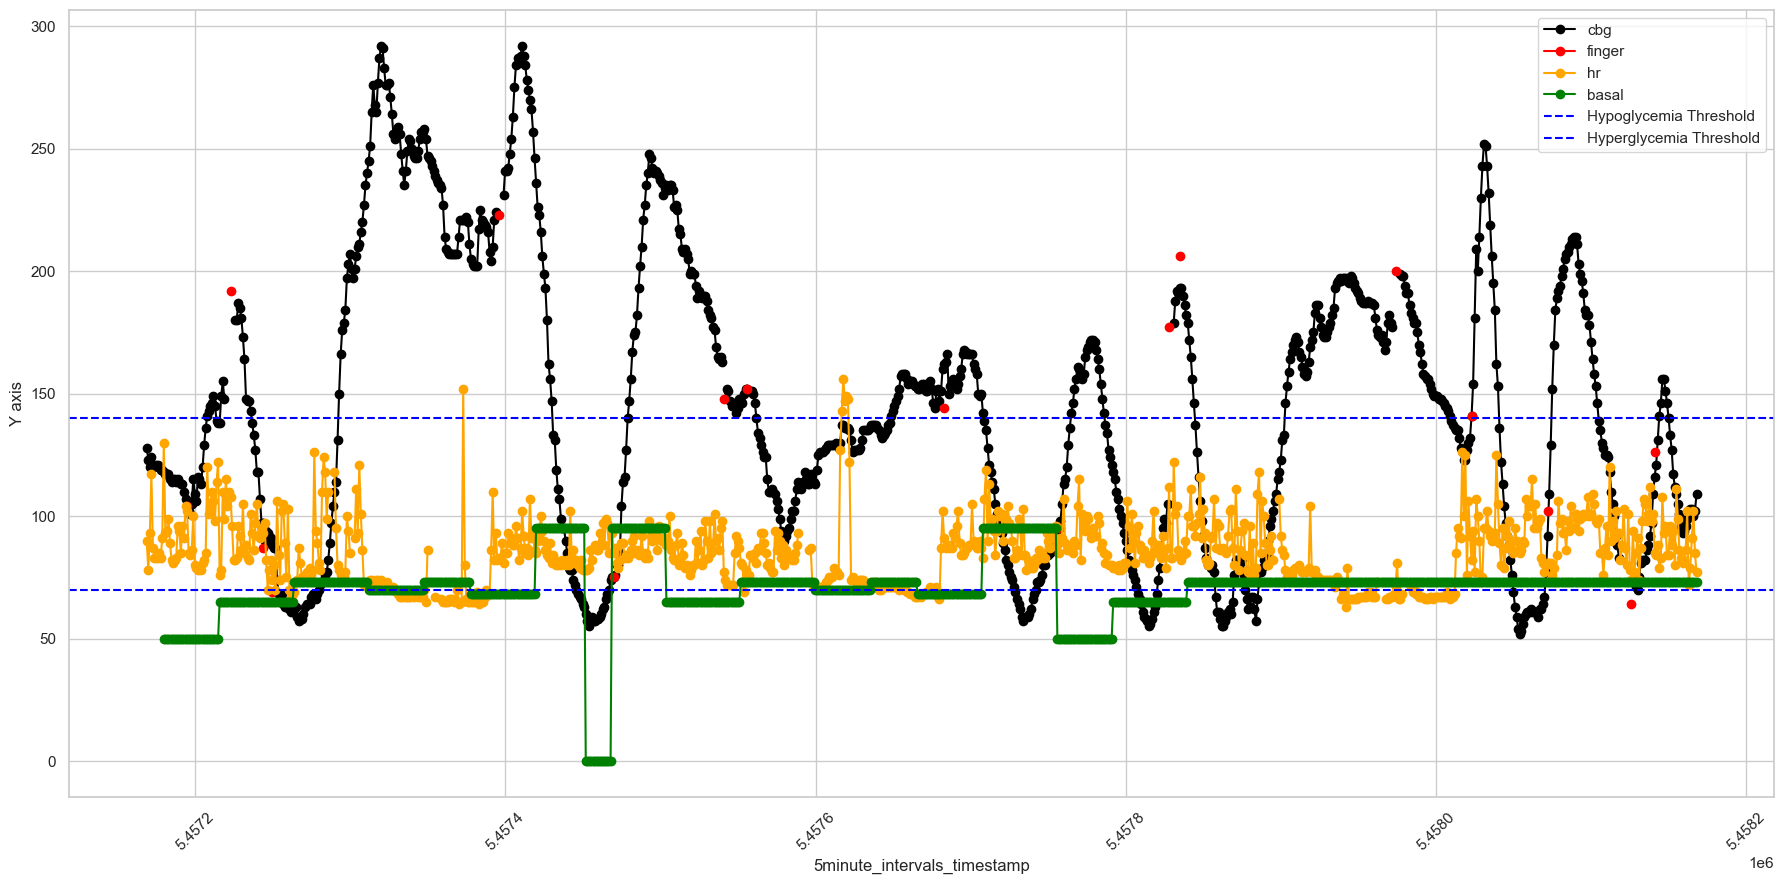

Patient:  588-ws-training_processed.csv


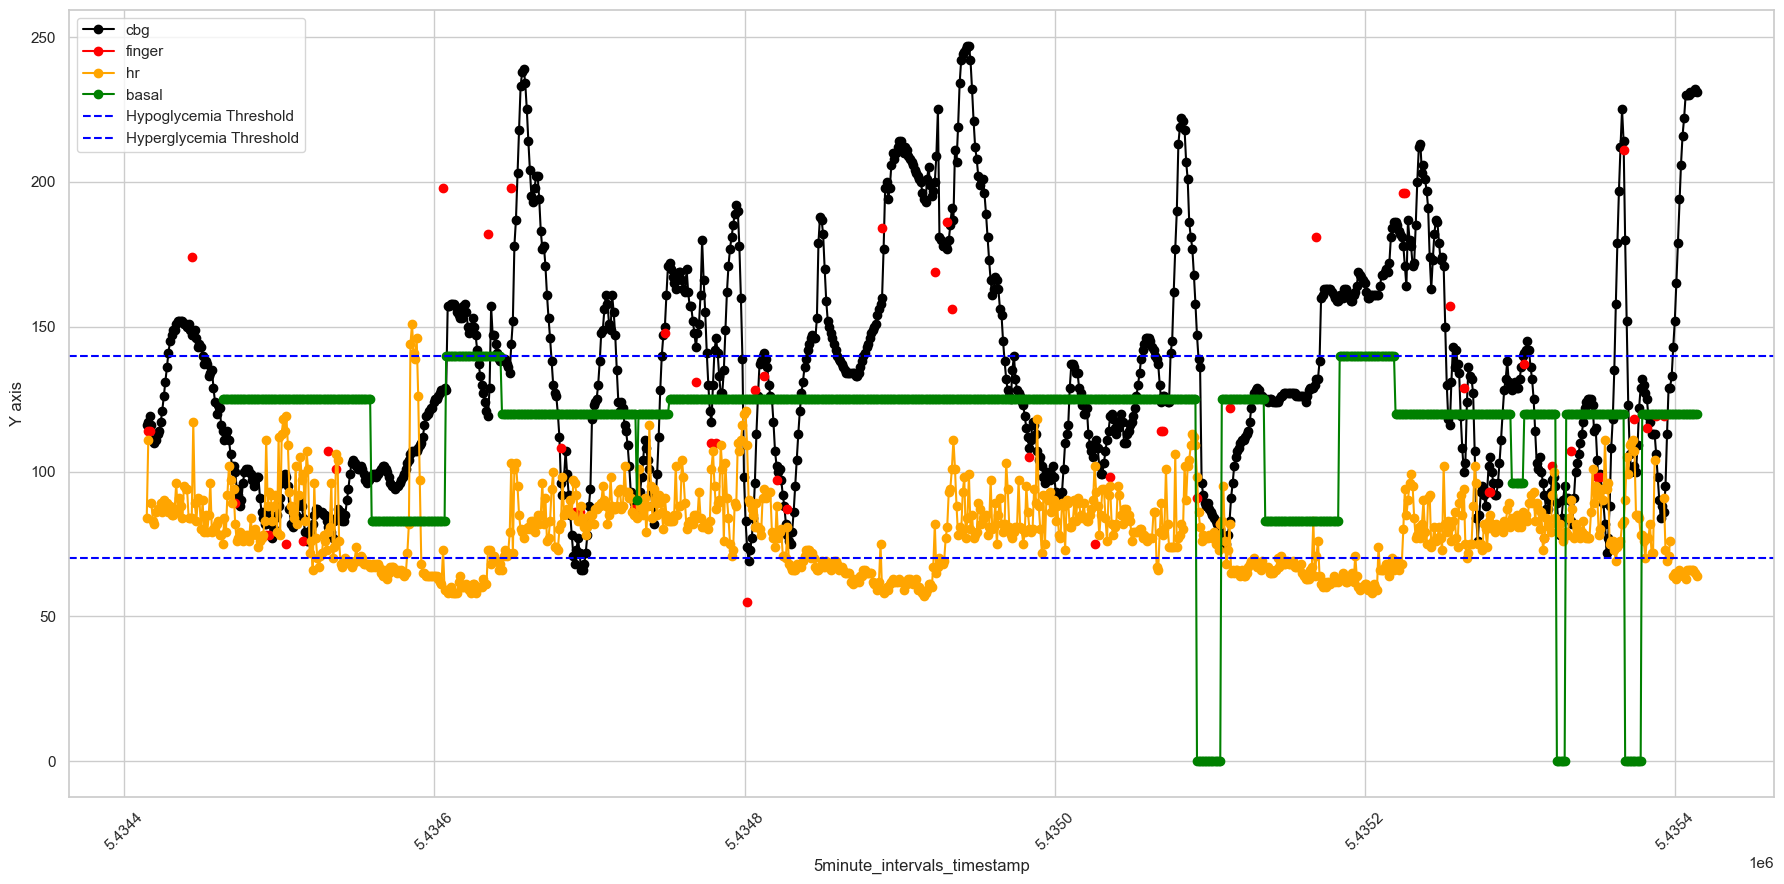

Patient:  591-ws-training_processed.csv


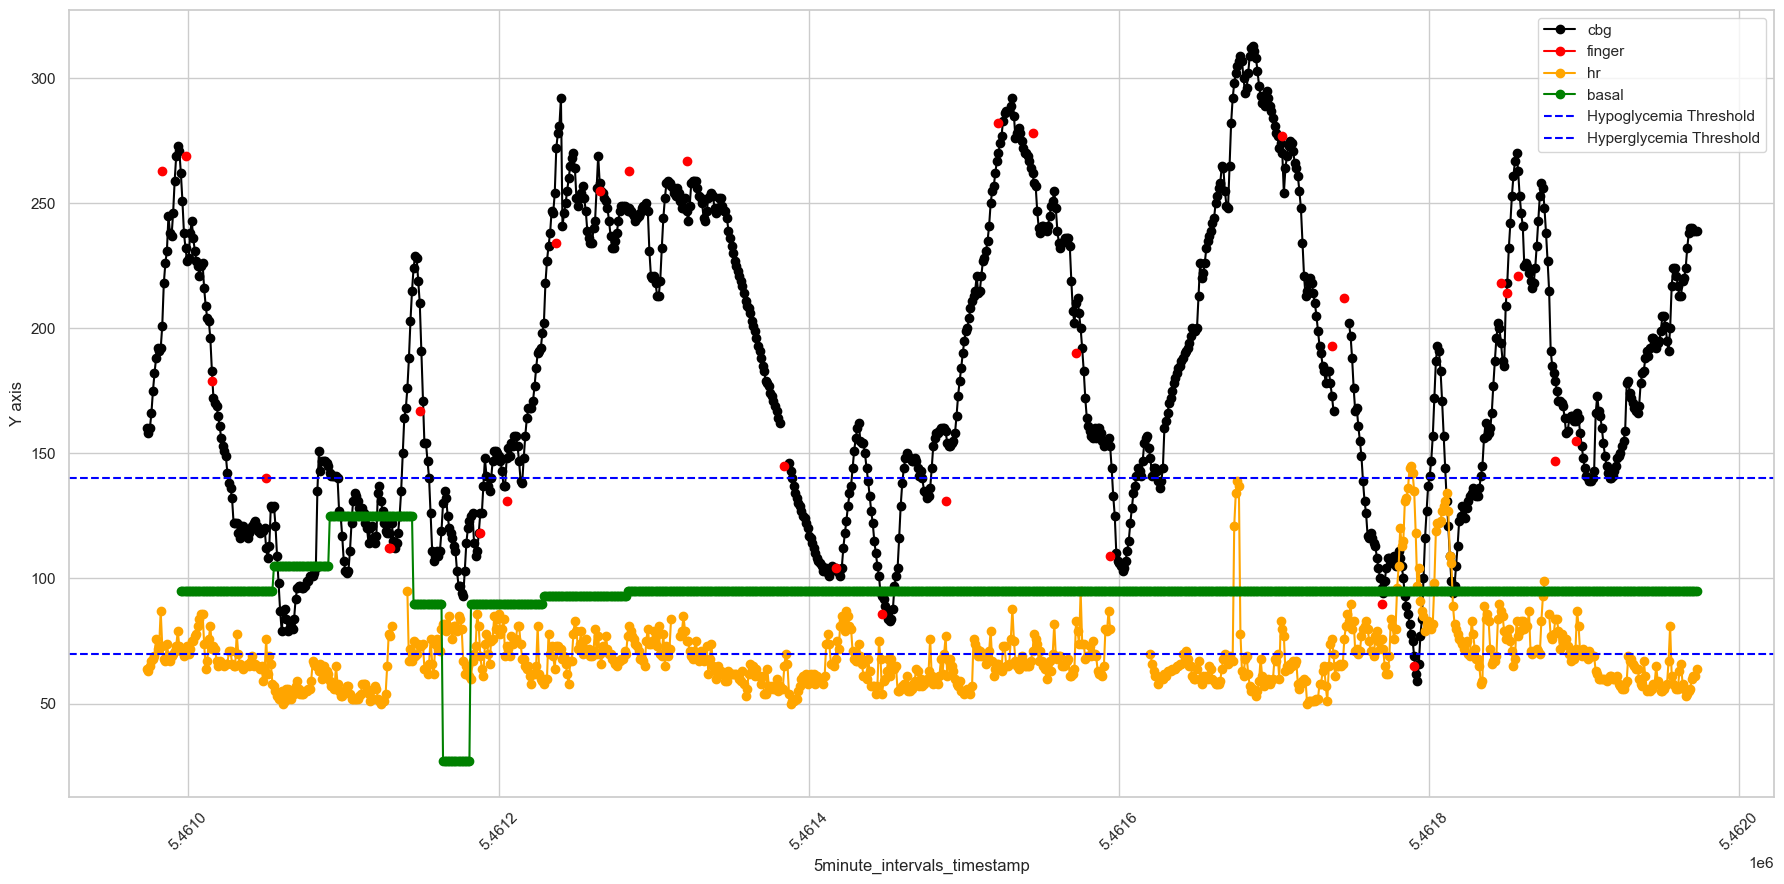

Data: test_set_2018
Patient:  559-ws-testing_processed.csv


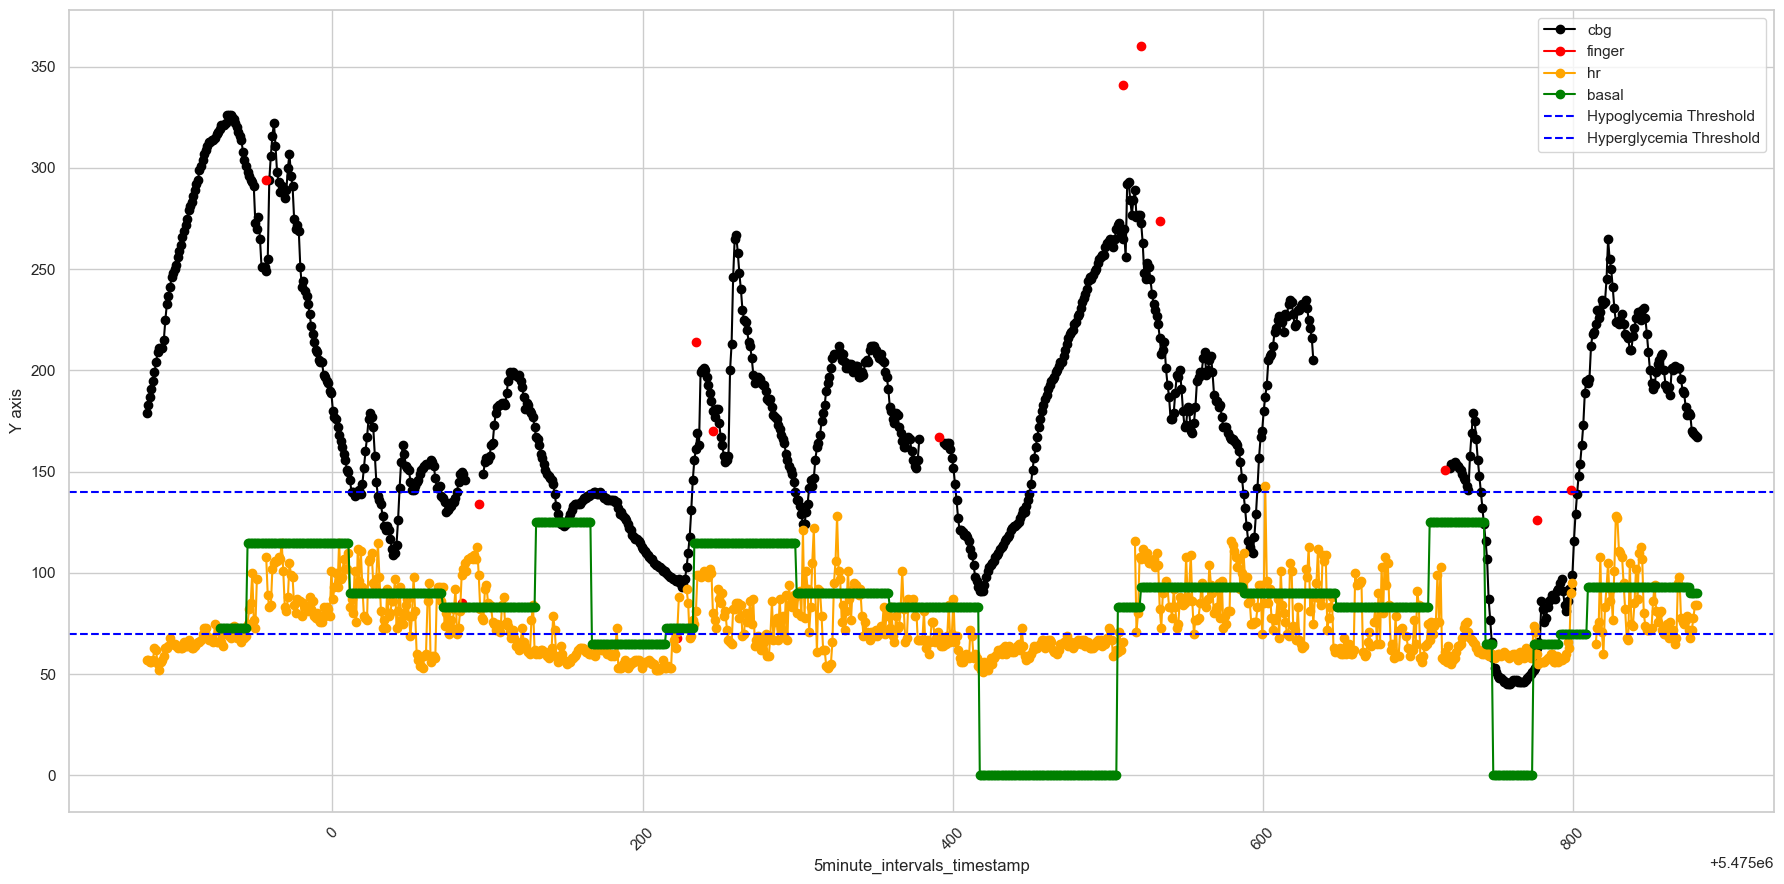

Patient:  563-ws-testing_processed.csv


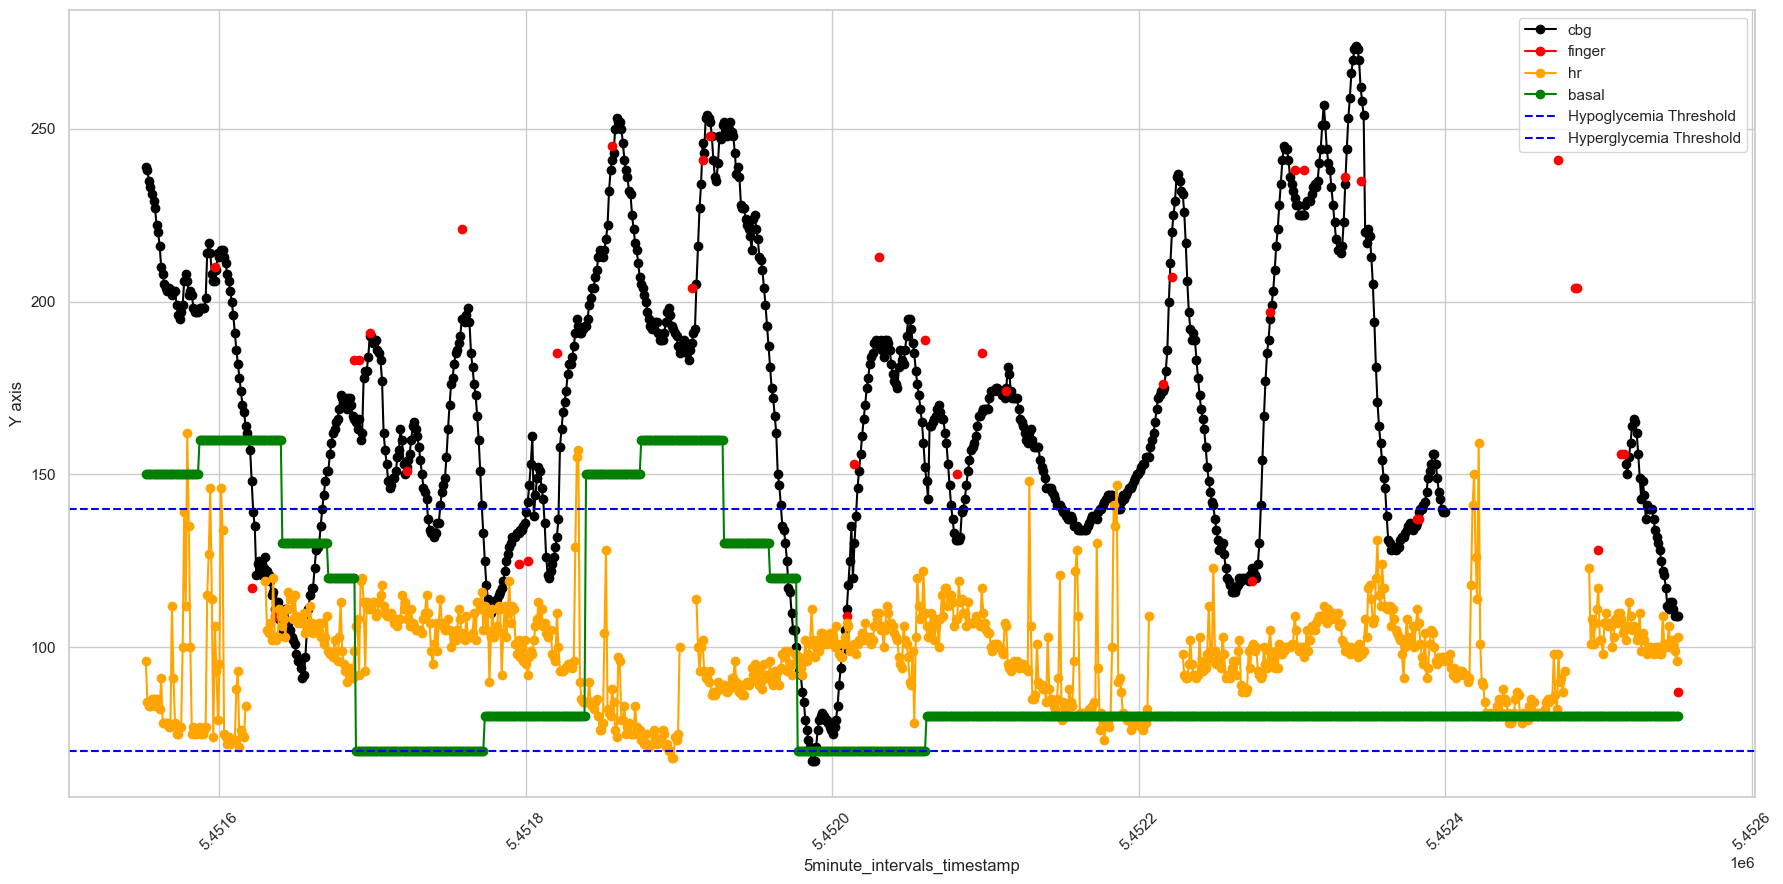

Patient:  570-ws-testing_processed.csv


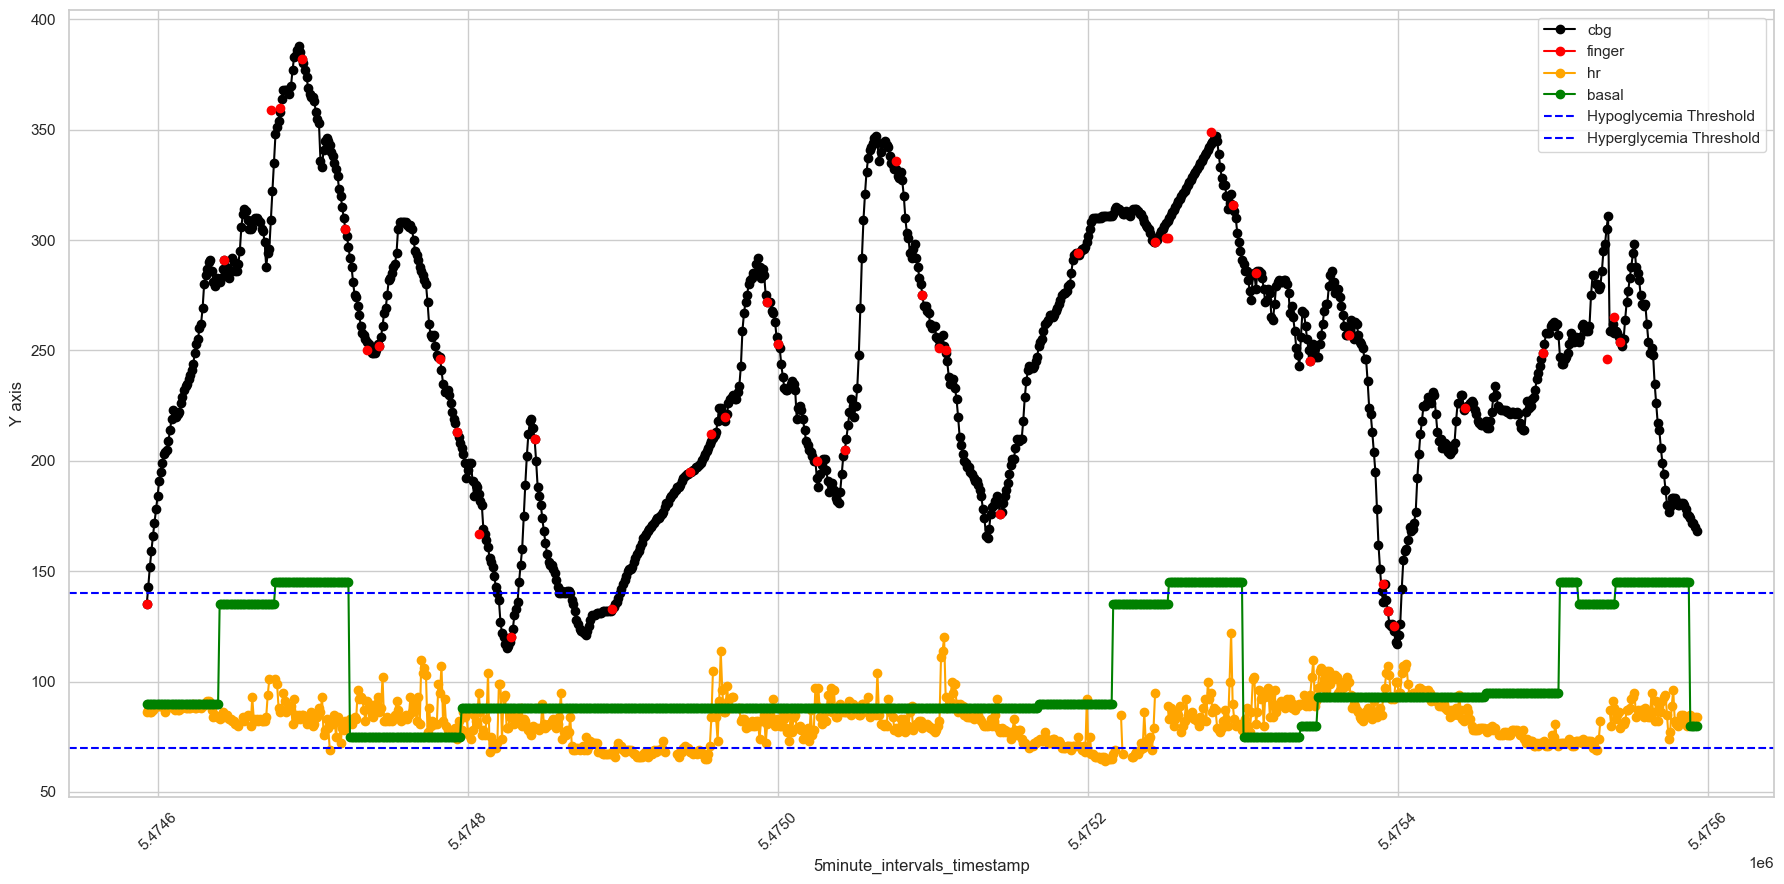

Patient:  575-ws-testing_processed.csv


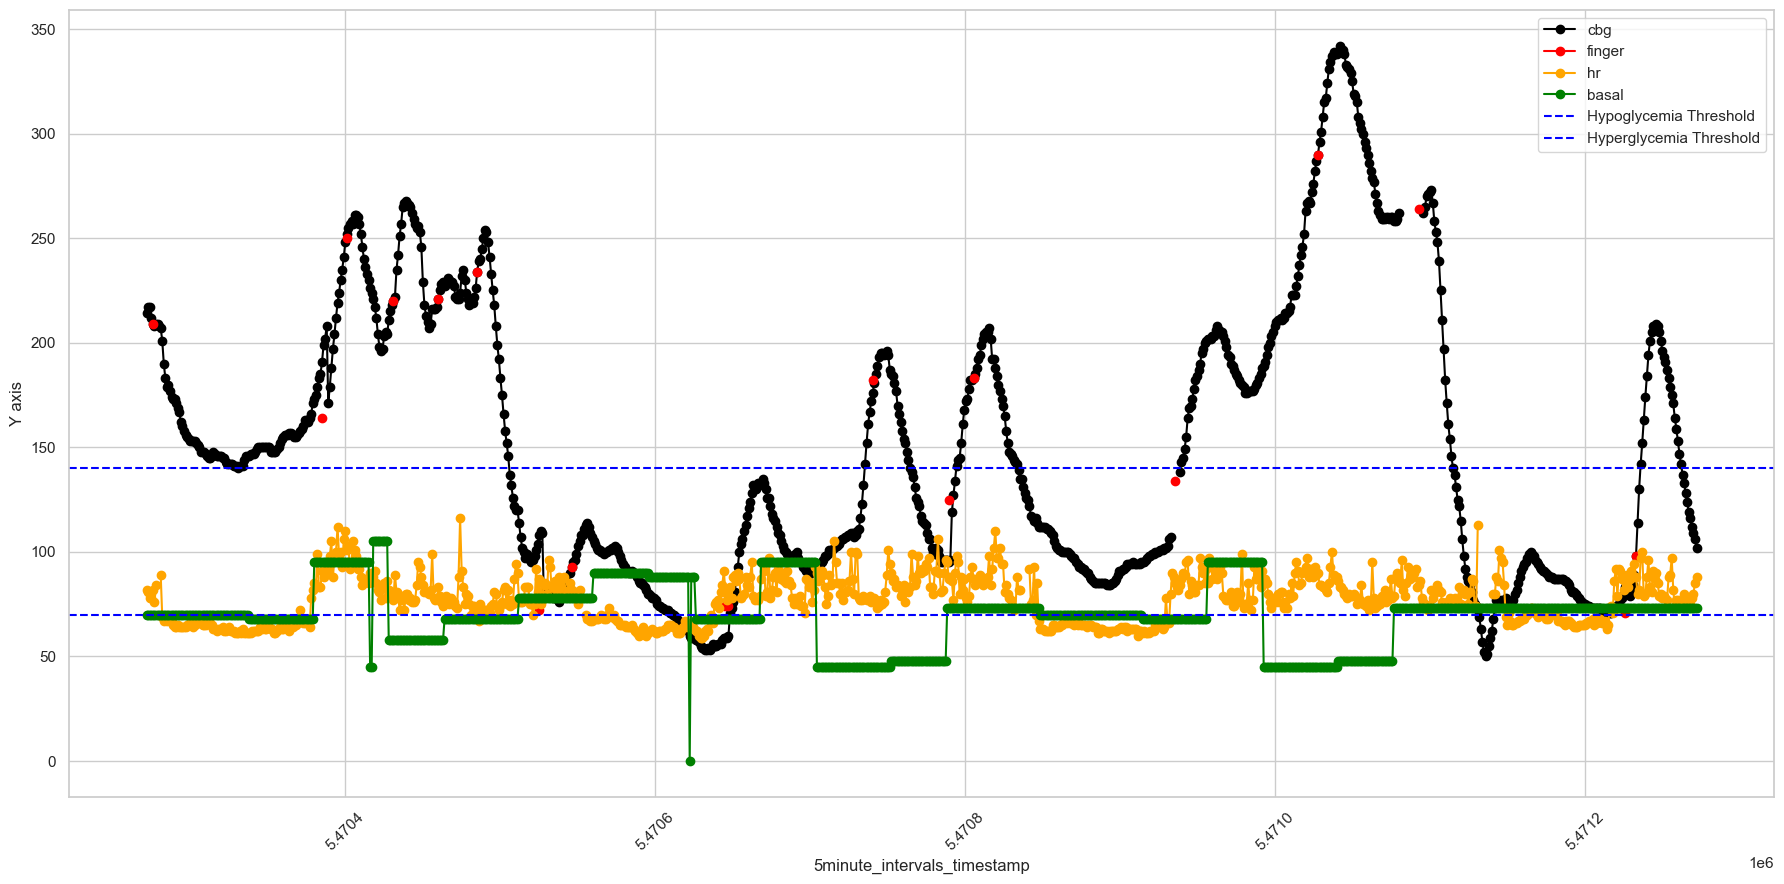

Patient:  588-ws-testing_processed.csv


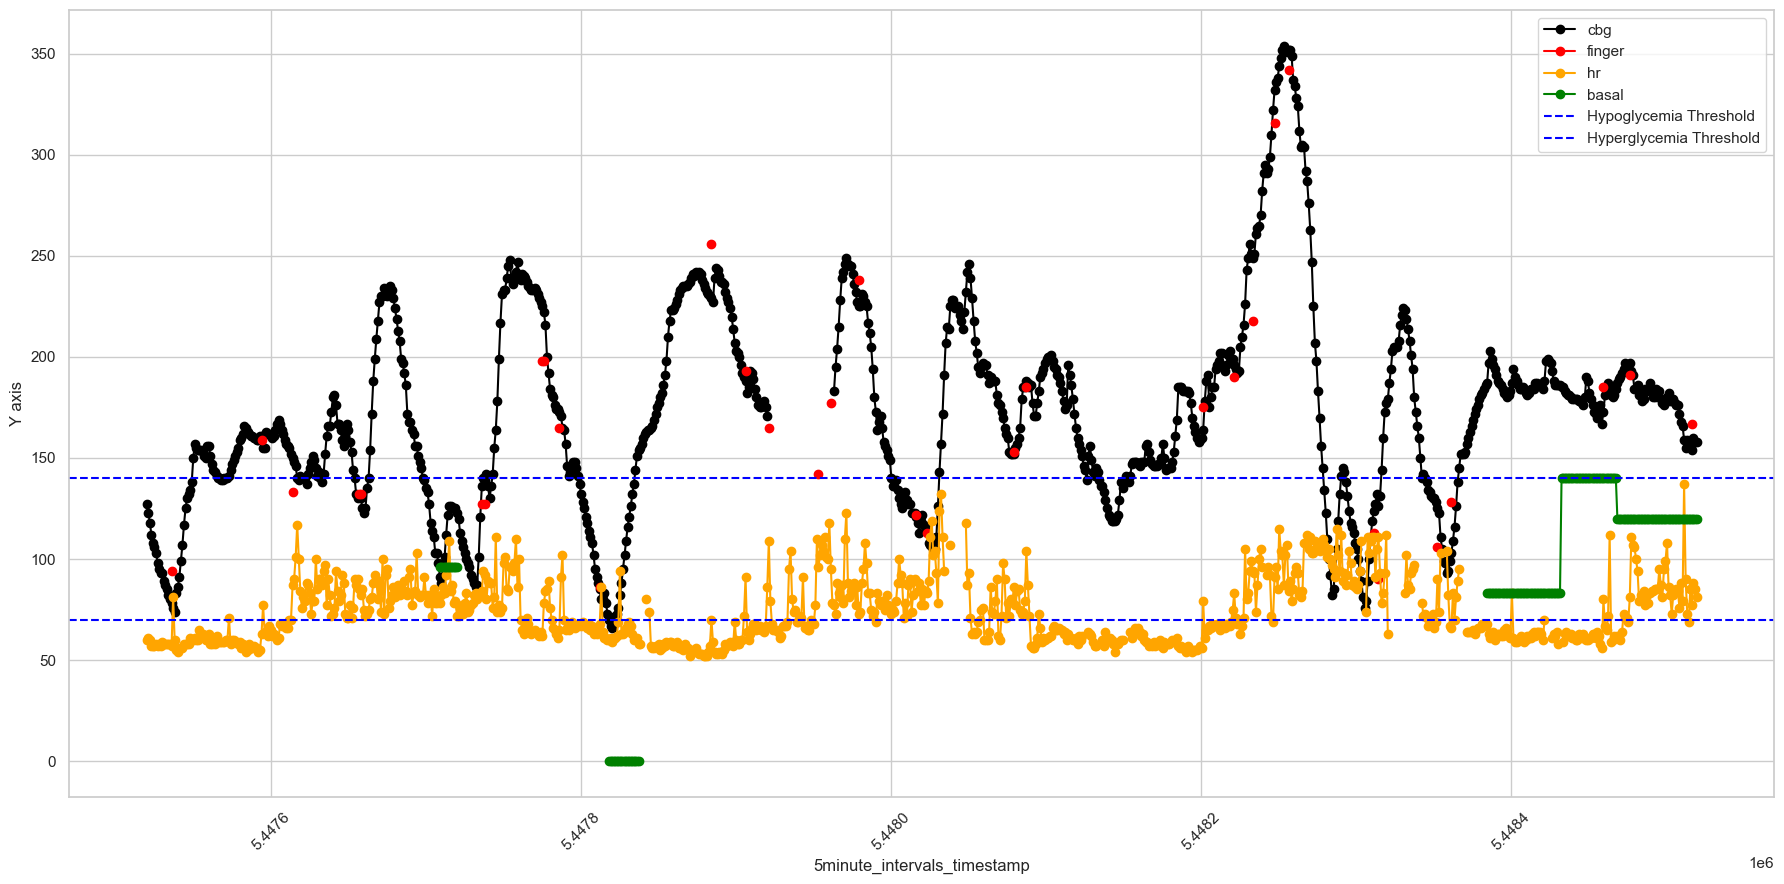

Patient:  591-ws-testing_processed.csv


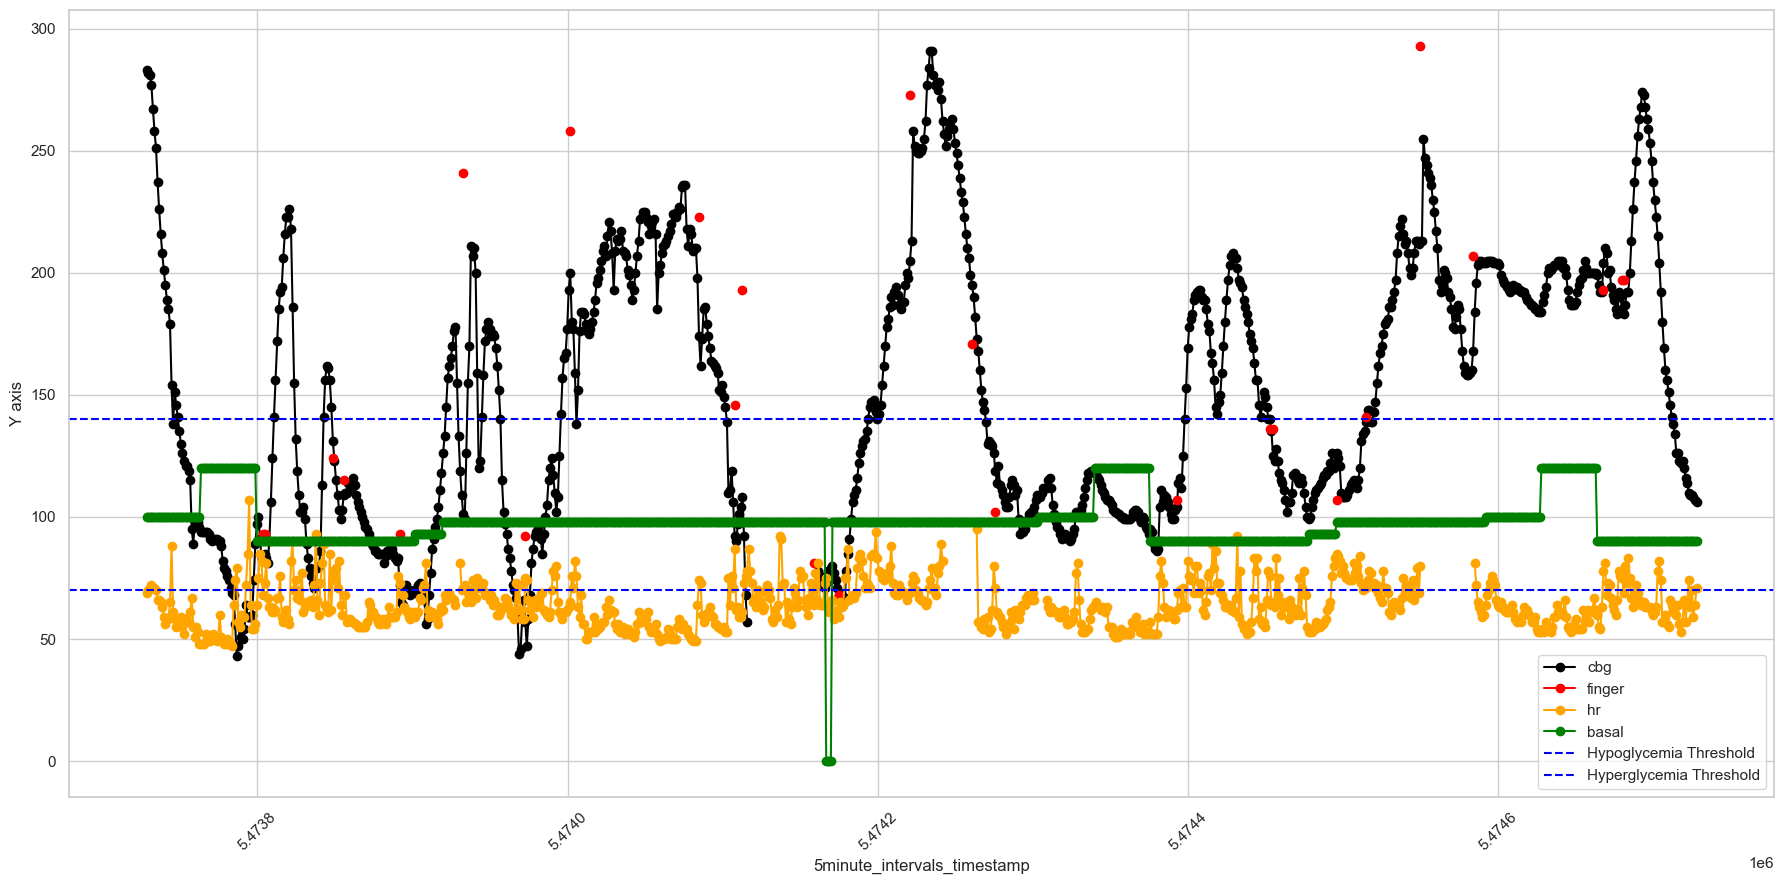

Data: train_set_2020
Patient:  540-ws-training_processed.csv


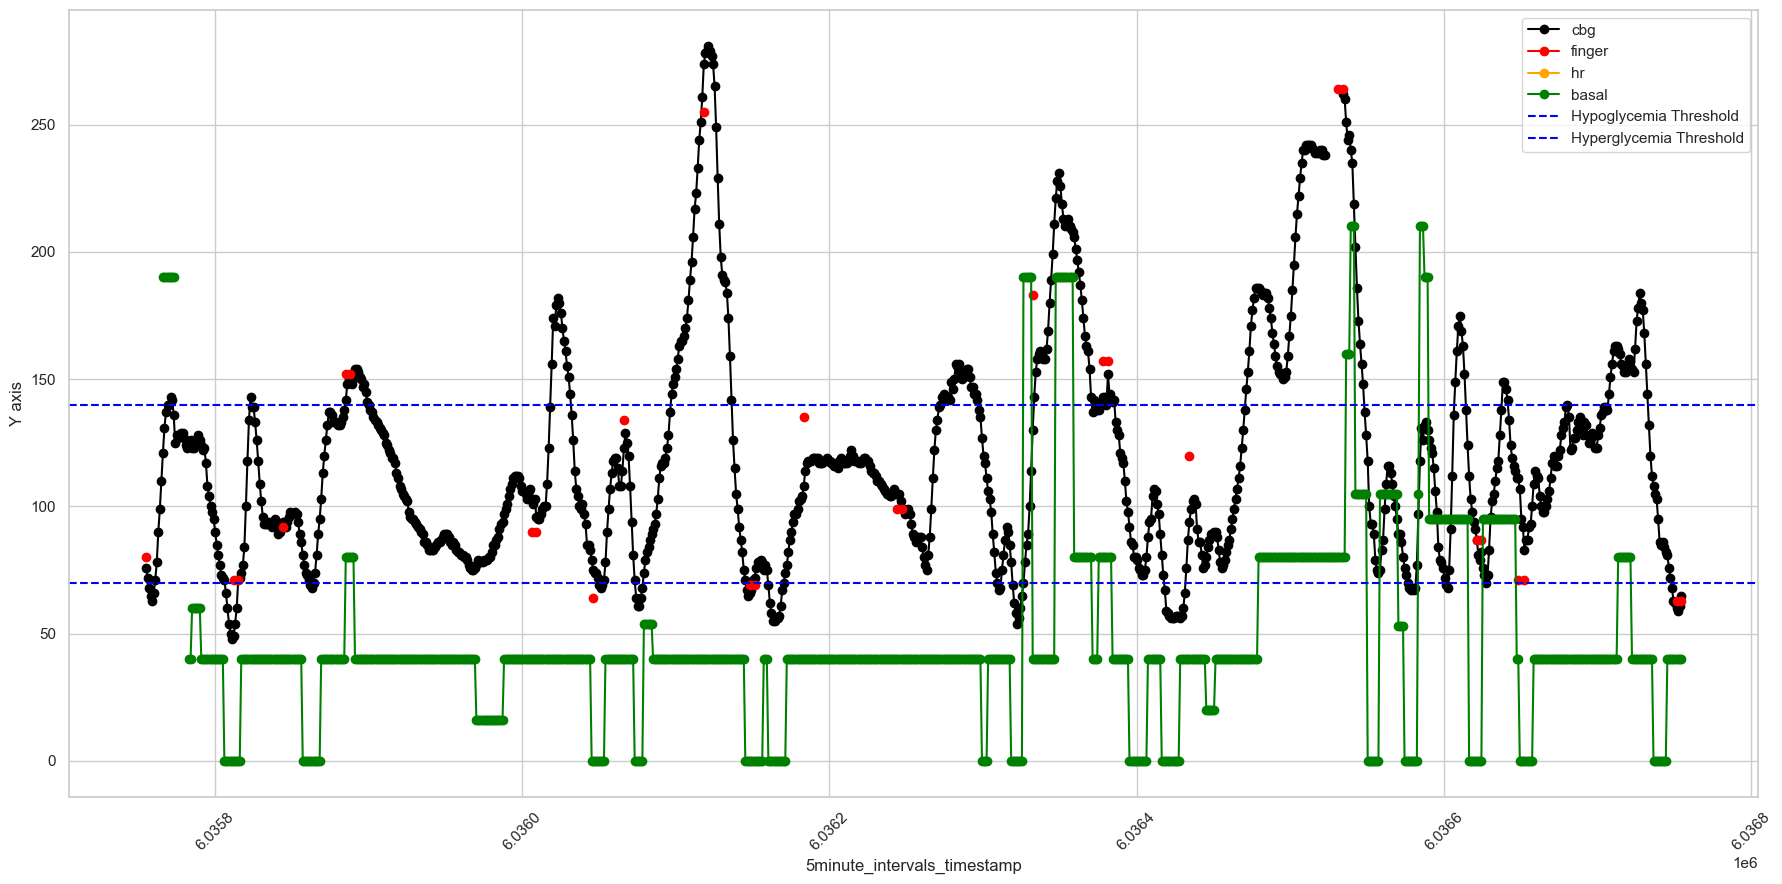

Patient:  544-ws-training_processed.csv


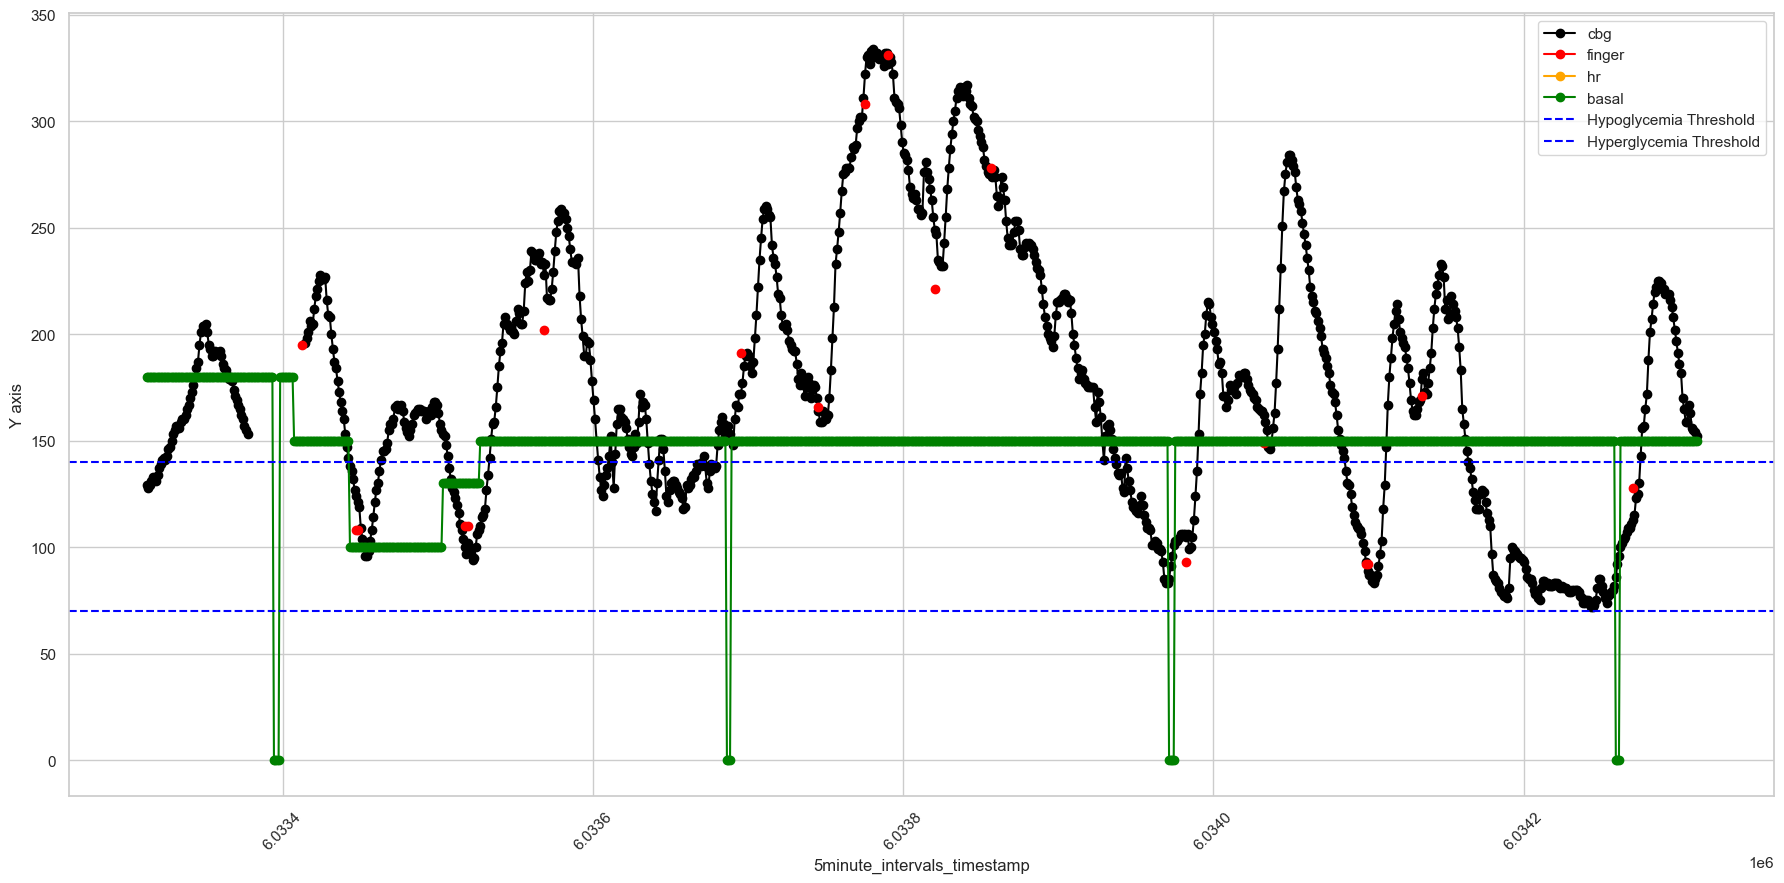

Patient:  552-ws-training_processed.csv


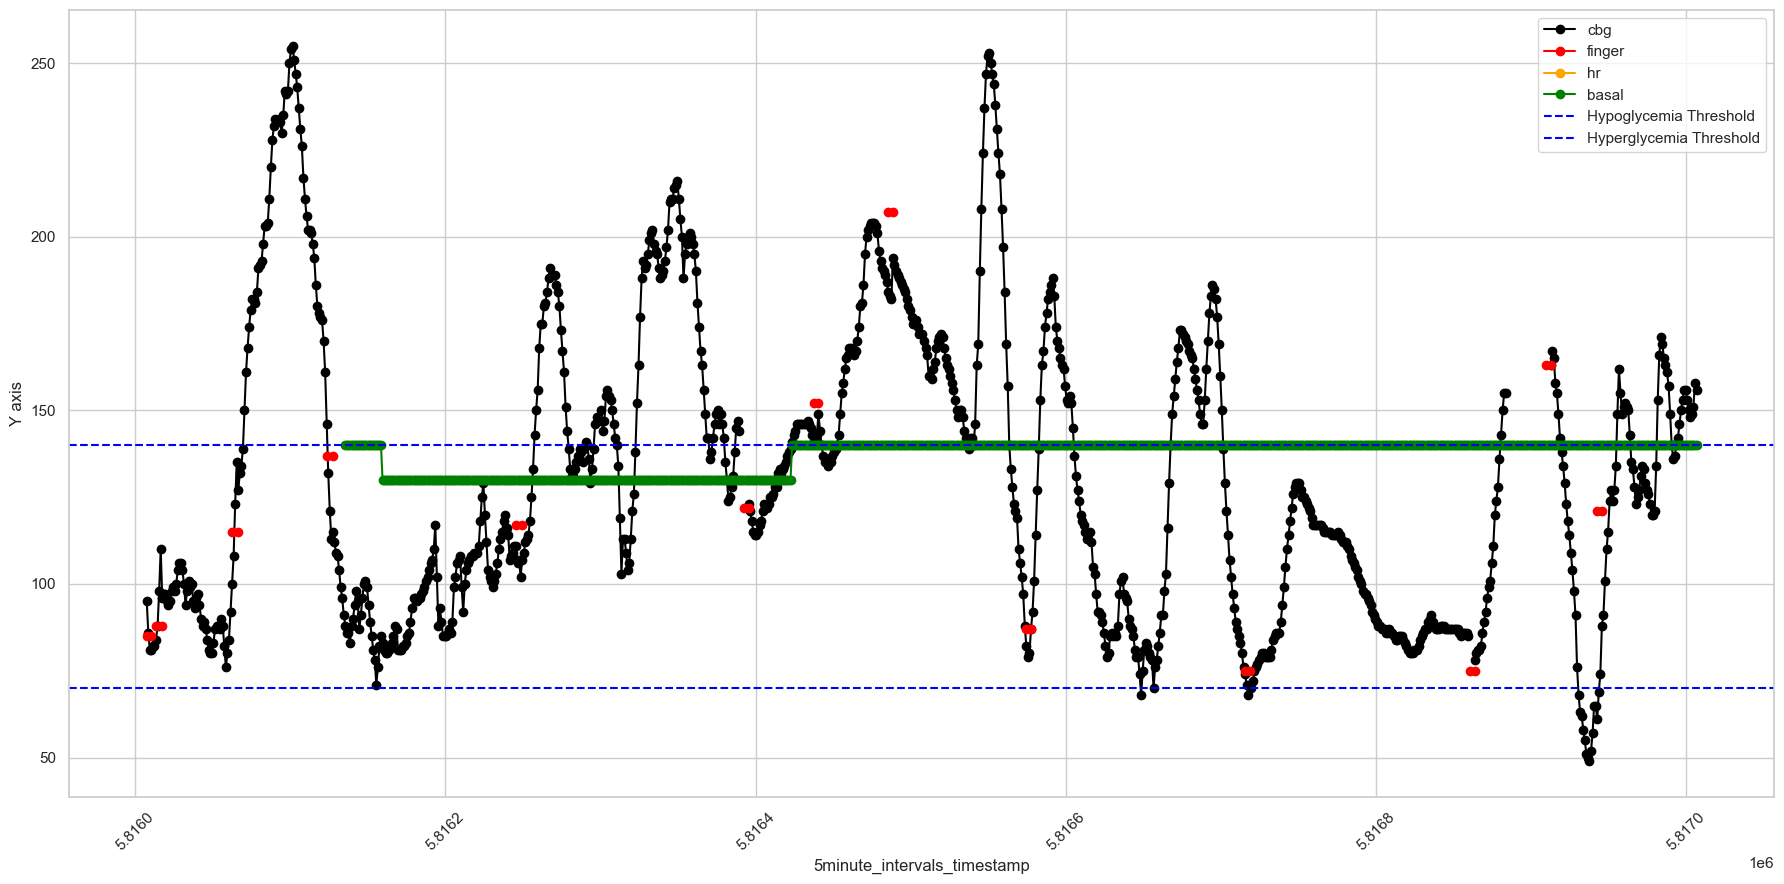

Patient:  567-ws-training_processed.csv


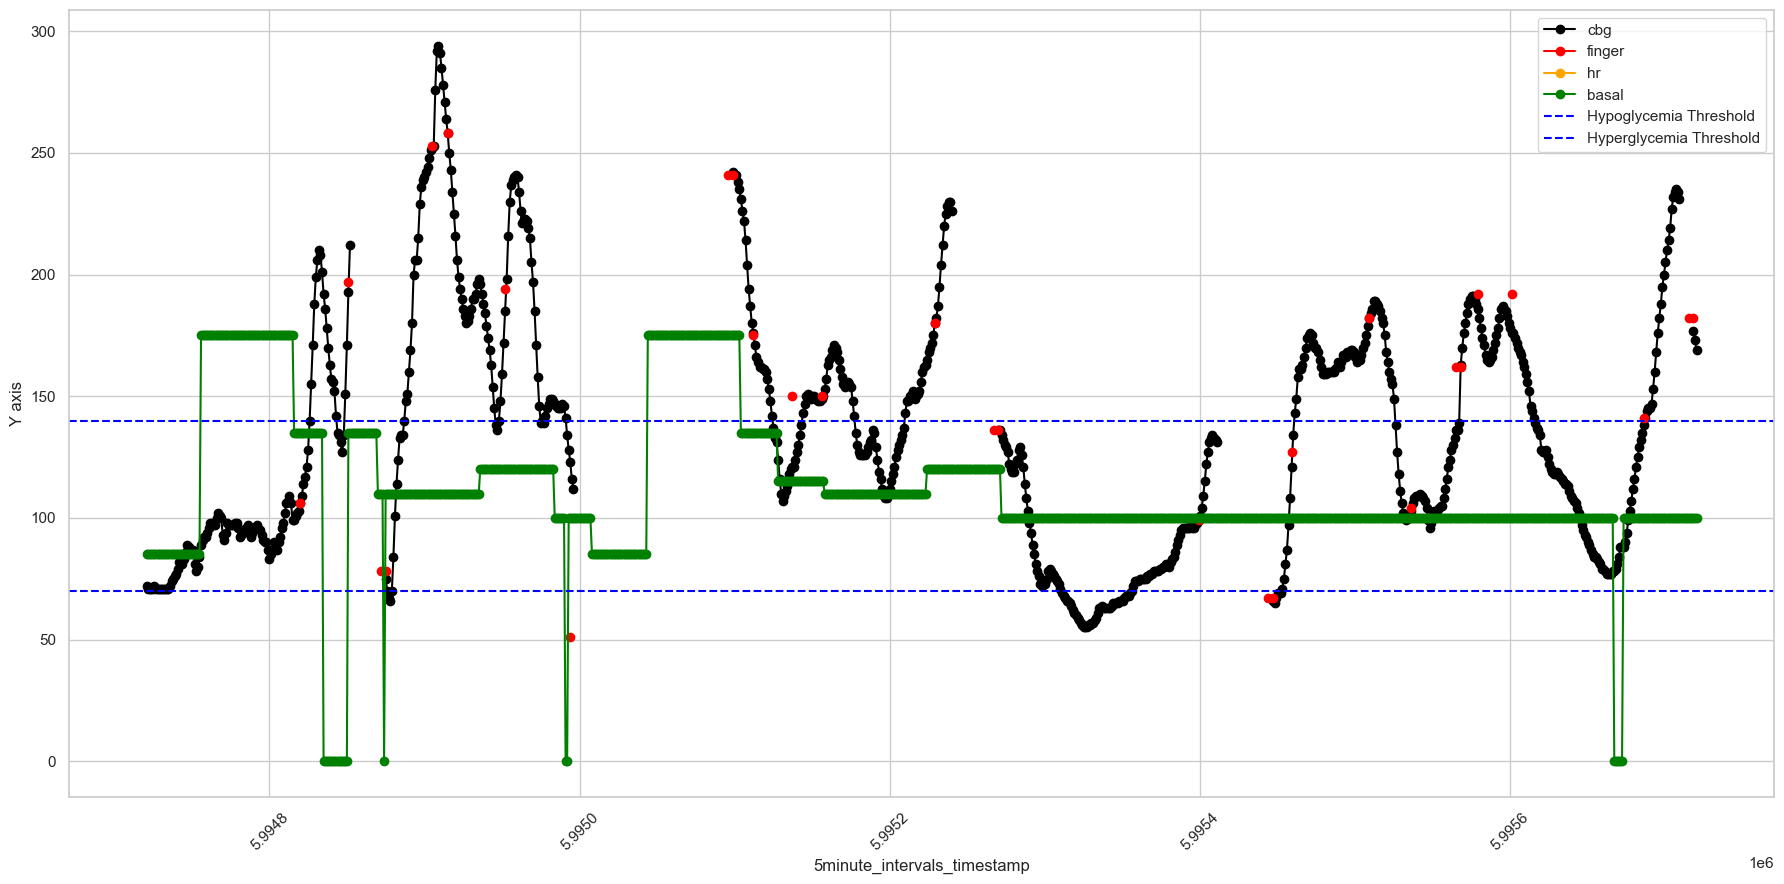

Patient:  584-ws-training_processed.csv


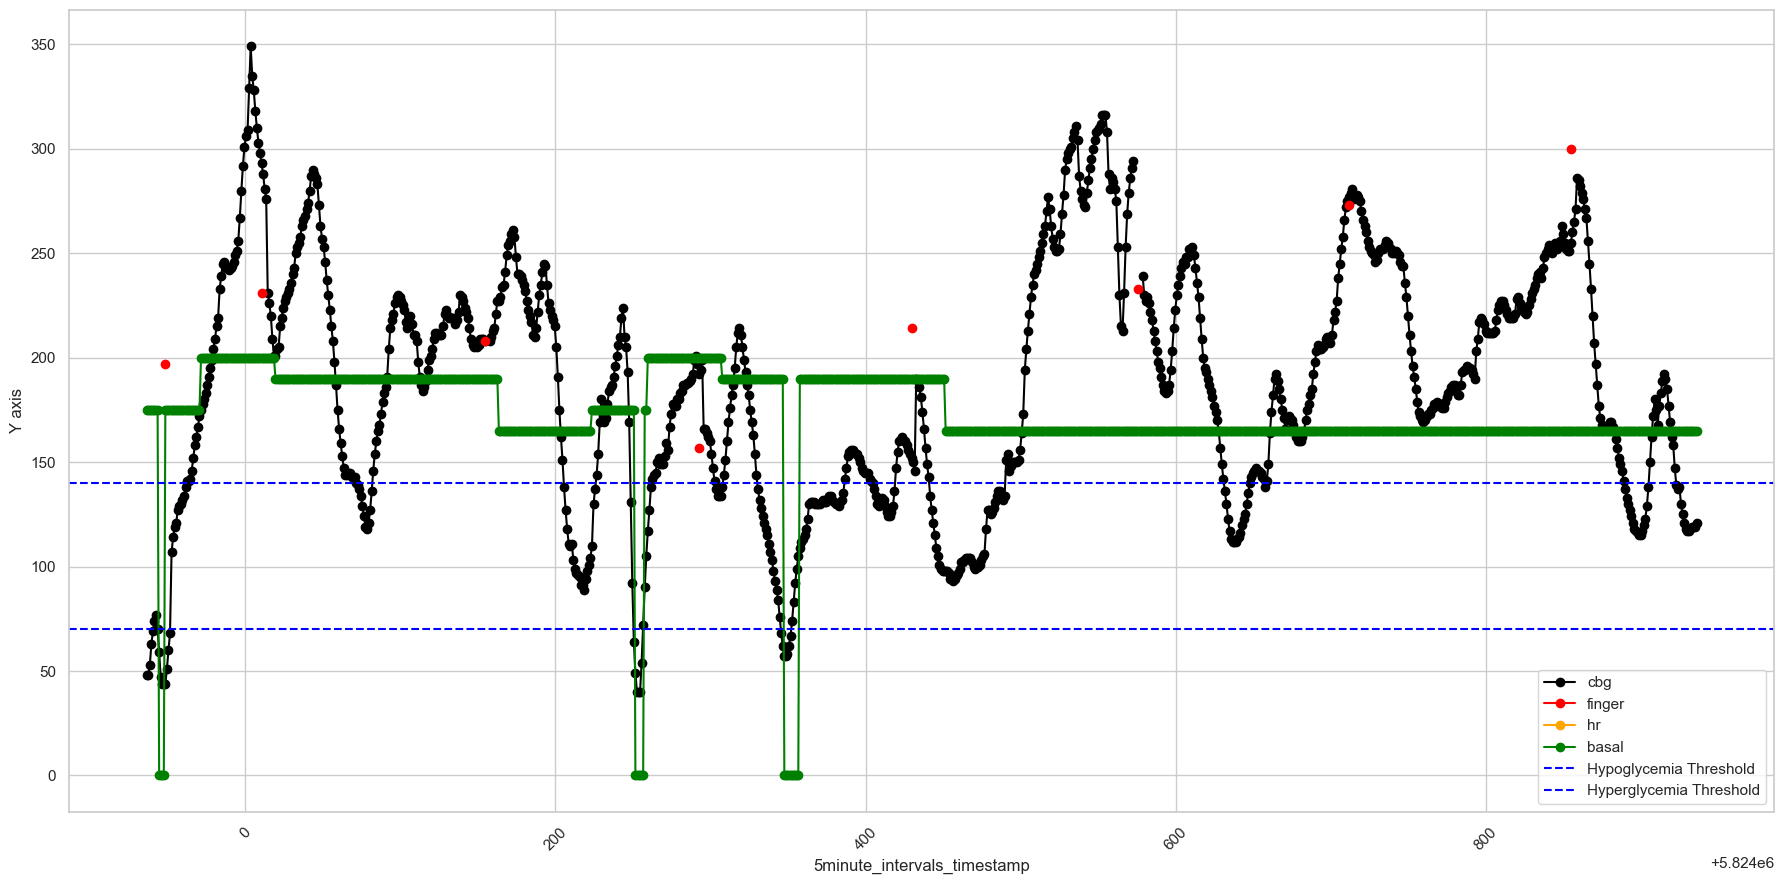

Patient:  596-ws-training_processed.csv


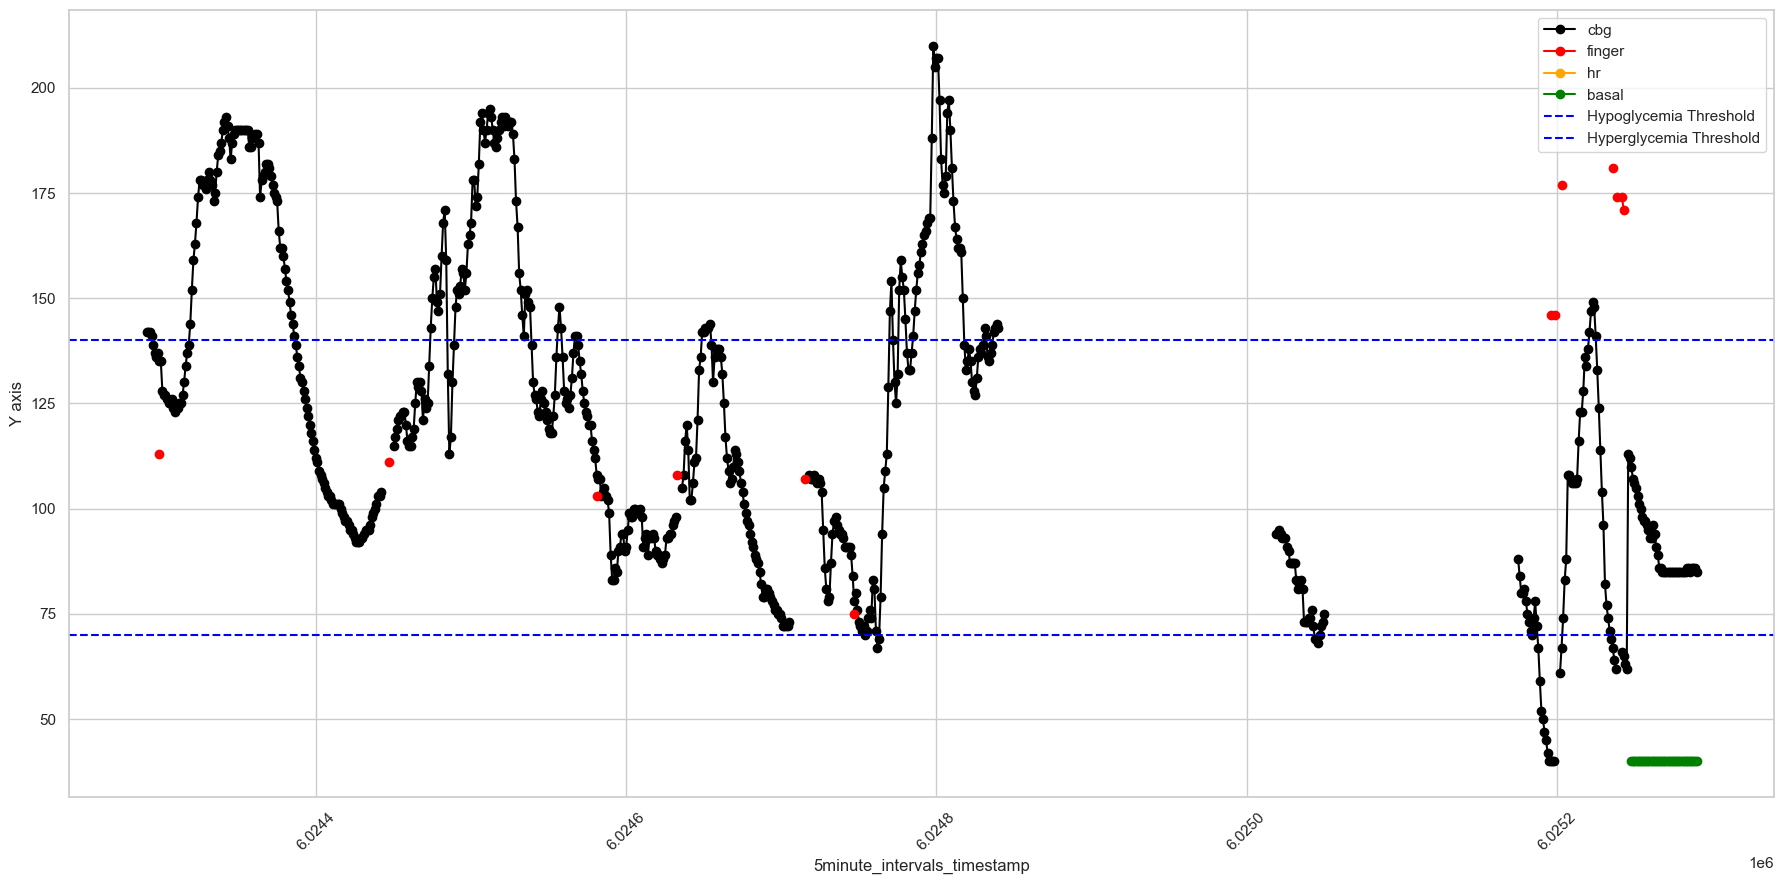

Data: test_set_2020
Patient:  540-ws-testing_processed.csv


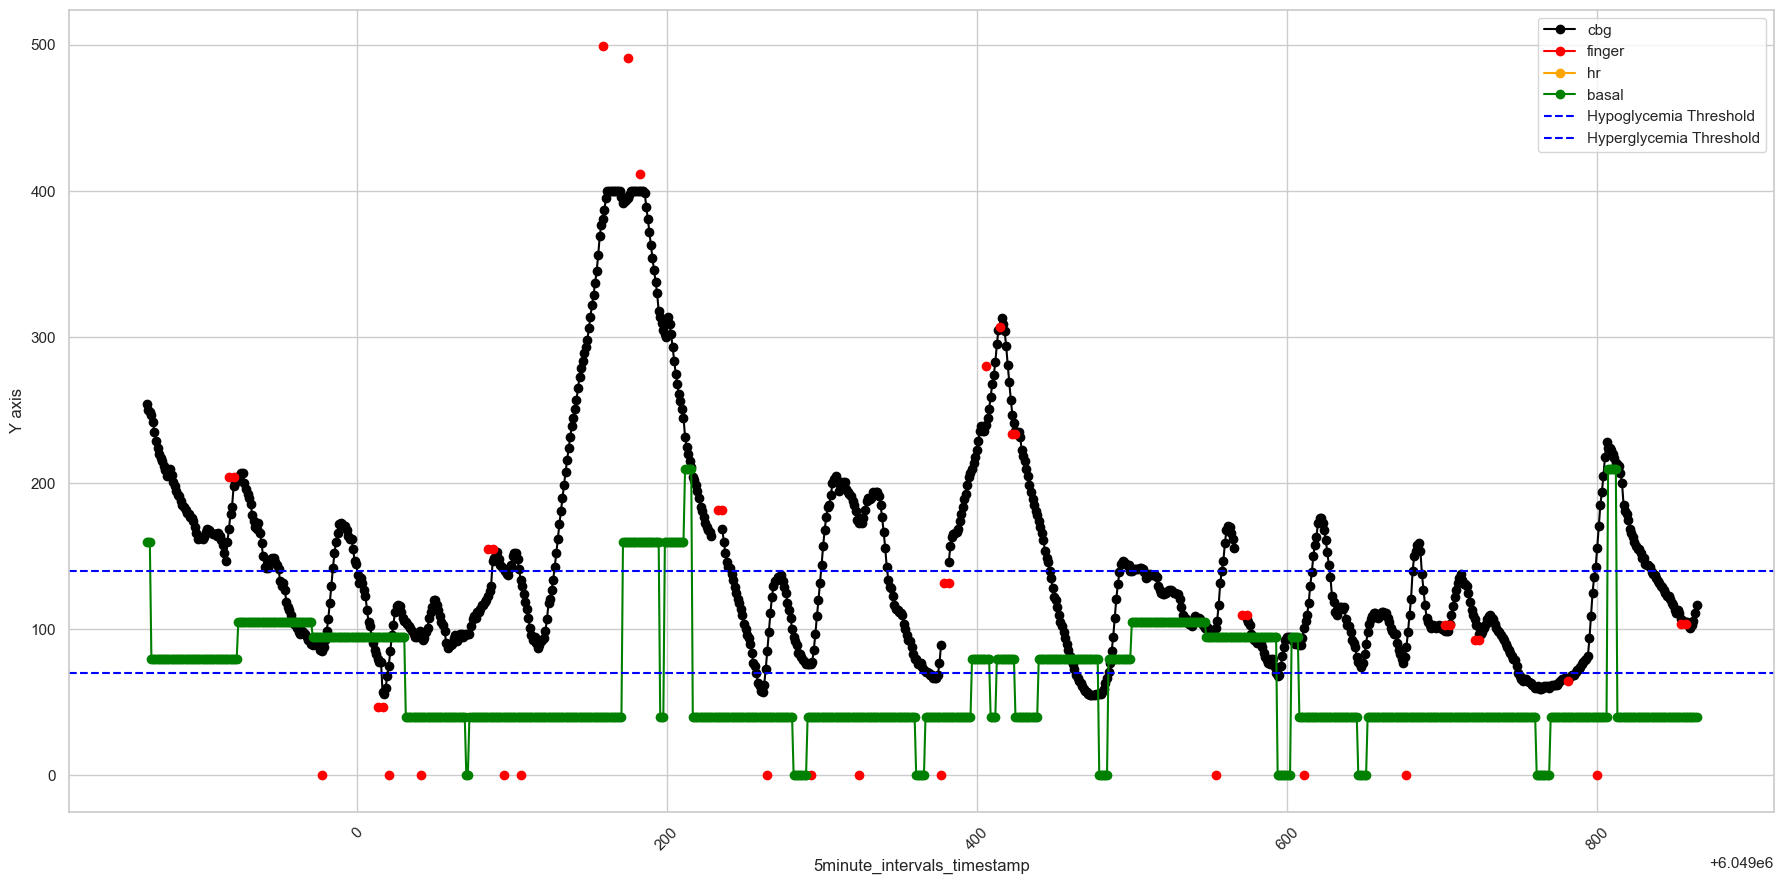

Patient:  544-ws-testing_processed.csv


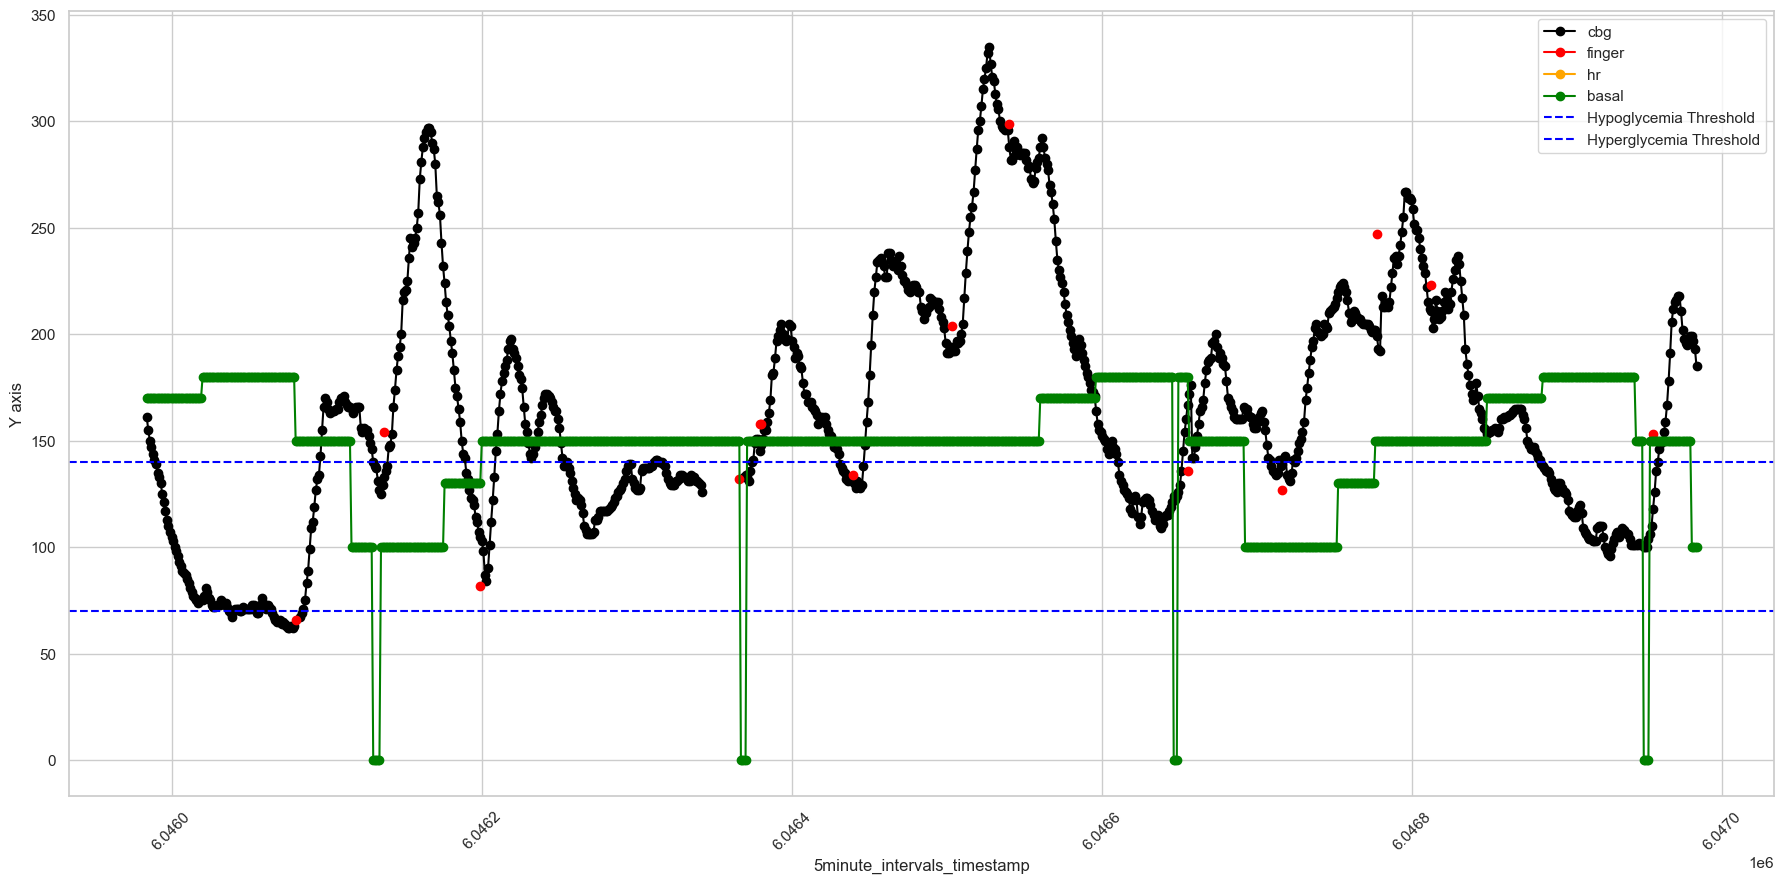

Patient:  552-ws-testing_processed.csv


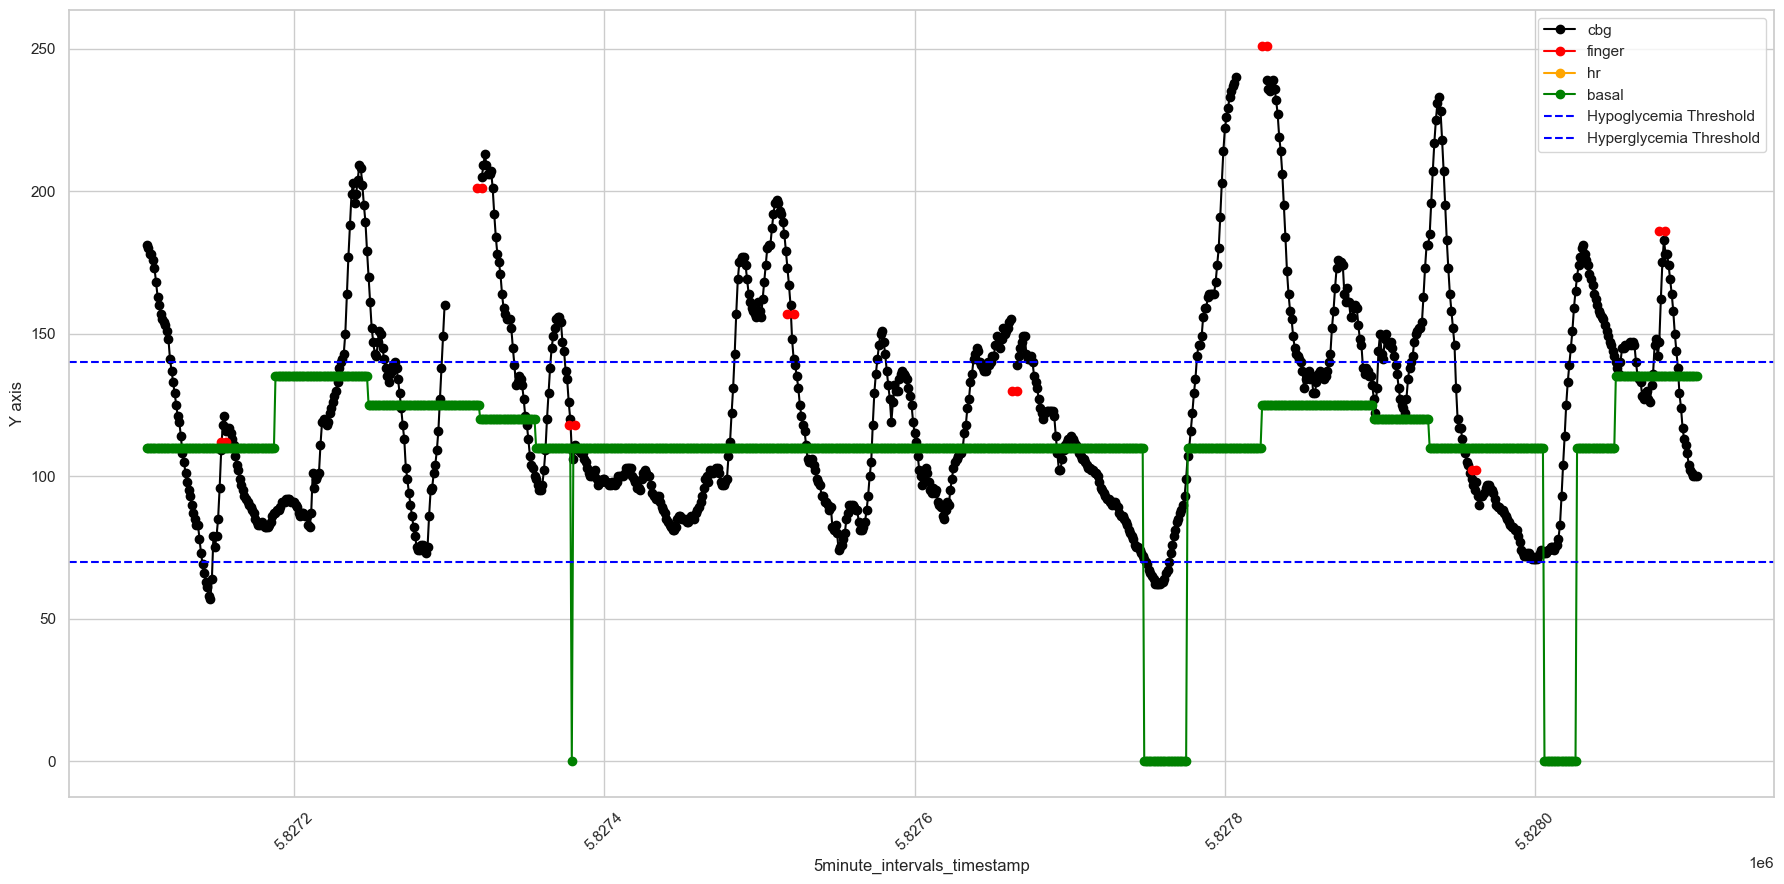

Patient:  567-ws-testing_processed.csv


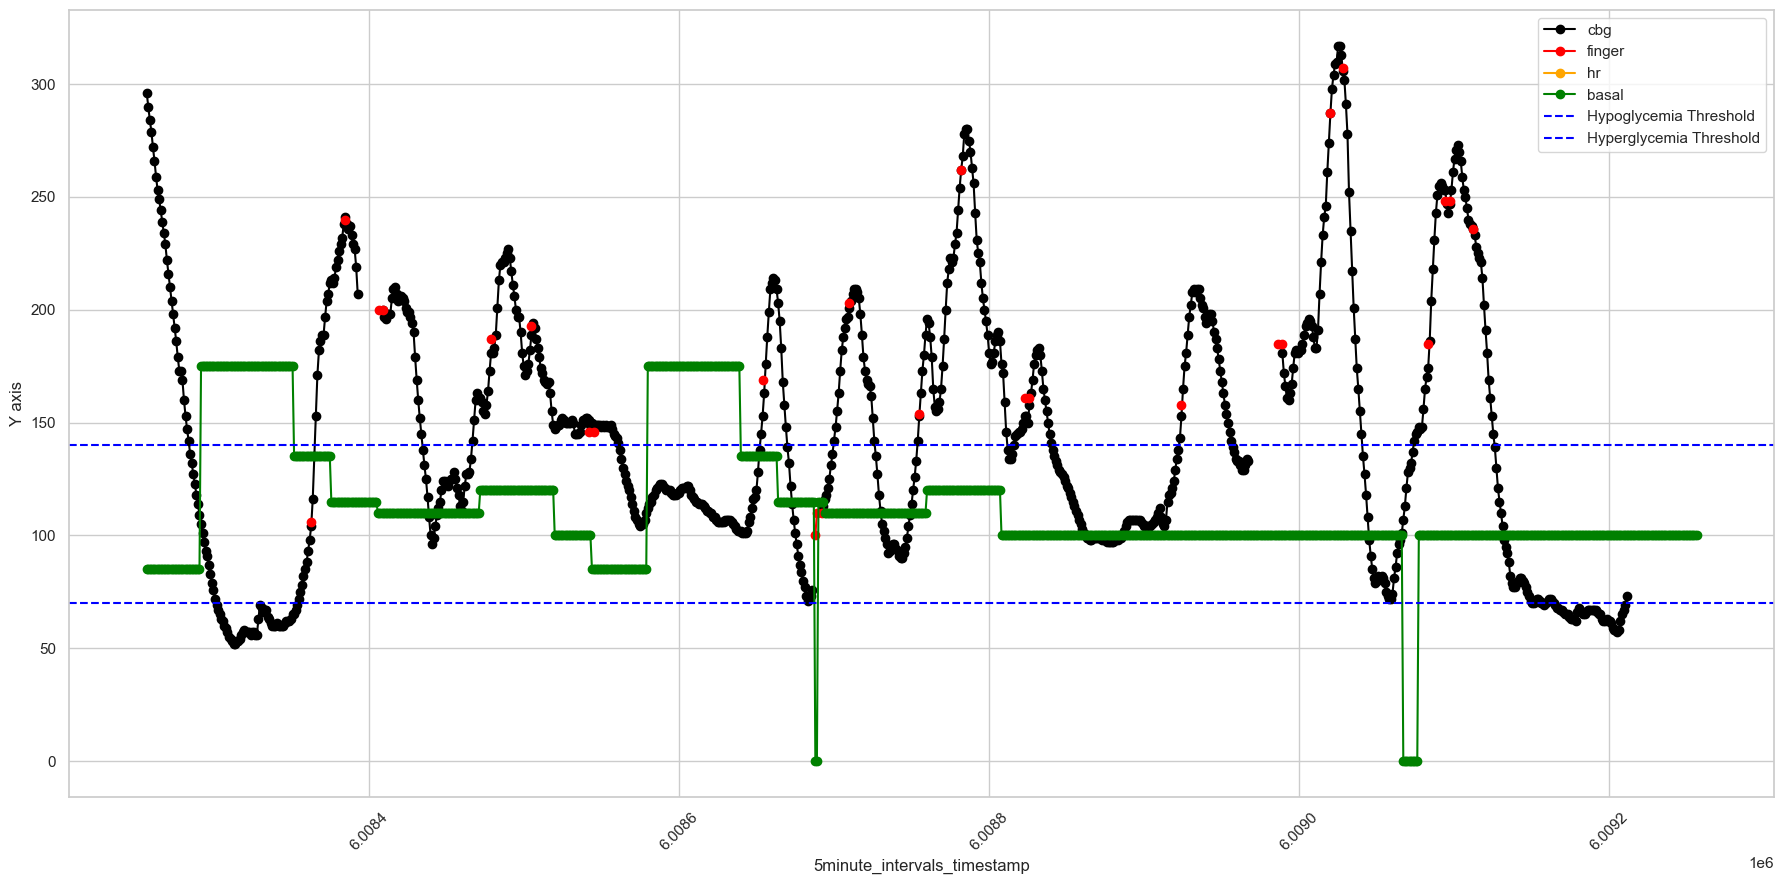

Patient:  584-ws-testing_processed.csv


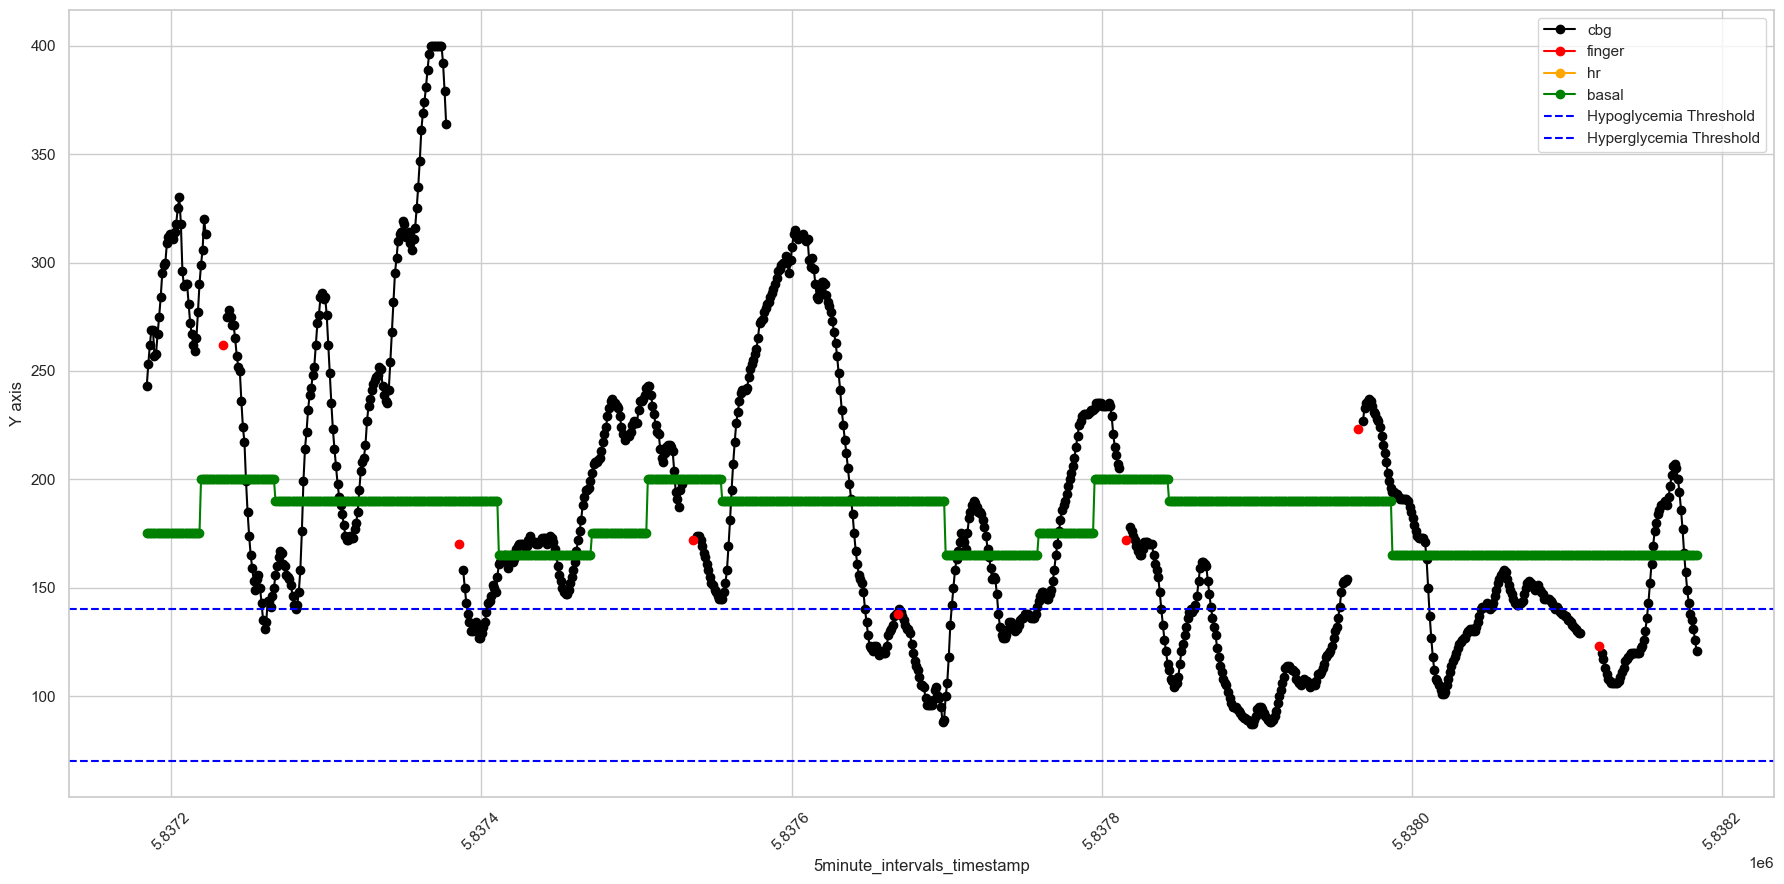

Patient:  596-ws-testing_processed.csv


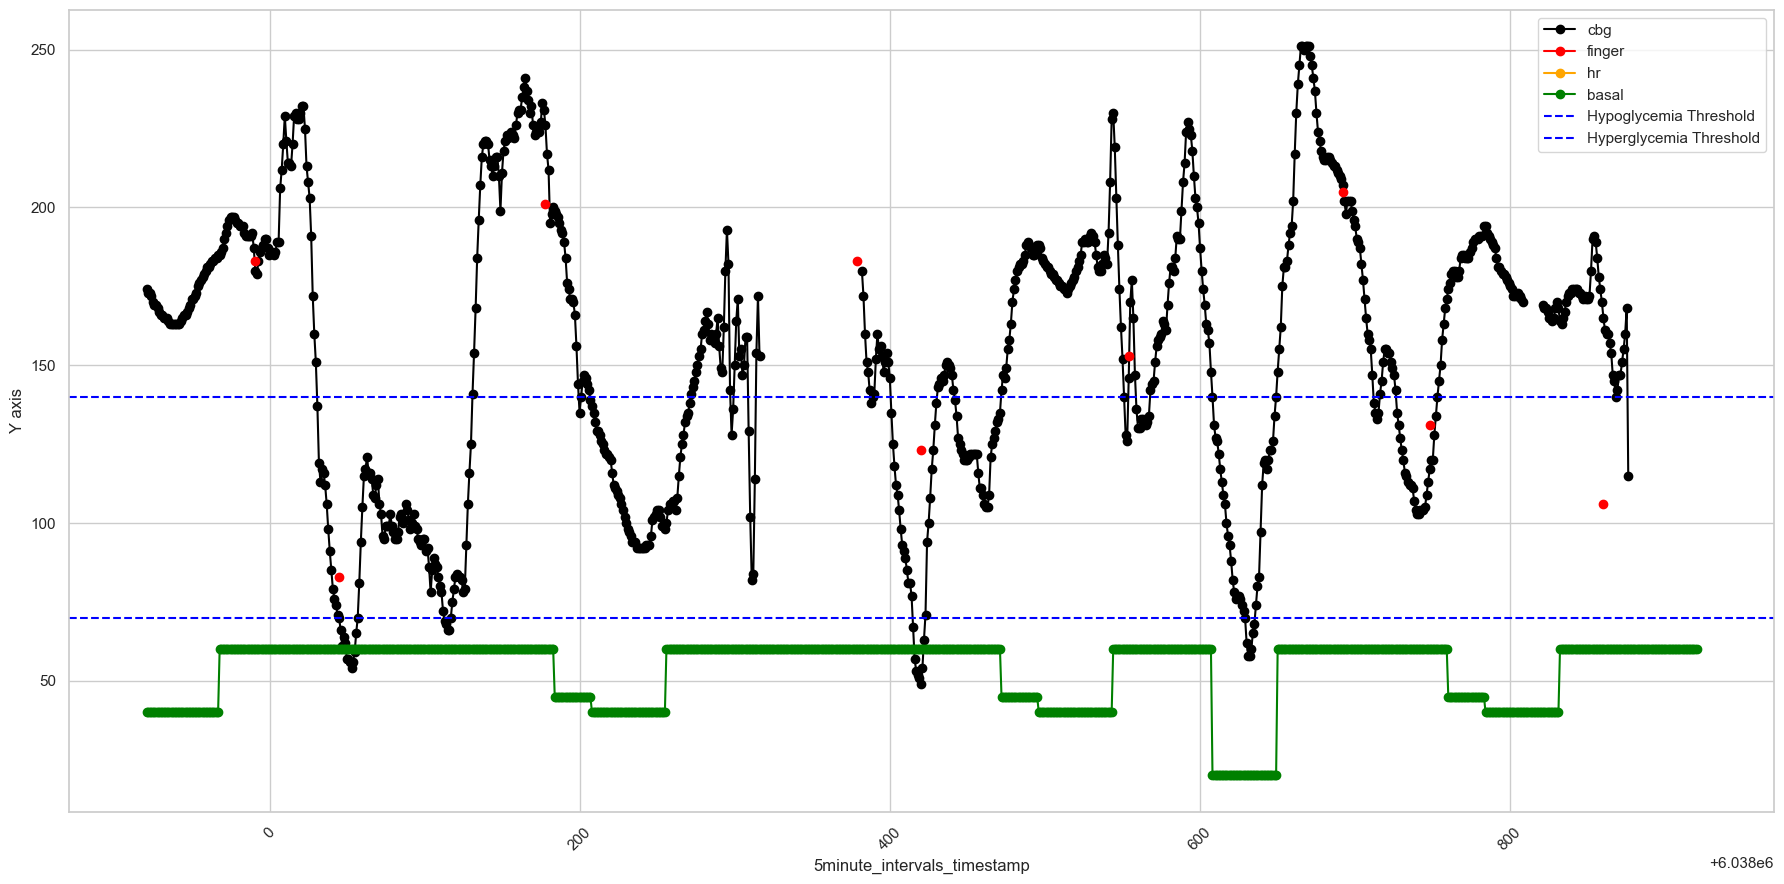

In [54]:
# Displaying all 24 plots:

# Create a dictionary
data_dict = {
    'train_set_2018': train_set_2018,
    'test_set_2018': test_set_2018,
    'train_set_2020': train_set_2020,
    'test_set_2020': test_set_2020,
}

for name, data in data_dict.items():
    print(f"Data: {name}")
    for index, value in enumerate(data):
        
        # not super pretty but it works:
        if name == 'train_set_2018':
            print("Patient: ", names_train_2018[index])
        elif name == 'test_set_2018':
            print("Patient: ", names_test_2018[index])
        elif name == 'train_set_2020':
            print("Patient: ", names_train_2020[index])
        else:
            print("Patient: ", names_test_2020[index])
                
        # Actual ploting of each of the 24 plots
        filtered_df = data[index].head(1000)

        # Plot lines
        plt.figure(figsize=(18, 9))
        plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['cbg'], marker='o', linestyle='-', color='black', label='cbg')
        plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['finger'], marker='o', linestyle='-', color='red', label='finger')
        plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['hr'], marker='o', linestyle='-', color='orange', label='hr')
        
        #TODO ADD bolus data to plot 
        
        # I multipled the basal by 100 just so its easier to see in plot
        plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['basal']*100, marker='o', linestyle='-', color='green', label='basal')
        
        # Variables that we can still plot and see what happens etc. -> hr, gsr, carbInput, bolus
        # What I think they mean: hr>heart rate, gsr>Galvanic skin response, carbInput -> carb in grams?, 
        # bolus> Insulin delivered to the patient, typically before a meal or when the patient is hyperglycemic.
        
        # Horizontal line representing for hyper- and hypoglycemia, maybe it helps us see 
        hypoglycemia_threshold = 70  # Not 100% sure about the value 
        plt.axhline(y=hypoglycemia_threshold, color='blue', linestyle='--', label='Hypoglycemia Threshold')
        hyperglycemia_threshold = 140 # Not 100% sure about the value 
        plt.axhline(y=hyperglycemia_threshold, color='blue', linestyle='--', label='Hyperglycemia Threshold')
        
        plt.xlabel('5minute_intervals_timestamp')
        plt.ylabel('Y axis')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Plot artificial SMBG

In [61]:
# ONLY FOR COMPARISON
def read_patient(train_set, test_set, finger_window=1, prediction_window=80): 

    train_set = preprocess_data(train_set)
    test_set = preprocess_data(test_set)
    
    # Use cbg, smbg, bolus, carbInput and the other stuff as inputs
    features = ['cbg', 'finger', 'basal', 'hr', 'gsr', 'carbInput', 'bolus'] 
    train_set = train_set[features].values
    test_set = test_set[features].values

    # Scalling data from 0 - 1 for each individual feature, considering NaN to be unchanged 
    scaled_train_set = np.zeros((train_set.shape[0], train_set.shape[1]))
    scaled_test_set = np.zeros((test_set.shape[0], test_set.shape[1]))


    smbg_scatter = test_set[:, 1]

    return x_train, y_train, x_test, y_test, continuous_ytest, scalers_transforms_train, scalers_transforms_test, smbg_scatter

In [17]:
def preprocess_data(data):
    # Replace any 0 values in 'finger' with corresponding values from 'cbg'
    data.loc[data['finger'] == 0, 'finger'] = data.loc[data['finger'] == 0, 'cbg'] 

    data['finger'][::50] =  data['cbg'][::50] 
    
    # Periods of no food or bolus injected
    data['bolus'].fillna(0.0, inplace=True)
    data['carbInput'].fillna(0.0, inplace=True)
    
    # Interpolate the zones with missing 'cbg' so there is not regions with super steep changes 
    # TODO: Only do interpolation when missing_cbg is small 
    # TODO: After doing interpolation, set the missing_cbg of the interpolated to 0
    data['cbg'] = data['cbg'].interpolate(method='linear', limit_direction='both')
    
    # BASAL, do we do anything there? there is periods with 0.0 and NaN???
    #  Basal is the rate at which basal insulin is continuously infused. If it NaN it should be 0 then no?
    
    return data 

In [18]:
def preprocess_data_new(data):
    # Replace any 0 values in 'finger' with corresponding values from 'cbg'
    data.loc[data['finger'] == 0, 'finger'] = data.loc[data['finger'] == 0, 'cbg'] 

    # Interpolate the zones with missing 'cbg' so there is not regions with super steep changes 
    # TODO: Only do interpolation when missing_cbg is small 
    # TODO: After doing interpolation, set the missing_cbg of the interpolated to 0
    data['cbg'] = data['cbg'].interpolate(method='linear', limit_direction='both')
    #data['cbg'] = data['cbg'].interpolate(method='spline', order=3, limit_direction='both')

    #data['finger'][::50] =  data['cbg'][::50] 
    data, artificial_SMBG_indices = add_artificial_SMBG(data,4); 
    
    # Periods of no food or bolus injected
    data['bolus'].fillna(0.0, inplace=True)
    data['carbInput'].fillna(0.0, inplace=True)

    
    # BASAL, do we do anything there? there is periods with 0.0 and NaN???
    #  Basal is the rate at which basal insulin is continuously infused. If it NaN it should be 0 then no?
    
    return data, artificial_SMBG_indices

In [29]:
def add_artificial_SMBG(data, time_between_two_SMBGs_in_h):
    time_step_distance = round(time_between_two_SMBGs_in_h*12) # hours * 60min/hour / 5min/step  
    artificial_SMBG_indices = []
    #SMBG_values = data['finger'][data['finger'].notna()]
    SMBG_indices = data['finger'][data['finger'].notna()].index
    print("SMBG_indices: " +str(SMBG_indices.shape))
    for i in range(len(SMBG_indices)): 
        print("i: "+str(i))
        if i == 0: 
            distance = SMBG_indices[i]
        elif i == len(SMBG_indices)-1: 
            distance = data['cbg'].index[-1] - SMBG_indices[i]
        else:
            distance = SMBG_indices[i+1]-SMBG_indices[i]
        print("Distance: "+str(distance))    
        if distance > time_step_distance:
            num_artificial_points = math.ceil(distance/time_step_distance)-1# twice the distance --> add one artificial point 
            if num_artificial_points > 0 : 
                for j in range(num_artificial_points):
                    if i == 0:
                        artificial_index = time_step_distance*(j+1)
                    elif i == len(SMBG_indices)-1:
                        artificial_index = SMBG_indices[i]+time_step_distance*(j+1)
                        if artificial_index > data['cbg'].index[-1]:
                            break;
                    else:
                        artificial_index = SMBG_indices[i]+time_step_distance*(j+1)
                    print("AI-index: " +str(artificial_index))
                    data['finger'].iloc[artificial_index] = data['cbg'].iloc[artificial_index]
                    artificial_SMBG_indices.append(artificial_index)

    return data, artificial_SMBG_indices
            

In [42]:
index_patient_570 = 4
train_set = train_set_2018[index_patient_570]
test_set = test_set_2018[index_patient_570]
print(test_set.shape)
#x_train, y_train, x_test, y_test, continuous_ytest, scalers_transforms_train, scalers_transforms_test, smbg_scatter = read_patient(all_train_2018, test_set)


(2880, 9)


In [22]:
train_set['finger'].index[-1]

11610

In [21]:
train_set['cbg'].index[-1]

11610

In [47]:
test_set['cbg']

0       127.0
1       123.0
2       118.0
3       112.0
4       108.0
        ...  
2875    305.0
2876    304.0
2877    307.0
2878    311.0
2879    321.0
Name: cbg, Length: 2880, dtype: float64

In [24]:
train_set['cbg']

0        101.0
1        100.0
2        100.0
3         99.0
4         98.0
         ...  
11606    113.0
11607    118.0
11608    120.0
11609    123.0
11610    128.0
Name: cbg, Length: 11611, dtype: float64

In [25]:
test_set['finger'][test_set['finger'].notna()]

80      359.0
86      360.0
128     305.0
142     250.0
189     246.0
        ...  
2665    271.0
2690    281.0
2695    270.0
2800    155.0
2812    165.0
Name: finger, Length: 65, dtype: float64

In [26]:
all_train_2018['finger'][all_train_2018['finger'].notna()]

46       191.0
120      586.0
133      439.0
145      263.0
187       71.0
         ...  
75605     83.0
75606     83.0
75675    168.0
75676    168.0
75746    325.0
Name: finger, Length: 2162, dtype: float64

In [30]:
all_train_2018

5minute_intervals_timestamp  missing_cbg    cbg  finger  basal    hr  \
0                     5.462799e+06          0.0  101.0     NaN    NaN   NaN   
1                     5.462800e+06          0.0   98.0     NaN    NaN   NaN   
2                     5.462801e+06          0.0  104.0     NaN    NaN   NaN   
3                     5.462802e+06          0.0  112.0     NaN    NaN   NaN   
4                     5.462803e+06          0.0  120.0     NaN    NaN   NaN   
...                            ...          ...    ...     ...    ...   ...   
75746                 5.473725e+06          0.0  266.0   325.0   0.98  66.0   
75747                 5.473726e+06          0.0  275.0     NaN   0.98  77.0   
75748                 5.473727e+06          0.0  268.0     NaN   0.98  70.0   
75749                 5.473728e+06          0.0  301.0     NaN   0.98  71.0   
75750                 5.473729e+06          0.0  290.0     NaN   0.98   NaN   

           gsr  carbInput  bolus  
0          NaN        NaN    NaN  
1          NaN        NaN    NaN  
2          NaN        NaN    NaN  
3          NaN        NaN    NaN  
4          NaN        NaN    NaN  
...        ...        ...    ...  
75746  0.24380        NaN    4.1  
75747  0.14526        NaN    NaN  
75748  0.05216        NaN    NaN  
75749  0.03046        NaN    NaN  
75750      NaN        NaN    NaN  

[75751 rows x 9 columns]

In [69]:
test_set['finger'][test_set['finger'].notna()].iloc[0]

359.0

In [29]:
test_set['finger'][test_set['finger'].notna()].index

Index([  80,   86,  128,  142,  189,  214,  235,  364,  373,  407,  432,  483,
        511,  515,  657,  658,  686,  715,  775,  797,  804,  941,  946, 1005,
       1038, 1083, 1117, 1214, 1224, 1261, 1336, 1365, 1393, 1541, 1548, 1610,
       1611, 1665, 1696, 1814, 1837, 1935, 1937, 2078, 2089, 2153, 2156, 2209,
       2242, 2249, 2272, 2295, 2362, 2377, 2413, 2439, 2441, 2503, 2532, 2655,
       2665, 2690, 2695, 2800, 2812],
      dtype='int64')

In [31]:
all_train_2018['finger'][all_train_2018['finger'].notna()].index

Index([   46,   120,   133,   145,   187,   202,   227,   270,   334,   453,
       ...
       75372, 75432, 75509, 75562, 75563, 75605, 75606, 75675, 75676, 75746],
      dtype='int64', length=2162)

In [32]:
all_train_2018['finger'][all_train_2018['finger'].notna()]

46       191.0
120      586.0
133      439.0
145      263.0
187       71.0
         ...  
75605     83.0
75606     83.0
75675    168.0
75676    168.0
75746    325.0
Name: finger, Length: 2162, dtype: float64

In [67]:
test_set['finger'].iloc[80]

359.0

In [59]:
test_preprocessed_old = test_set.copy()
test_preprocessed_old = preprocess_data(test_preprocessed_old)

In [48]:
test_preprocessed_old = all_train_2018.copy()
test_preprocessed_old, artificial_SMBG_indices= preprocess_data_new(test_preprocessed_old)

SMBG_indices: (2162,)
i: 0
Distance: 46
i: 1
Distance: 13
i: 2
Distance: 12
i: 3
Distance: 42
i: 4
Distance: 15
i: 5
Distance: 25
i: 6
Distance: 43
i: 7
Distance: 64
AI-index: 318
i: 8
Distance: 119
AI-index: 382
AI-index: 430
i: 9
Distance: 41
i: 10
Distance: 91
AI-index: 542
i: 11
Distance: 46
i: 12
Distance: 29
i: 13
Distance: 116
AI-index: 708
AI-index: 756
i: 14
Distance: 142
AI-index: 824
AI-index: 872
i: 15
Distance: 99
AI-index: 966
AI-index: 1014
i: 16
Distance: 70
AI-index: 1065
i: 17
Distance: 157
AI-index: 1135
AI-index: 1183
AI-index: 1231
i: 18
Distance: 96
AI-index: 1292
i: 19
Distance: 147
AI-index: 1388
AI-index: 1436
AI-index: 1484
i: 20
Distance: 60
AI-index: 1535
i: 21
Distance: 146
AI-index: 1595
AI-index: 1643
AI-index: 1691
i: 22
Distance: 1
i: 23
Distance: 101
AI-index: 1742
AI-index: 1790
i: 24
Distance: 37
i: 25
Distance: 49
AI-index: 1880
i: 26
Distance: 48
i: 27
Distance: 19
i: 28
Distance: 69
AI-index: 1996
i: 29
Distance: 63
AI-index: 2065
i: 30
Distance: 

In [79]:
sum(all_train_2018['finger'].isna())

73589

In [58]:
all_train_2018['cbg'][all_train_2018['cbg']<1000

Series([], Name: cbg, dtype: float64)

In [45]:
test_preprocessed_old = train_set_2018[2].copy()
test_preprocessed_old, artificial_SMBG_indices= preprocess_data_new(test_preprocessed_old)

SMBG_indices: (240,)
i: 0
Distance: 24
i: 1
Distance: 83
AI-index: 118
i: 2
Distance: 12
i: 3
Distance: 68
AI-index: 213
i: 4
Distance: 2
i: 5
Distance: 44
i: 6
Distance: 12
i: 7
Distance: 31
i: 8
Distance: 26
i: 9
Distance: 1
i: 10
Distance: 94
AI-index: 397
i: 11
Distance: 12
i: 12
Distance: 19
i: 13
Distance: 26
i: 14
Distance: 22
i: 15
Distance: 84
AI-index: 570
i: 16
Distance: 7
i: 17
Distance: 115
AI-index: 661
AI-index: 709
i: 18
Distance: 11
i: 19
Distance: 25
i: 20
Distance: 63
AI-index: 812
i: 21
Distance: 78
AI-index: 875
i: 22
Distance: 142
AI-index: 953
AI-index: 1001
i: 23
Distance: 19
i: 24
Distance: 90
AI-index: 1114
i: 25
Distance: 41
i: 26
Distance: 19
i: 27
Distance: 128
AI-index: 1264
AI-index: 1312
i: 28
Distance: 19
i: 29
Distance: 117
AI-index: 1411
AI-index: 1459
i: 30
Distance: 17
i: 31
Distance: 95
AI-index: 1545
i: 32
Distance: 13
i: 33
Distance: 74
AI-index: 1653
i: 34
Distance: 37
i: 35
Distance: 17
i: 36
Distance: 46
i: 37
Distance: 1
i: 38
Distance: 100
A

In [43]:
test_preprocessed_old = test_set.copy()
test_preprocessed_old, artificial_SMBG_indices= preprocess_data_new(test_preprocessed_old)

SMBG_indices: (82,)
i: 0
Distance: 16
i: 1
Distance: 20
i: 2
Distance: 43
i: 3
Distance: 1
i: 4
Distance: 78
AI-index: 186
i: 5
Distance: 2
i: 6
Distance: 37
i: 7
Distance: 1
i: 8
Distance: 10
i: 9
Distance: 26
i: 10
Distance: 72
AI-index: 340
i: 11
Distance: 22
i: 12
Distance: 15
i: 13
Distance: 32
i: 14
Distance: 8
i: 15
Distance: 18
i: 16
Distance: 37
i: 17
Distance: 7
i: 18
Distance: 56
AI-index: 551
i: 19
Distance: 8
i: 20
Distance: 114
AI-index: 615
AI-index: 663
i: 21
Distance: 20
i: 22
Distance: 12
i: 23
Distance: 14
i: 24
Distance: 9
i: 25
Distance: 55
AI-index: 784
i: 26
Distance: 3
i: 27
Distance: 38
i: 28
Distance: 9
i: 29
Distance: 98
AI-index: 889
AI-index: 937
i: 30
Distance: 17
i: 31
Distance: 40
i: 32
Distance: 81
AI-index: 1044
i: 33
Distance: 28
i: 34
Distance: 23
i: 35
Distance: 117
AI-index: 1176
AI-index: 1224
i: 36
Distance: 1
i: 37
Distance: 38
i: 38
Distance: 84
AI-index: 1332
i: 39
Distance: 1
i: 40
Distance: 20
i: 41
Distance: 34
i: 42
Distance: 24
i: 43
Dist

In [14]:
def show_plots(continuous_ytest, continuous_predictions, smbg_scatter):
    plt.figure(figsize=(16,8))
    plt.title('Blood Glucose Prediction Model Result')
    plt.plot(continuous_ytest, color = 'b')
    plt.plot(continuous_predictions, color = 'r') 
    plt.scatter(np.arange(len(smbg_scatter)), smbg_scatter, color = 'black', marker='o')
    plt.xlabel('Timestamp',fontsize=18)
    plt.ylabel('BGBG (mg/dL)',fontsize=18)
    plt.legend(['Real','Predictions'], loc='lower right')
    plt.show()

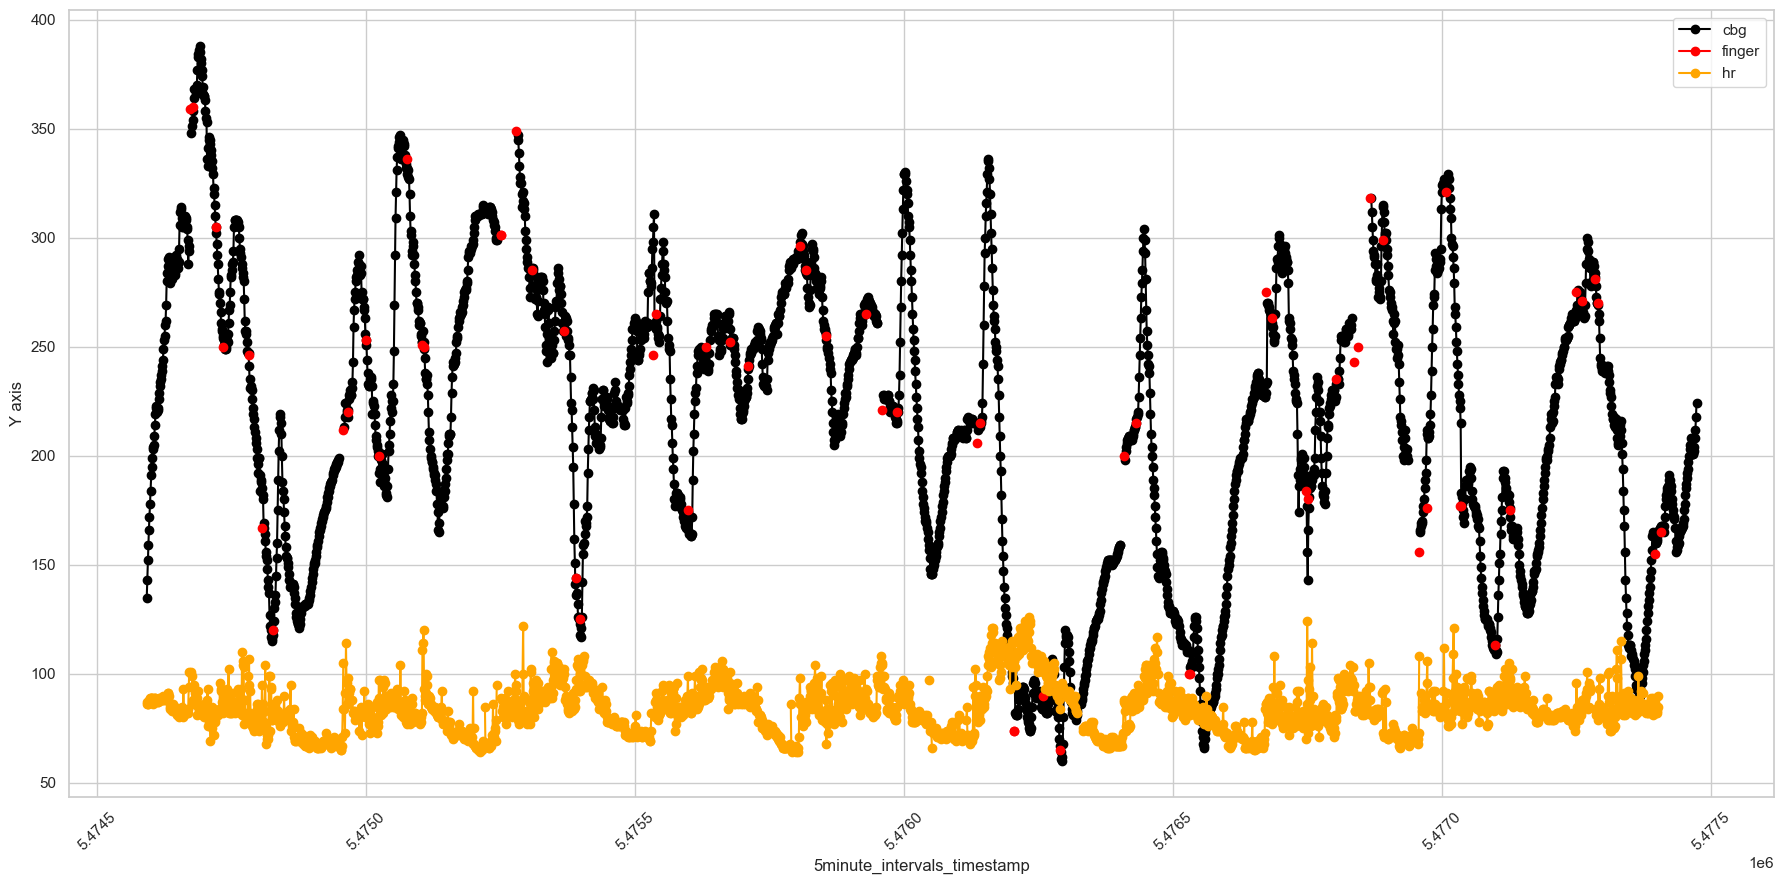

In [32]:
filtered_df = test_set #.head(1000)

# Plot lines
plt.figure(figsize=(18, 9))
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['cbg'], marker='o', linestyle='-', color='black', label='cbg')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['finger'], marker='o', linestyle='-', color='red', label='finger')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['hr'], marker='o', linestyle='-', color='orange', label='hr')

#TODO ADD bolus data to plot 

# # I multipled the basal by 100 just so its easier to see in plot
# plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['basal']*100, marker='o', linestyle='-', color='green', label='basal')

# # Variables that we can still plot and see what happens etc. -> hr, gsr, carbInput, bolus
# # What I think they mean: hr>heart rate, gsr>Galvanic skin response, carbInput -> carb in grams?, 
# # bolus> Insulin delivered to the patient, typically before a meal or when the patient is hyperglycemic.

# # Horizontal line representing for hyper- and hypoglycemia, maybe it helps us see 
# hypoglycemia_threshold = 70  # Not 100% sure about the value 
# plt.axhline(y=hypoglycemia_threshold, color='blue', linestyle='--', label='Hypoglycemia Threshold')
# hyperglycemia_threshold = 140 # Not 100% sure about the value 
# plt.axhline(y=hyperglycemia_threshold, color='blue', linestyle='--', label='Hyperglycemia Threshold')

plt.xlabel('5minute_intervals_timestamp')
plt.ylabel('Y axis')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

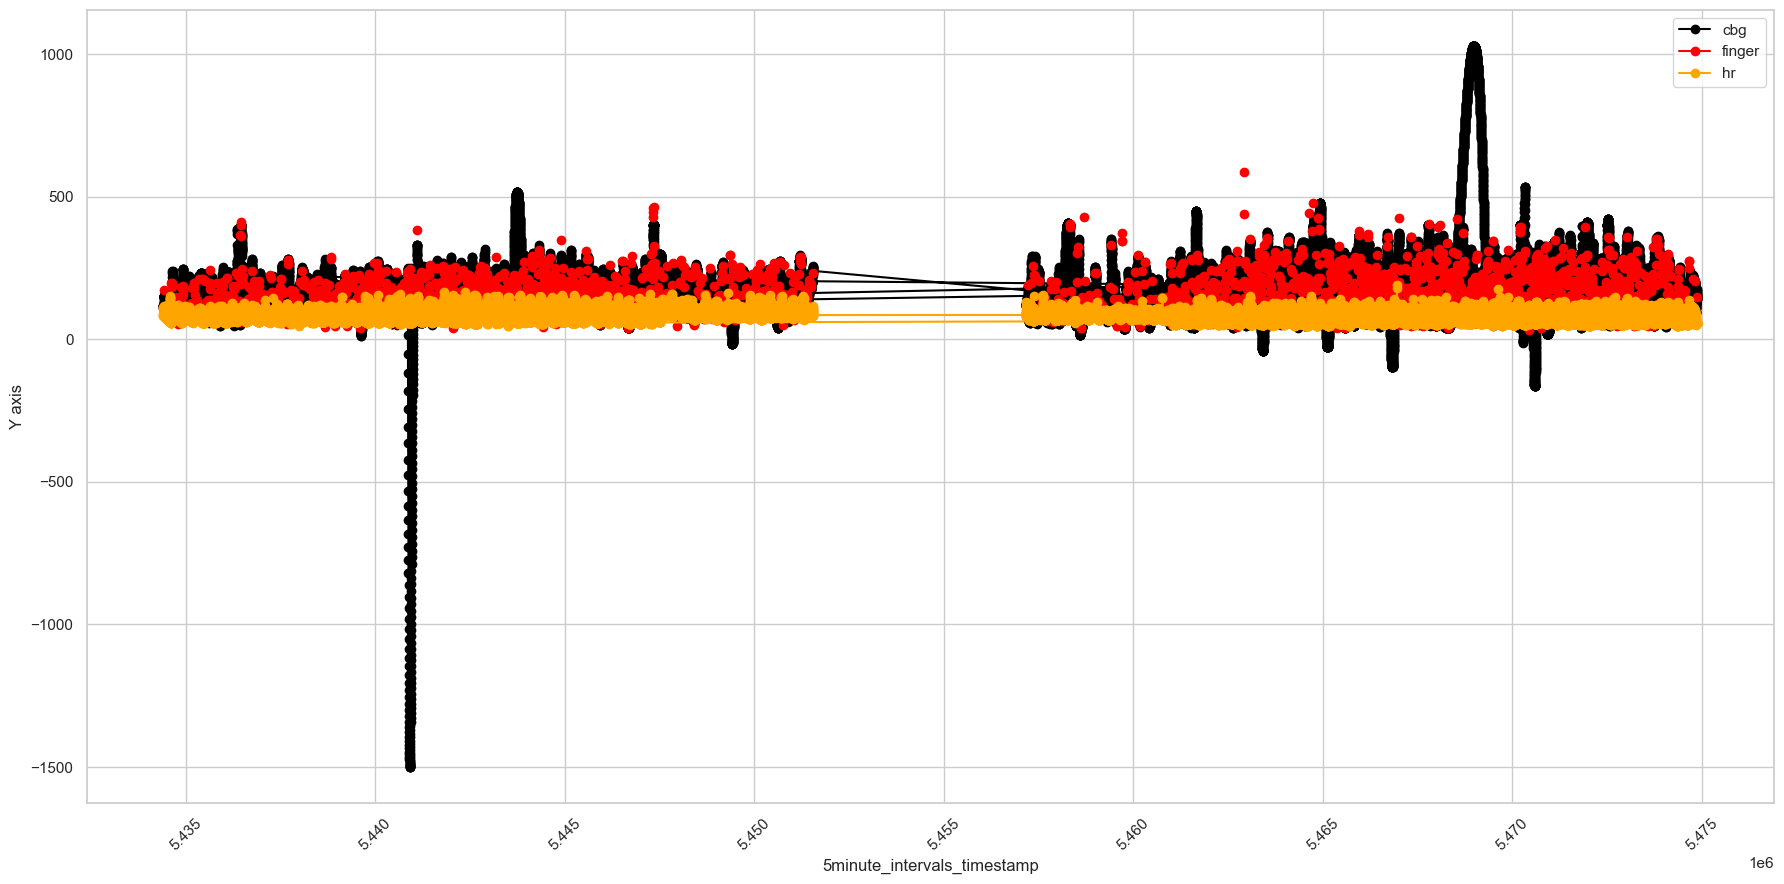

In [56]:
filtered_df = test_preprocessed_old #.head(1000)

# Plot lines
plt.figure(figsize=(18, 9))
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['cbg'], marker='o', linestyle='-', color='black', label='cbg')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['finger'], marker='o', linestyle='-', color='red', label='finger')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['hr'], marker='o', linestyle='-', color='orange', label='hr')
plt.xlabel('5minute_intervals_timestamp')
plt.ylabel('Y axis')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

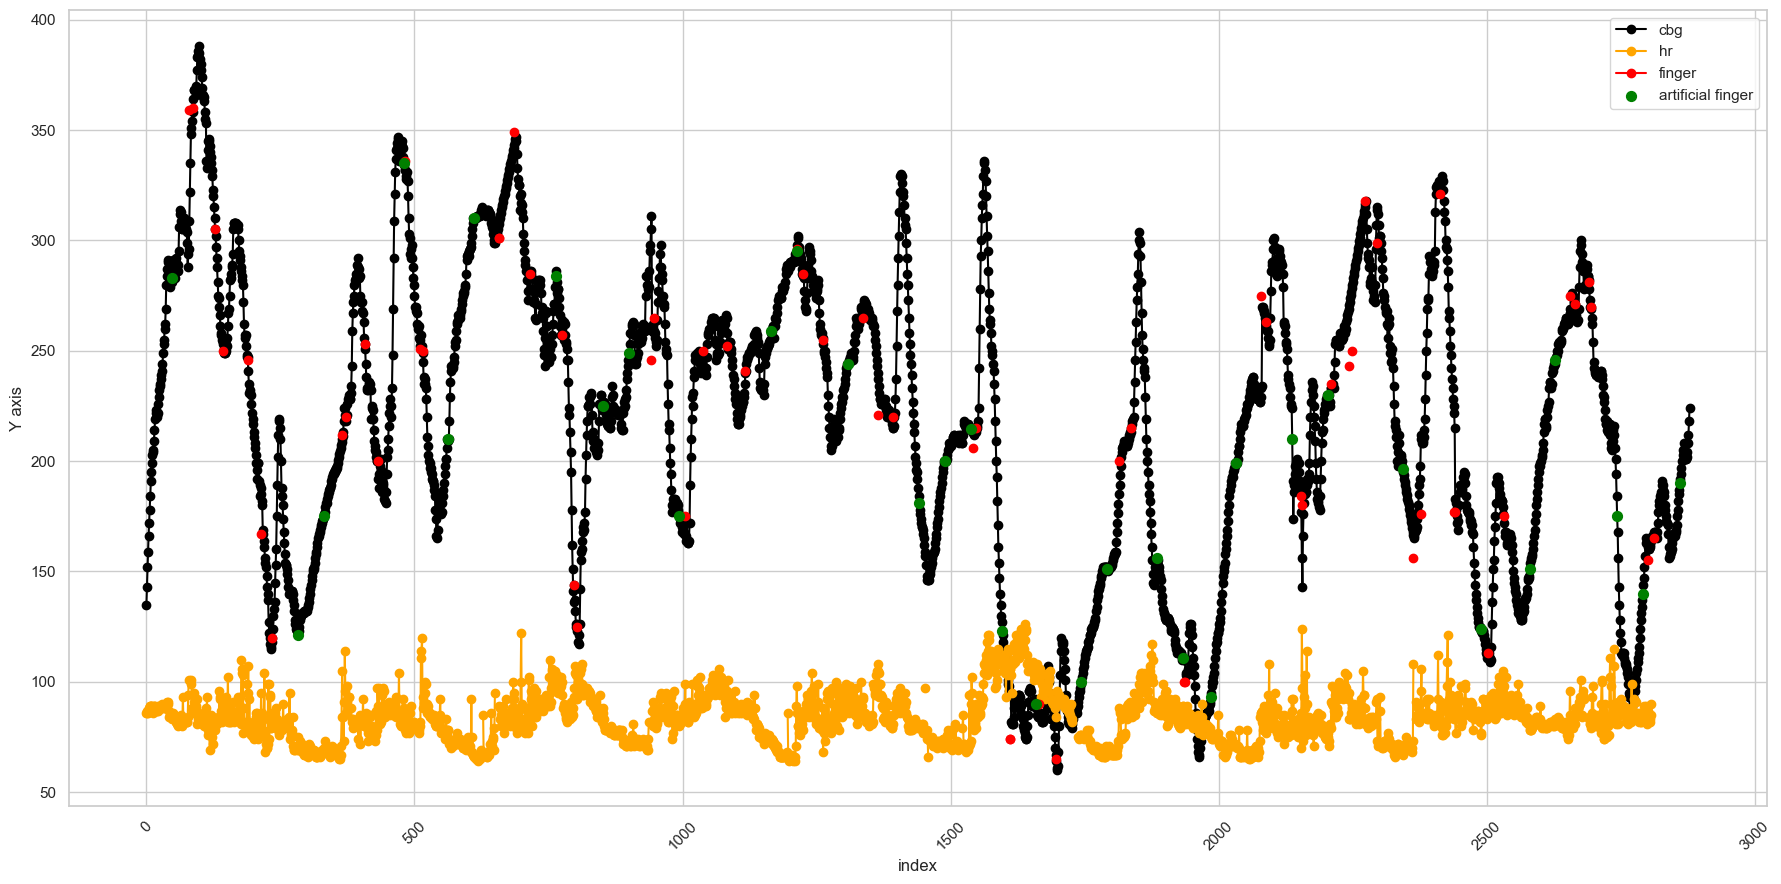

In [94]:
filtered_df = test_preprocessed_old #.head(1000)

# Plot lines
plt.figure(figsize=(18, 9))
x = np.arange(len(filtered_df['finger']))
plt.plot(x, filtered_df['cbg'], marker='o', linestyle='-', color='black', label='cbg')
#plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['finger'], marker='o', linestyle='-', color='red', label='finger')
#plt.scatter(filtered_df['5minute_intervals_timestamp'].iloc[artificial_SMBG_indices], filtered_df['finger'].iloc[artificial_SMBG_indices], marker='o', color='green', label='artificial finger', s=60, zorder=5 )
plt.plot(x, filtered_df['hr'], marker='o', linestyle='-', color='orange', label='hr')

plt.plot(np.arange(len(filtered_df['finger'])),filtered_df['finger'], marker='o', linestyle='-', color='red',label='finger')
plt.scatter(np.arange(len(filtered_df['finger']))[artificial_SMBG_indices],filtered_df['finger'].iloc[artificial_SMBG_indices], marker='o', color='green',label='artificial finger', s=50, zorder=5)

plt.xlabel('index')
plt.ylabel('Y axis')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

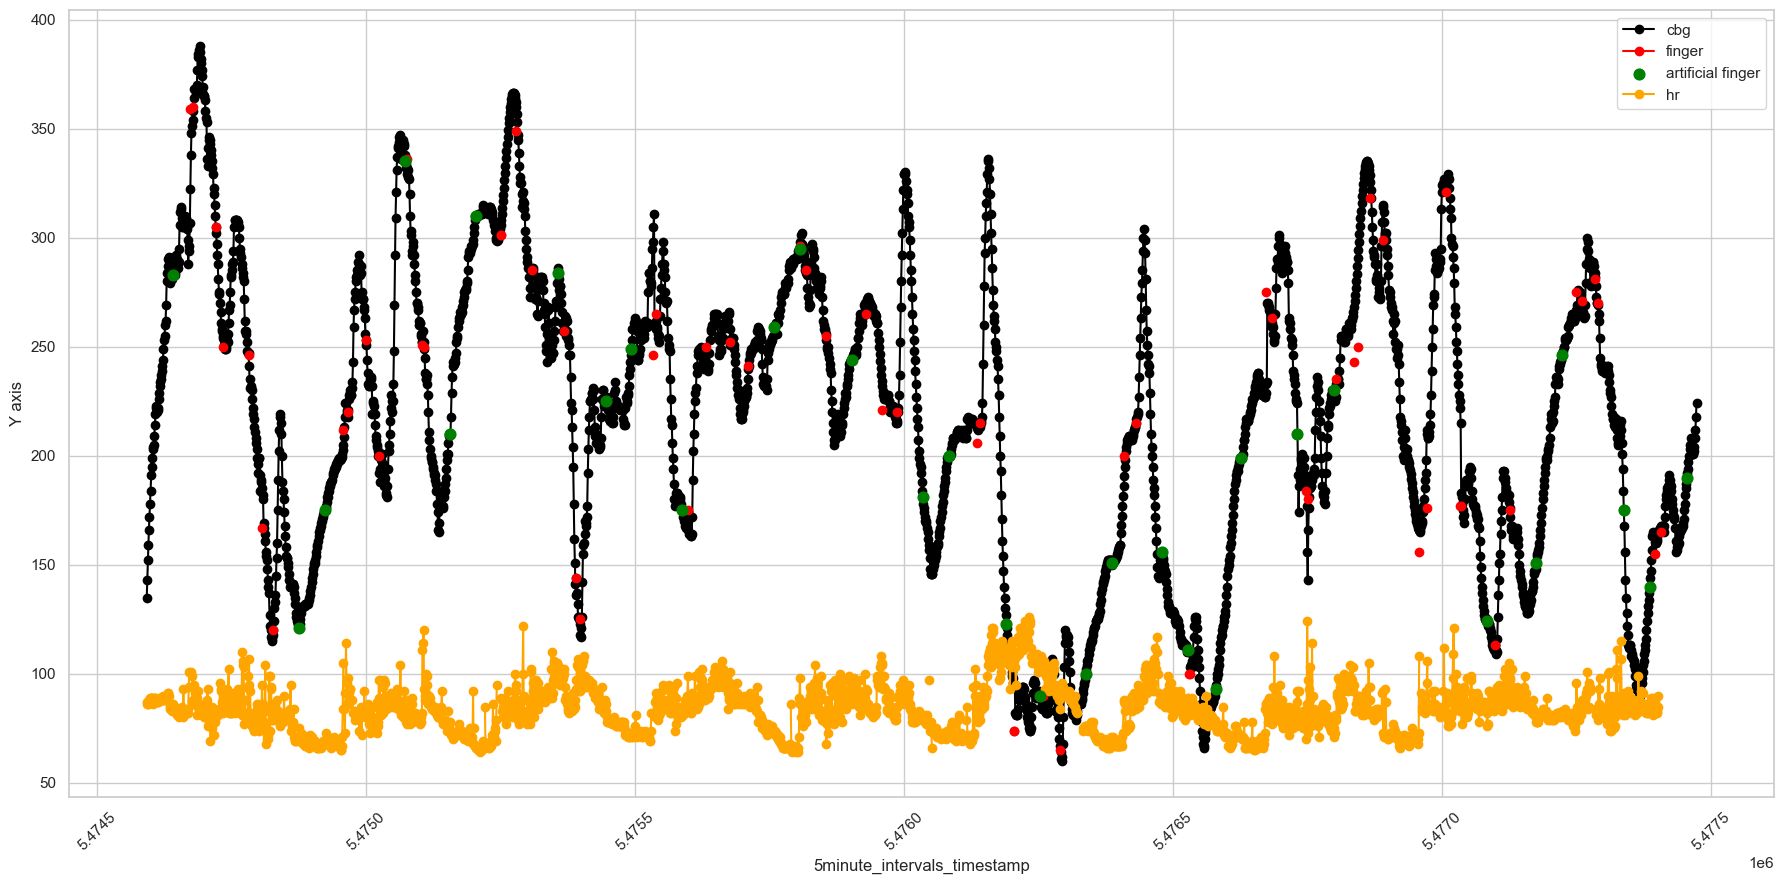

In [62]:
filtered_df = test_preprocessed_old #.head(1000)

# Plot lines
plt.figure(figsize=(18, 9))
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['cbg'], marker='o', linestyle='-', color='black', label='cbg')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['finger'], marker='o', linestyle='-', color='red', label='finger')
plt.scatter(filtered_df['5minute_intervals_timestamp'].iloc[artificial_SMBG_indices], filtered_df['finger'].iloc[artificial_SMBG_indices], marker='o', color='green', label='artificial finger', s=60, zorder=5 )
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['hr'], marker='o', linestyle='-', color='orange', label='hr')

plt.xlabel('5minute_intervals_timestamp')
plt.ylabel('Y axis')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

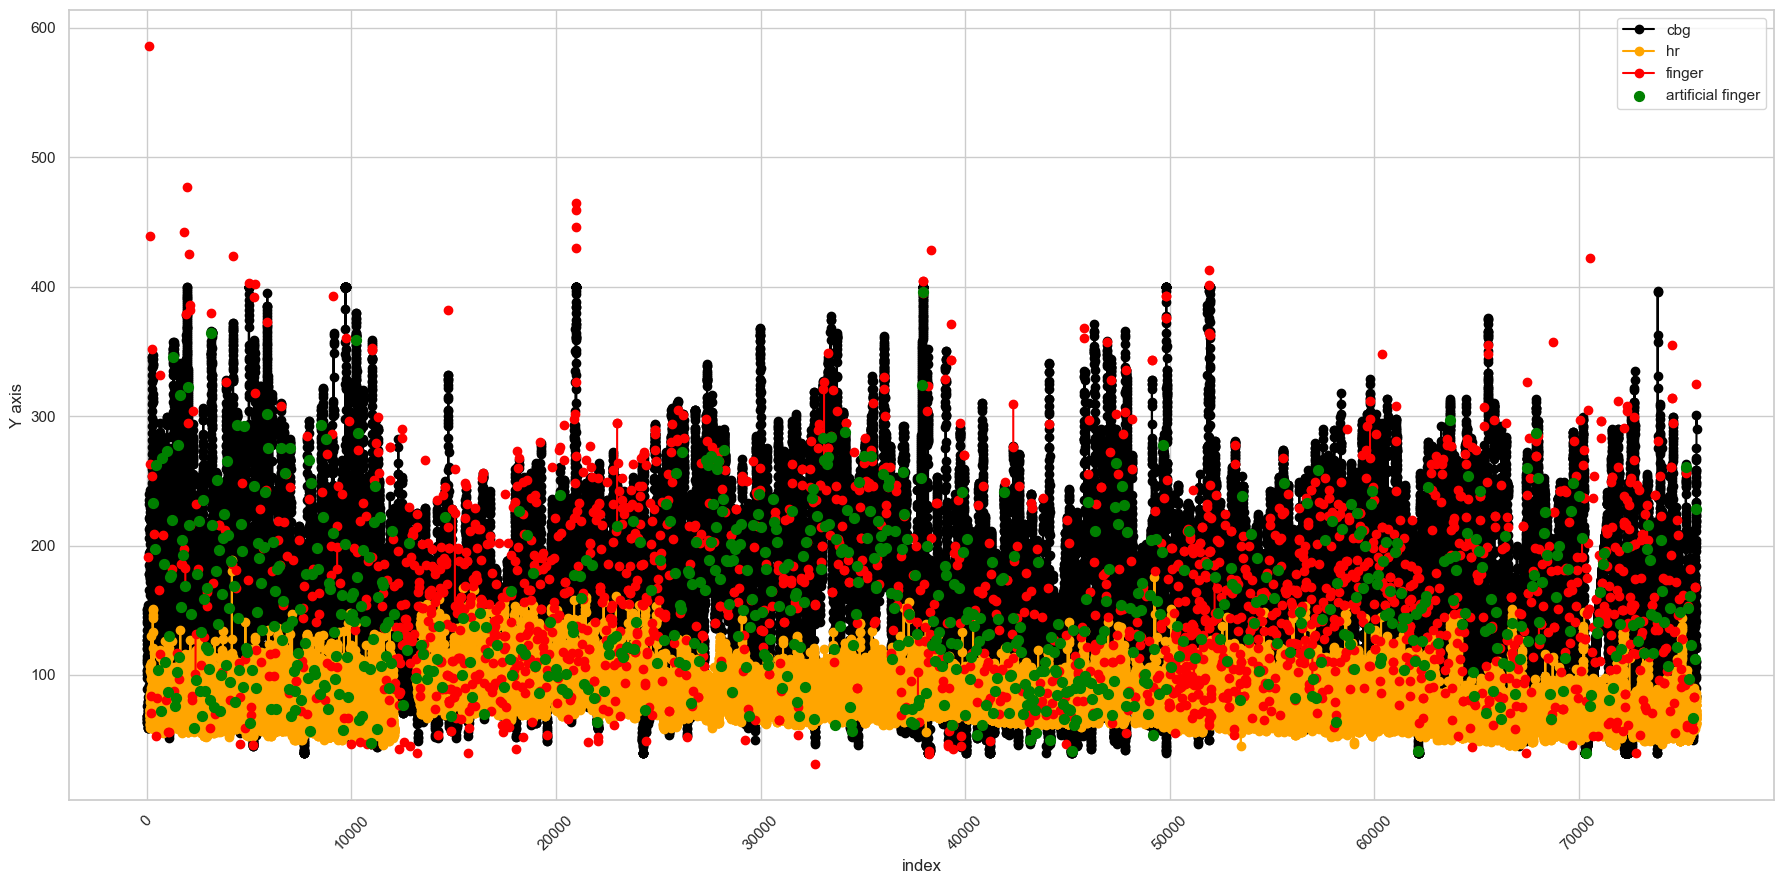

In [49]:
filtered_df = test_preprocessed_old #.head(1000)
artificial_SMBG_indices = np.array(artificial_SMBG_indices)
# artificial_SMBG_indices_head = artificial_SMBG_indices[artificial_SMBG_indices<1000]

# Plot lines
plt.figure(figsize=(18, 9))
x = np.arange(len(filtered_df['finger']))
plt.plot(x, filtered_df['cbg'], marker='o', linestyle='-', color='black', label='cbg')
#plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['finger'], marker='o', linestyle='-', color='red', label='finger')
#plt.scatter(filtered_df['5minute_intervals_timestamp'].iloc[artificial_SMBG_indices], filtered_df['finger'].iloc[artificial_SMBG_indices], marker='o', color='green', label='artificial finger', s=60, zorder=5 )
plt.plot(x, filtered_df['hr'], marker='o', linestyle='-', color='orange', label='hr')

plt.plot(np.arange(len(filtered_df['finger'])),filtered_df['finger'], marker='o', linestyle='-', color='red',label='finger')
plt.scatter(np.arange(len(filtered_df['finger']))[artificial_SMBG_indices],filtered_df['finger'].iloc[artificial_SMBG_indices], marker='o', color='green',label='artificial finger', s=50, zorder=5)

plt.xlabel('index')
plt.ylabel('Y axis')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
np.array(artificial_SMBG_indices)>100

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [111]:
filtered_df['5minute_intervals_timestamp'].iloc[artificial_SMBG_indices]

48      5.474641e+06
283     5.474876e+06
331     5.474924e+06
480     5.475073e+06
563     5.475156e+06
611     5.475204e+06
763     5.475356e+06
852     5.475445e+06
900     5.475493e+06
994     5.475587e+06
1165    5.475758e+06
1213    5.475806e+06
1309    5.475903e+06
1441    5.476035e+06
1489    5.476083e+06
1537    5.476131e+06
1596    5.476190e+06
1659    5.476253e+06
1744    5.476338e+06
1792    5.476386e+06
1885    5.476479e+06
1933    5.476527e+06
1985    5.476579e+06
2033    5.476627e+06
2137    5.476731e+06
2204    5.476798e+06
2343    5.476937e+06
2489    5.477083e+06
2580    5.477174e+06
2628    5.477222e+06
2743    5.477337e+06
2791    5.477385e+06
2860    5.477454e+06
Name: 5minute_intervals_timestamp, dtype: float64


## Create Windowing

In [55]:
index_patient_570 = 2
data = train_set_2018[index_patient_570]
## All together 
non_nan_indices = np.array(data['finger'][~np.isnan(data['finger'])].index)
# Calculate the differences between consecutive non-NaN indices
differences = np.diff(non_nan_indices)
# Compute the average difference
average_distance = differences.mean()
print(f"Average distance between SMBG measurements: {average_distance}")
print(f"Average distance between SMBG measurements in hours: {round(average_distance*5/60)}")

############ Generate windows

#### Check for missing values
indices_missing_cbg = (data['missing_cbg'][data['missing_cbg']==1]).index
print(indices_missing_cbg)
print(f"Number of missing CGM values: {np.sum(data['missing_cbg']==1)}")

diffs = np.diff(indices_missing_cbg)
# Find where the difference between consecutive indices is greater than 1
breaks = np.where(diffs > 1)[0]
print(breaks)
                                       
# Save indices of starts and stops of the missing value windows                                      
start_stops = [indices_missing_cbg[0]]
print(type(indices_missing_cbg[0]))
print(type(start_stops))
for i in breaks:
    start_stops.append(indices_missing_cbg[i])
    start_stops.append(indices_missing_cbg[i+1])

start_stops.append(indices_missing_cbg[-1])

print(start_stops)
                                       
start_stops = np.array(start_stops)

# Save windows with the wanted size of the CGM data (excluding missing values)
print(data['cbg'].shape)
window_size = math.ceil(average_distance)
print(f"Chosen window size: {window_size}")
cgm_windows = []
i = 0
missing_index = 0

print((data['cbg'].shape[0]-window_size))
while(i < (data['cbg'].shape[0]-window_size)):
    if missing_index < start_stops.shape[0]-1:
        if(i < (start_stops[missing_index]-window_size)):
            cgm_windows.append(data['cbg'][i:i+window_size])
            i = i+window_size
        else:
            i = start_stops[missing_index+1]+1
            if (missing_index+1) < start_stops.shape[0]-1:
                missing_index+=2
            else: 
                missing_index+=1
    else:
        cgm_windows.append(data['cbg'][i:i+window_size])
        i = i+window_size
            
    

test = np.array(cgm_windows)
test.shape

Average distance between SMBG measurements: 48.28451882845188
Average distance between SMBG measurements in hours: 4
Index([   70,    71,    72,  1705,  1706,  1707,  1708,  1709,  1710,  1711,
       ...
       11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136, 11137, 11138],
      dtype='int64', length=629)
Number of missing CGM values: 629
[  2  32  47  76 119 139 150 151 181 231 237 268 278 308 452 511 526 568
 602]
<class 'numpy.int64'>
<class 'list'>
[70, 72, 1705, 1734, 2758, 2772, 2931, 2959, 3030, 3072, 3349, 3368, 4327, 4337, 4366, 4366, 4633, 4662, 4733, 4782, 5657, 5662, 6322, 6352, 7381, 7390, 8076, 8105, 8952, 9095, 9322, 9380, 9522, 9536, 10663, 10704, 10775, 10808, 11113, 11138]
(11611,)
Chosen window size: 49
11562


(212, 49)

In [56]:
# def make_predictions(scaler, x_train, y_train, x_test, y_test, batch_size=1, epochs=1):
#     # LSTM Model 

#     # Using the number of features in x_train to dynamically determine the input shape
#     num_features = x_train.shape[2]
    
#     # WE CAN TRY AFTER IT WORKS WITH 100 UNITS 
#     model = Sequential()
#     model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], num_features)))
#     model.add(LSTM(units=50, return_sequences=False))
#     model.add(Dropout(0.5))
#     model.add(Dense(units=y_train.shape[1]*num_features)) # error maybe here

#     model.compile(optimizer="adam", loss='mse',metrics=['accuracy'])

#     print(np.shape(x_train))
#     print(np.shape(y_train))
    
#     model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

#     # Make predictions
#     predictions = model.predict(x_test)
#     predictions = np.reshape(predictions, (predictions.shape[0],predictions.shape[1])) # reshape just like y_test

#     predictions = scaler.inverse_transform(predictions) # reverse data

#     # Create a continuous data of predictions to plot with continuous_ytest
#     continuous_predictions = predictions[0]
#     for i in range(1,len(predictions)):
#         continuous_predictions = np.concatenate([continuous_predictions,predictions[i]])

#     rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

#     return model, predictions, continuous_predictions, rmse